# Counter Strike GO - Round Winner Classification

Machine Learning II - Group Assignment

Team E - **William Kingwill, Julius von Selchow, Emily Yorke, Sydne-Aline Strasser, Tarek ElNoury, Alain Grullon**

Data - https://www.kaggle.com/christianlillelund/csgo-round-winner-classification


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## Agenda

**I. Python environment setup**

**II. Data source set-up**
  
**III. Explorative Data Analysis (EDA)**
  1. Data Cleaning & Feature Factorization
  2. Outlier Analysis & Handling
  3. Visualizations
  
**IV. Feature Engineering**
  1. PCA Analysis
  2. Manual Feature Engineering
  
**V. Train-Test Splitting**
  
**VI. Prediction Algorithms**
  1. Log Regression
  2. Ridge Regression
  3. Lasso Regression
  4. Random Forest
  5. XGBoost
  6. SVM

**VII. Additional Code - Testing purposes only**

## Gameplay

“CS:GO is a tactical shooter, where two teams (CT and
Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5
players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start,
one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There
are 7 different maps a game can be played on. You win a round as Terrorist by either planting the
bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either
eliminating the other team, or by disarming the bomb, should it have been planted.”

# I. Environment setup

In [2]:
# data manipulation
import numpy as np
import pandas as pd
import pandas_profiling
import datetime
import math as m

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML libraries
import os
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split


# styling
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
sns.set_context('talk')

# instal l libraries
# conda install -c conda-forge pydotplus

# II. Data source setup

In [3]:
# read datasets
train_data = pd.read_csv('training_set.csv')
test_data = pd.read_csv('test_set.csv')

In [4]:
train_data.shape

(82014, 97)

In [5]:
test_data.shape

(40396, 96)

# III. Explorative Data Analysis (EDA)

In [6]:
train_data.head()

time_left  ct_score  t_score         map  bomb_planted  ct_health  \
0      94.96      11.0      2.0    de_train         False      392.0   
1     175.00      13.0      9.0     de_nuke         False      500.0   
2     175.00      14.0     11.0  de_inferno         False      500.0   
3      74.89      12.0     11.0  de_inferno         False      439.0   
4     110.04       3.0     12.0     de_nuke         False      500.0   

   t_health  ct_armor  t_armor  ct_money  ...  t_grenade_flashbang  \
0     500.0     379.0    500.0   23300.0  ...                  5.0   
1     500.0       0.0    300.0   28150.0  ...                  3.0   
2     500.0     486.0    288.0   11650.0  ...                  3.0   
3     489.0     443.0    434.0    3500.0  ...                  4.0   
4     500.0     500.0    400.0     700.0  ...                  0.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      2.0                     5.0   
1                      0.0                     2.0   
2                      5.0                     2.0   
3                      4.0                     4.0   
4                      0.0                     0.0   

   ct_grenade_incendiarygrenade  t_grenade_incendiarygrenade  \
0                           1.0                          0.0   
1                           0.0                          0.0   
2                           3.0                          0.0   
3                           3.0                          0.0   
4                           0.0                          0.0   

   ct_grenade_molotovgrenade  t_grenade_molotovgrenade  \
0                        0.0                       3.0   
1                        0.0                       1.0   
2                        1.0                       3.0   
3                        0.0                       1.0   
4                        0.0                       1.0   

   ct_grenade_decoygrenade  t_grenade_decoygrenade  round_winner  
0                      0.0                     1.0            CT  
1                      0.0                     0.0             T  
2                      0.0                     0.0             T  
3                      0.0                     0.0            CT  
4                      0.0                     1.0             T  

[5 rows x 97 columns]

In [8]:
report = pandas_profiling.ProfileReport(train_data)
report

/Users/jvs22/opt/anaconda3/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [145]:
report.to_file('ML2_report.html')

## 3.1. Data Cleaning & Feature Factorization

#### Drop duplicate rows 

From the column profiling it was seen that there are duplicate rows in this data set. To handle this all duplicates were droped from the dataset

In [7]:
# drop duplicate rows
train_data = train_data.drop_duplicates(keep='first', inplace=False)

# test_data = test_data.drop_duplicates(keep='first', inplace=False)

#### Catagorical columns 

There are columns that contain catagorical data in the dataset. These include **bomb planted**, **round_winner** and **maps**. 
To handle these columns boolean encoding will  be done to each of the respective coloumns.

In [8]:
# Boolean encode bomb_planted column 
train_data['bomb_planted'] = train_data['bomb_planted'].astype(int) # feature factorization
test_data['bomb_planted'] = test_data['bomb_planted'].astype(int) # feature factorization

In [9]:
# dummy encoding the map column
train_data['maps'] = train_data['map']
train_data = pd.get_dummies(data = train_data, columns= ['map'], dtype= float) # feature factorization

# dummy encoding the map column
test_data['maps'] = test_data['map']
test_data = pd.get_dummies(data = test_data, columns= ['map'], dtype= float) # feature factorization

In [10]:
# replace 'CT' with 1 and 'T' with 0
train_data['round_winner'] = train_data['round_winner'].replace('CT',1).replace('T',0)

# test_data['round_winner'] = test_data['round_winner'].replace('CT',1).replace('T',0)

#### Advanced Factorization 

The timeleft_bin contains a level of detail that is fare more fine grained than we need. A bucketized feature will be created to represent the time left in different catagories. These catagories will be in 20 second increments from 180s left till 0 sec left. 

In [11]:
# create time bins in 20s intervalls
train_data["timeleft_bin"] = pd.cut(train_data.time_left, bins= [0,20,40,60,80,100,120,140,160,180],labels = [20,40,60,80,100,120,140,160,180]).astype('int64') # advanced feature factorization
test_data["timeleft_bin"] = pd.cut(test_data.time_left, bins= [0,20,40,60,80,100,120,140,160,180],labels = [20,40,60,80,100,120,140,160,180]).astype('int64') # advanced feature factorization







### Data Types and Null values

The data typw of the relevent columns will be explored as well as Null values in the data set. 

In [12]:
# show datatypes
pd.DataFrame(train_data.dtypes)

0
time_left        float64
ct_score         float64
t_score          float64
bomb_planted       int32
ct_health        float64
...                  ...
map_de_nuke      float64
map_de_overpass  float64
map_de_train     float64
map_de_vertigo   float64
timeleft_bin       int64

[106 rows x 1 columns]

In [49]:
# check for null values
print(train_data.isnull().sum())
print("Total number of Null values: ", train_data.isnull().sum().sum())

time_left          0
ct_score           0
t_score            0
bomb_planted       0
ct_health          0
                  ..
map_de_nuke        0
map_de_overpass    0
map_de_train       0
map_de_vertigo     0
timeleft_bin       0
Length: 106, dtype: int64
Total number of Null values:  0


Can be seen that there are no null values in the data set. No further null value handeling needs to be done

## 3.2 Outlier Analysis

Another aspect that may affect the performance of our machine learning pipeline is the presence of outliers. We will focus on the numerical columns of the dataset to detect the presence of outliers and proceed to their removal.

The easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.


In [16]:
# create outlier removal function
#def remove_outlier(df_in, col_name):
#    q1 = df_in[col_name].quantile(0.25)
#    q3 = df_in[col_name].quantile(0.75)
#    iqr = q3-q1 #Interquartile range
#    fence_low  = q1-1.5*iqr
#    fence_high = q3+1.5*iqr
#    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
#    print("{} outliers removed".format(len(df_in)-len(df_out)))
#    return df_out

In [17]:
# sub_train_data = remove_outlier(train_data, 't_score')

Analyzing outliers of column: time_left


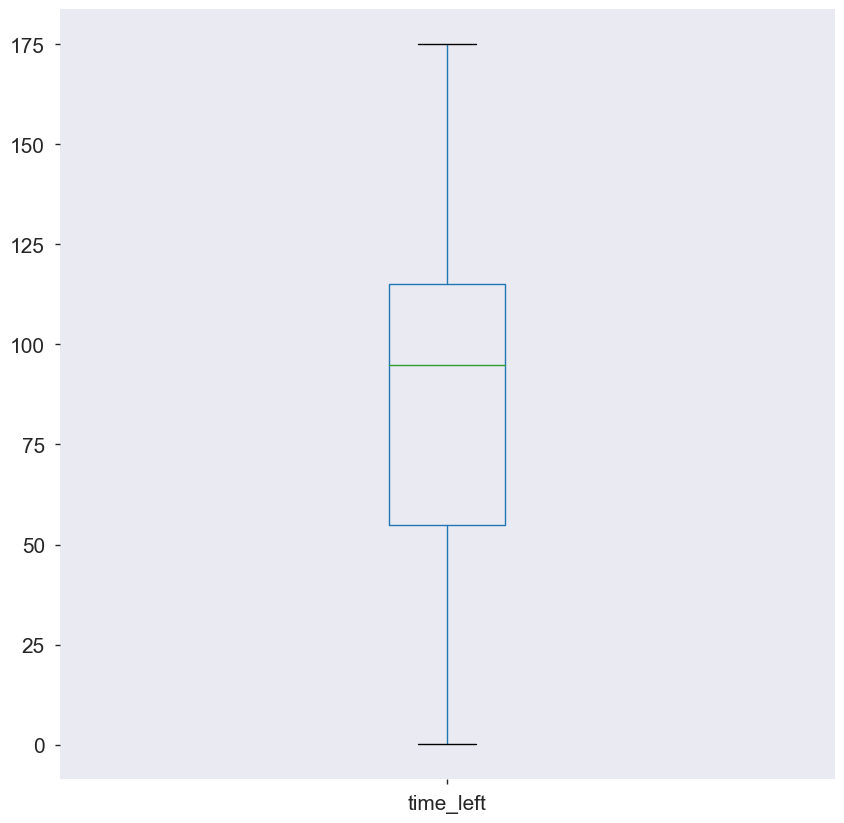

Analyzing outliers of column: ct_score


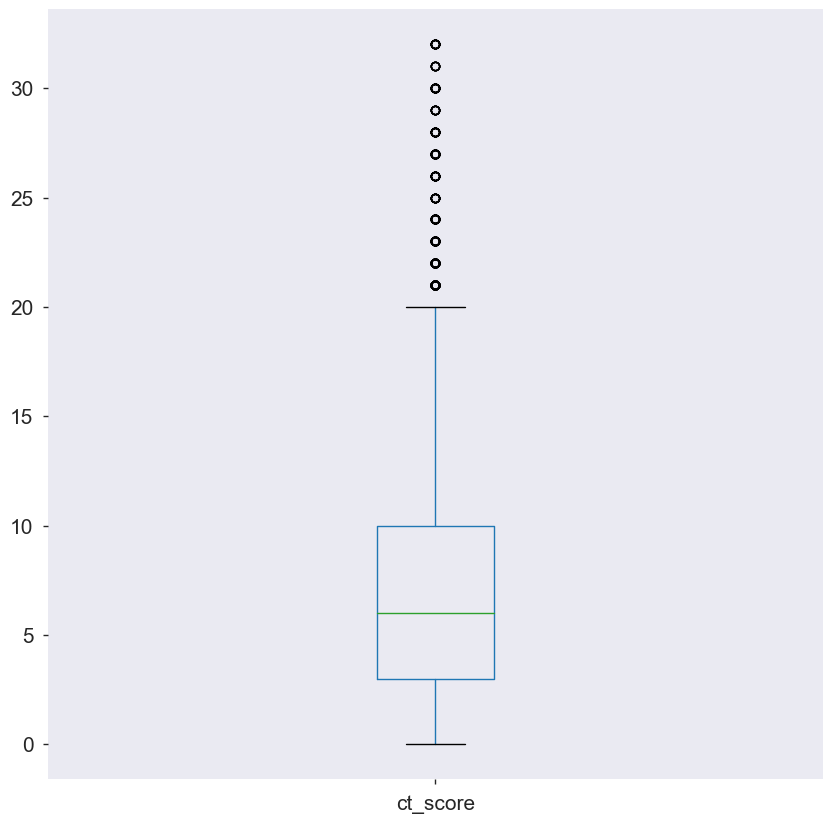

Analyzing outliers of column: t_score


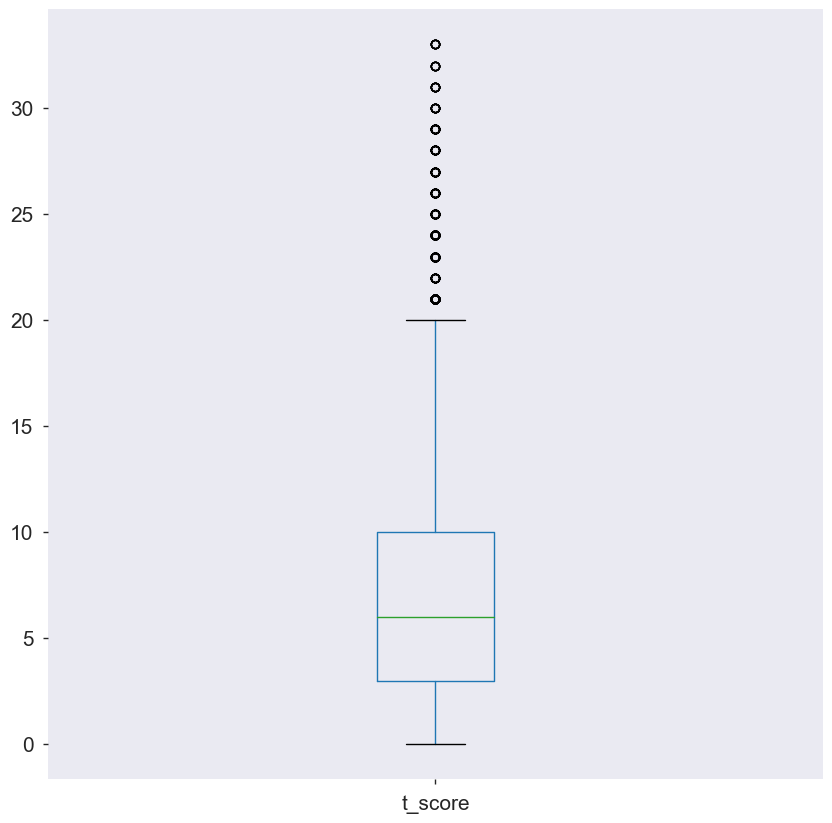

Analyzing outliers of column: bomb_planted


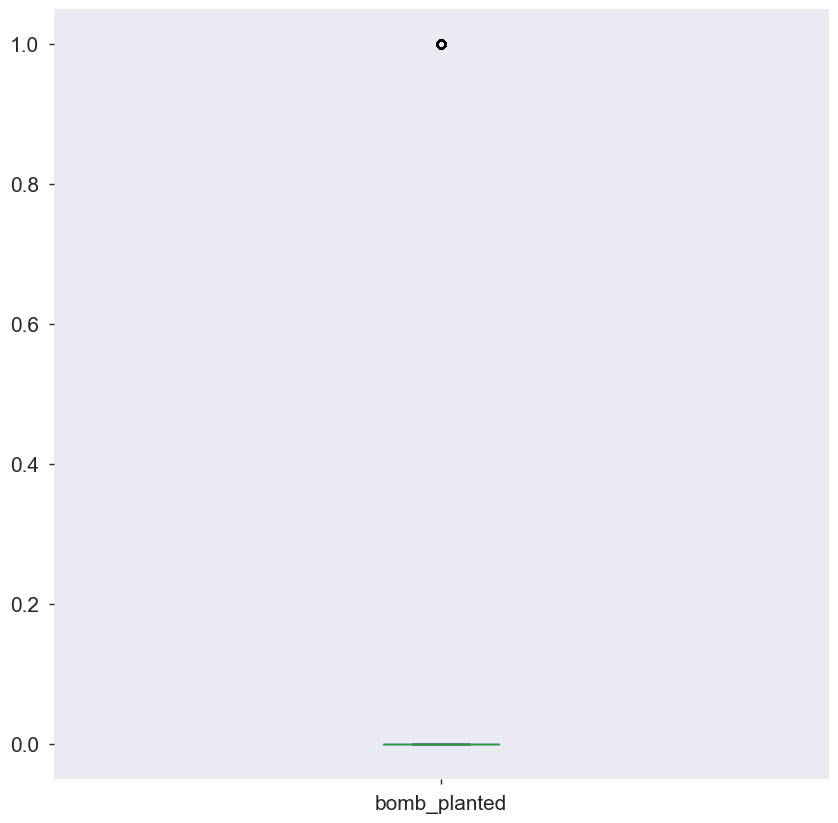

Analyzing outliers of column: ct_health


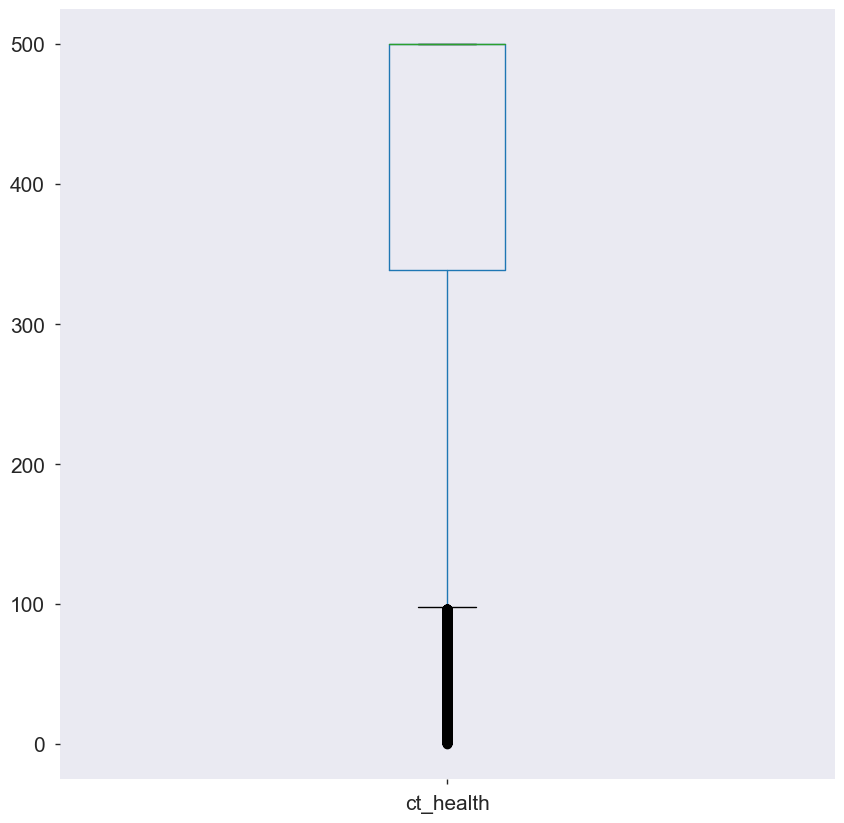

Analyzing outliers of column: t_health


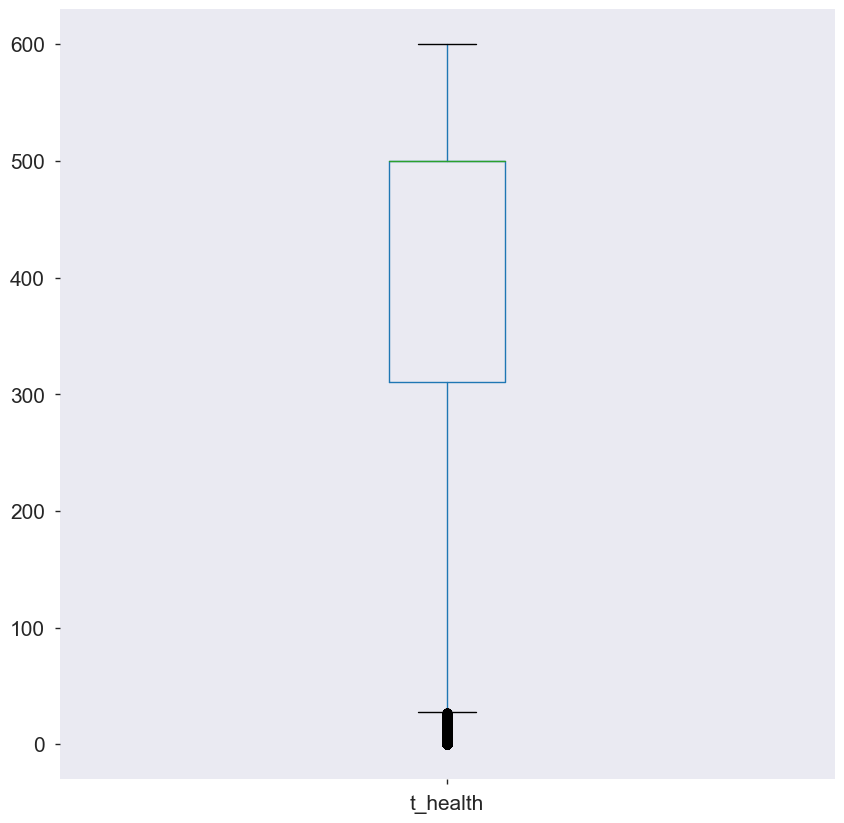

Analyzing outliers of column: ct_armor


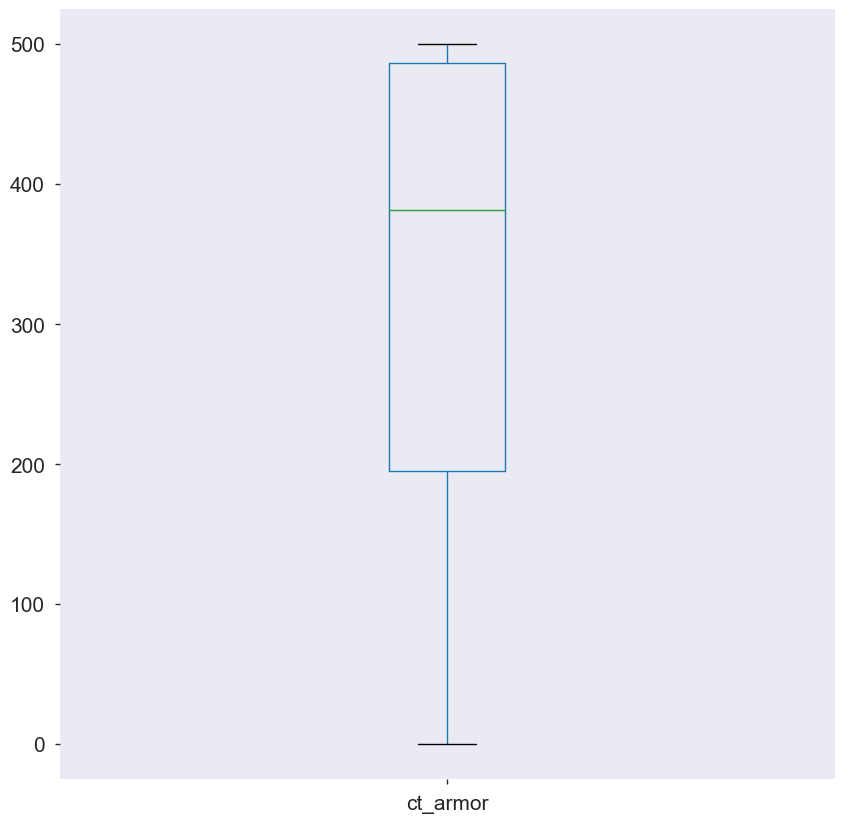

Analyzing outliers of column: t_armor


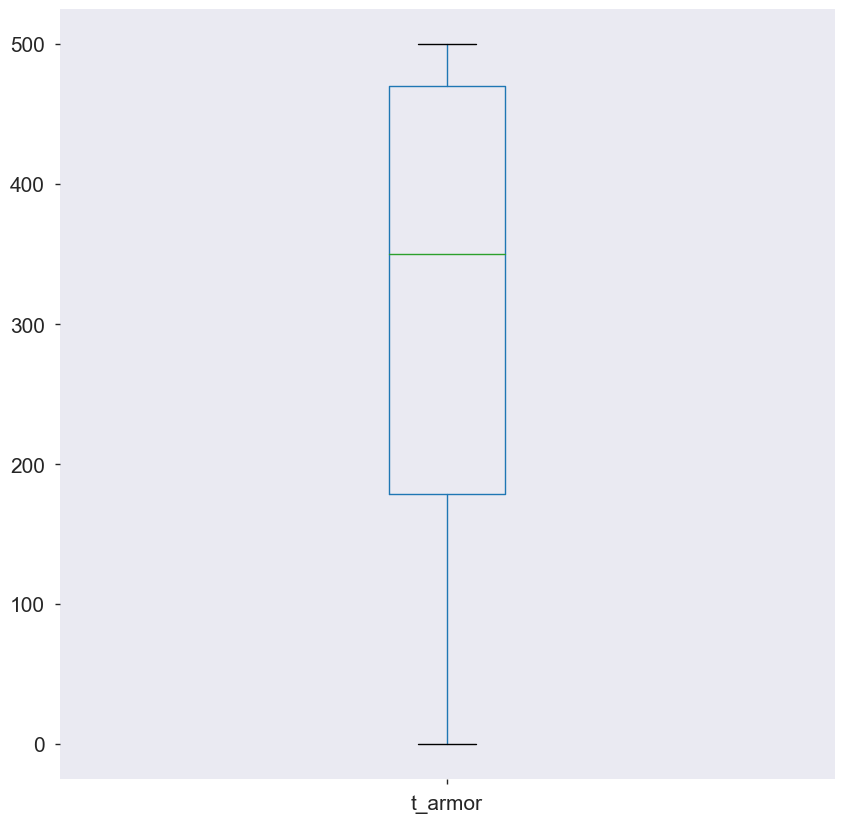

Analyzing outliers of column: ct_money


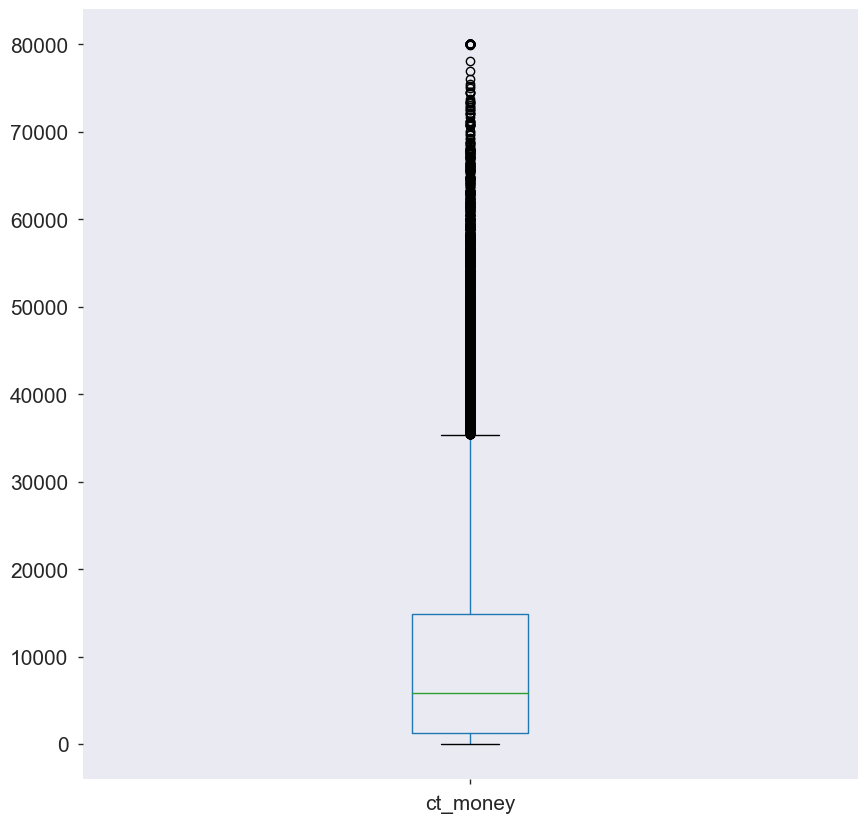

Analyzing outliers of column: t_money


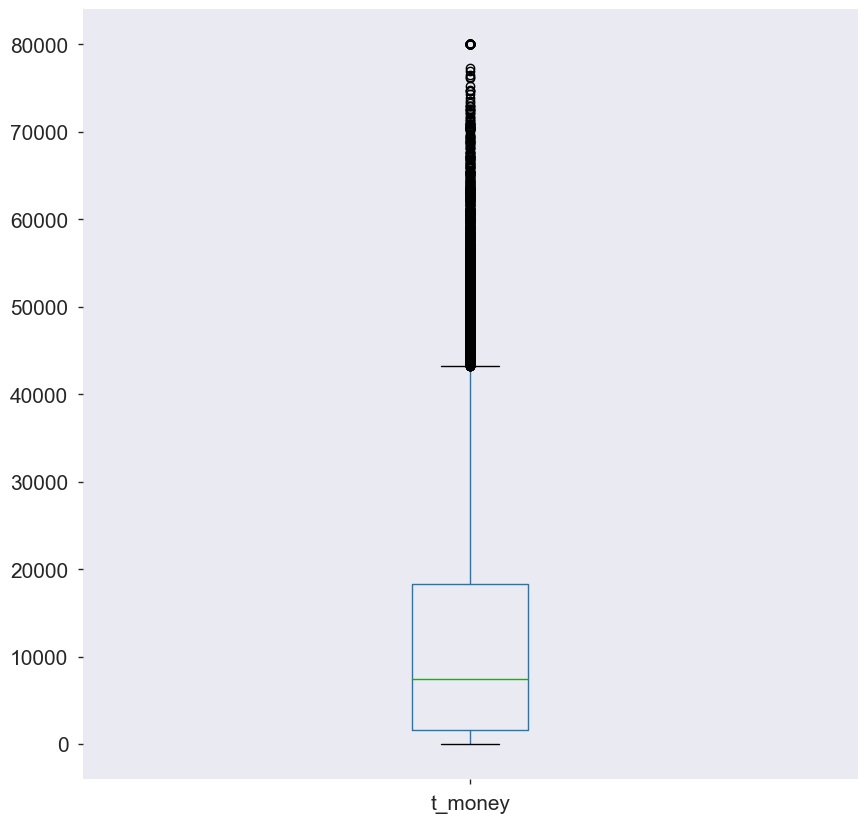

Analyzing outliers of column: ct_helmets


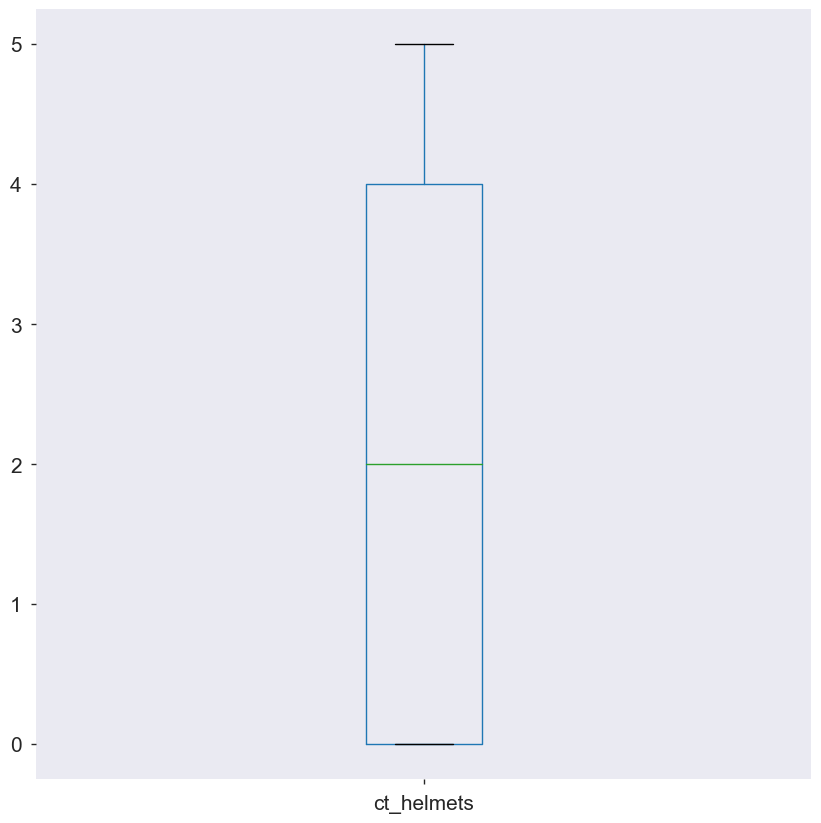

Analyzing outliers of column: t_helmets


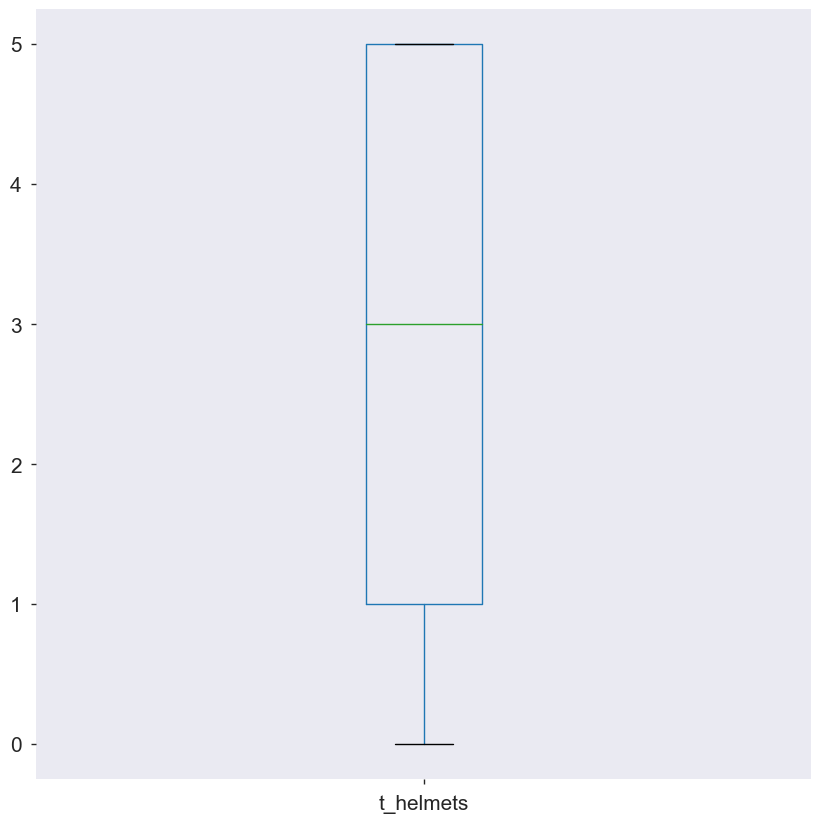

Analyzing outliers of column: ct_defuse_kits


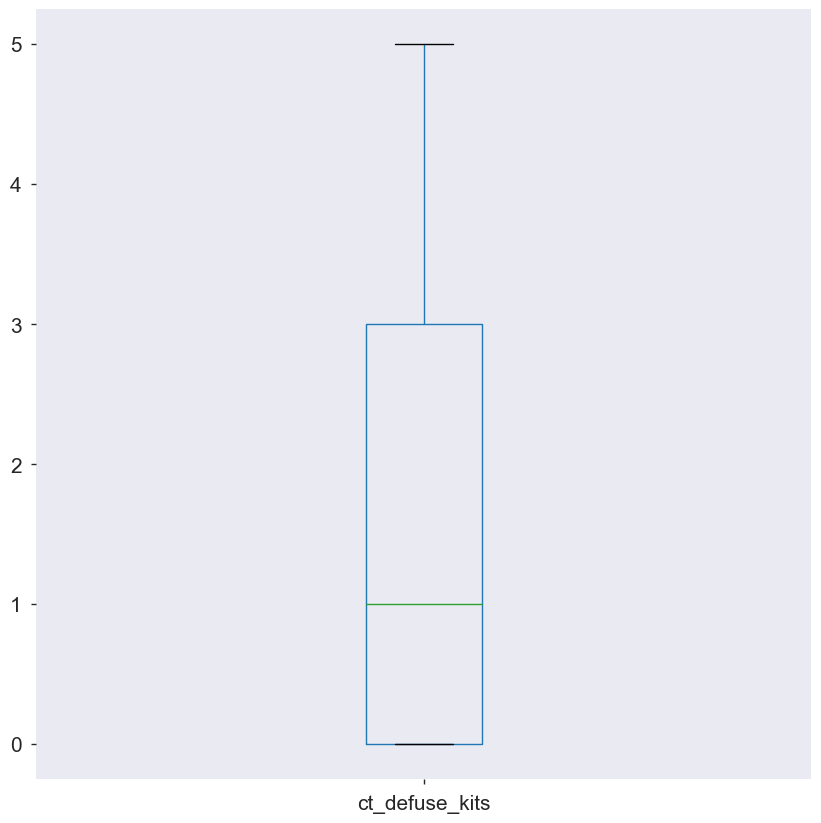

Analyzing outliers of column: ct_players_alive


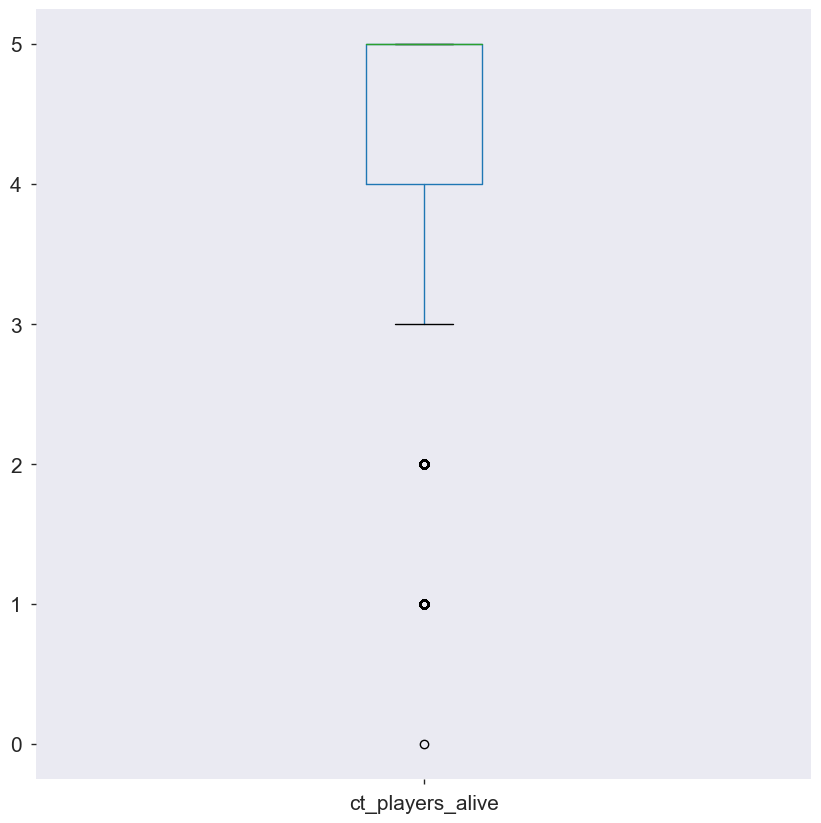

Analyzing outliers of column: t_players_alive


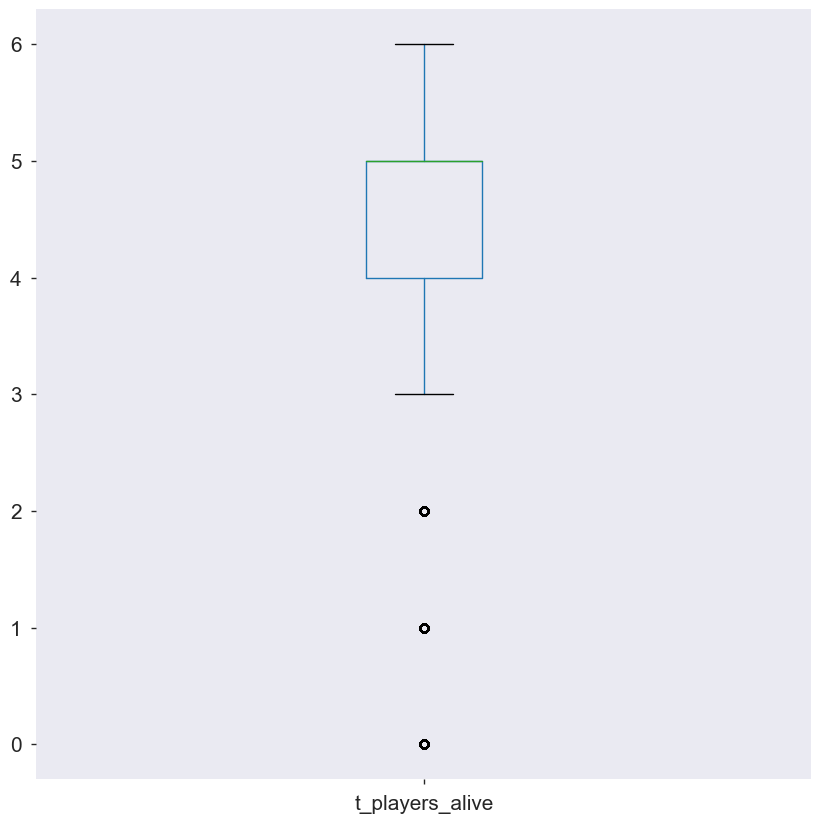

Analyzing outliers of column: ct_weapon_ak47


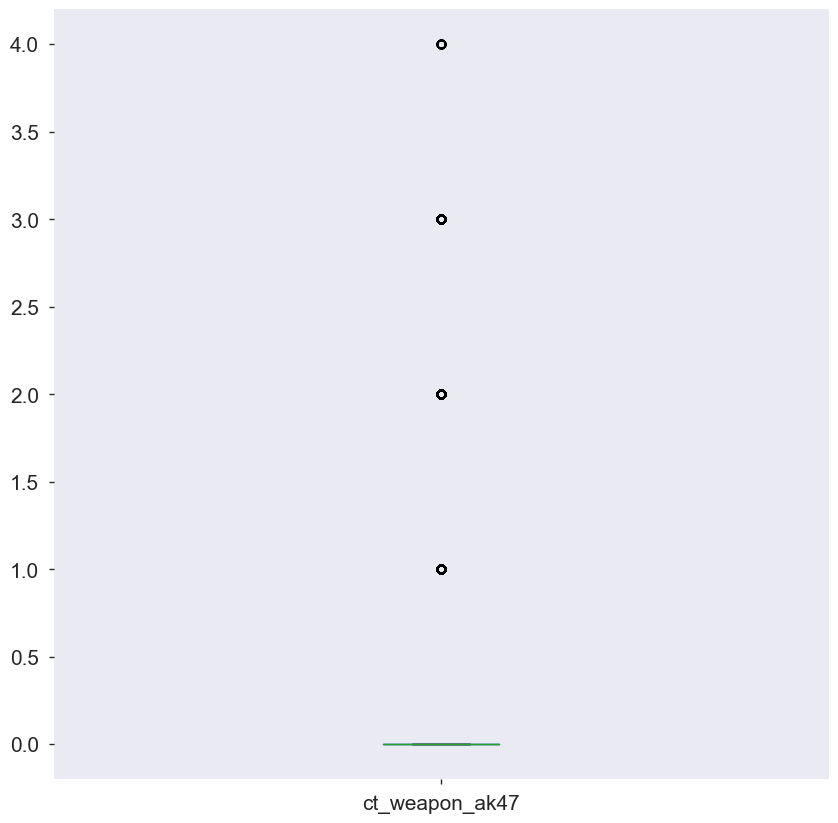

Analyzing outliers of column: t_weapon_ak47


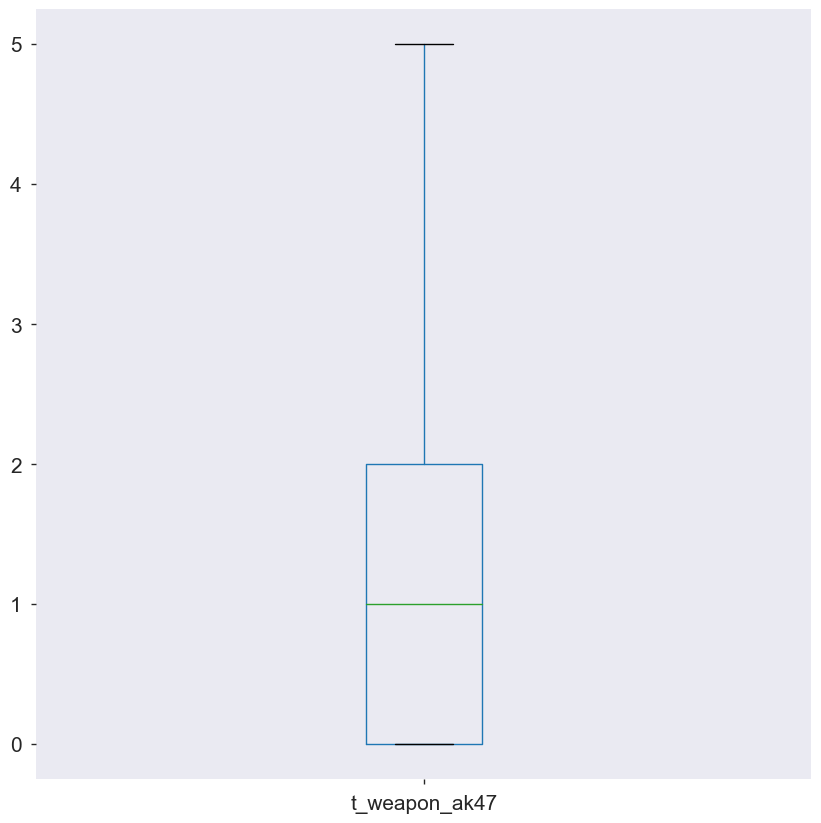

Analyzing outliers of column: ct_weapon_aug


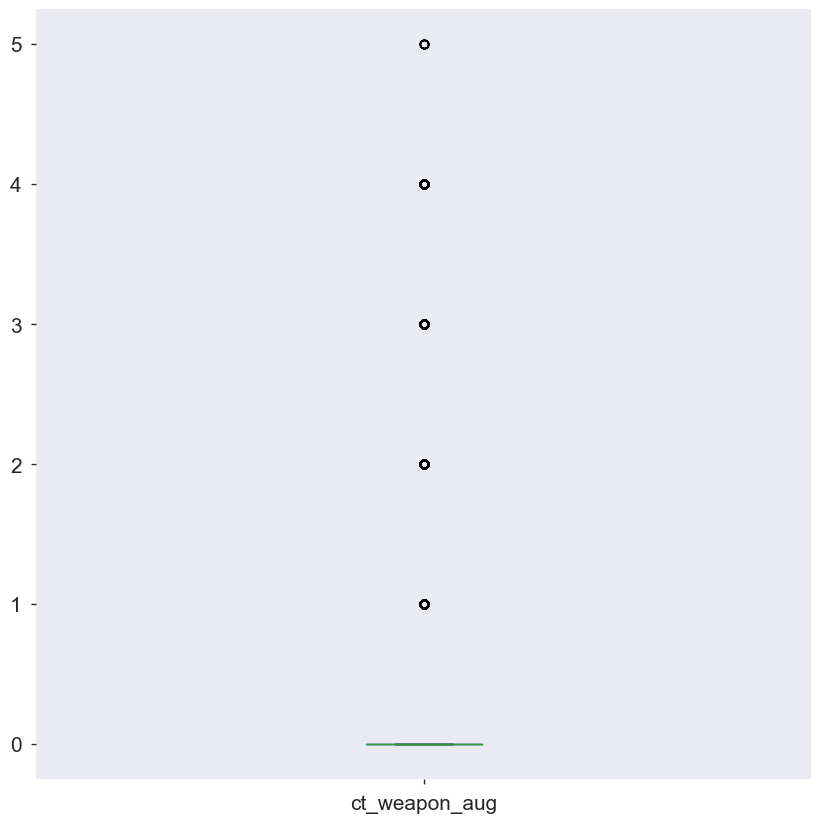

Analyzing outliers of column: t_weapon_aug


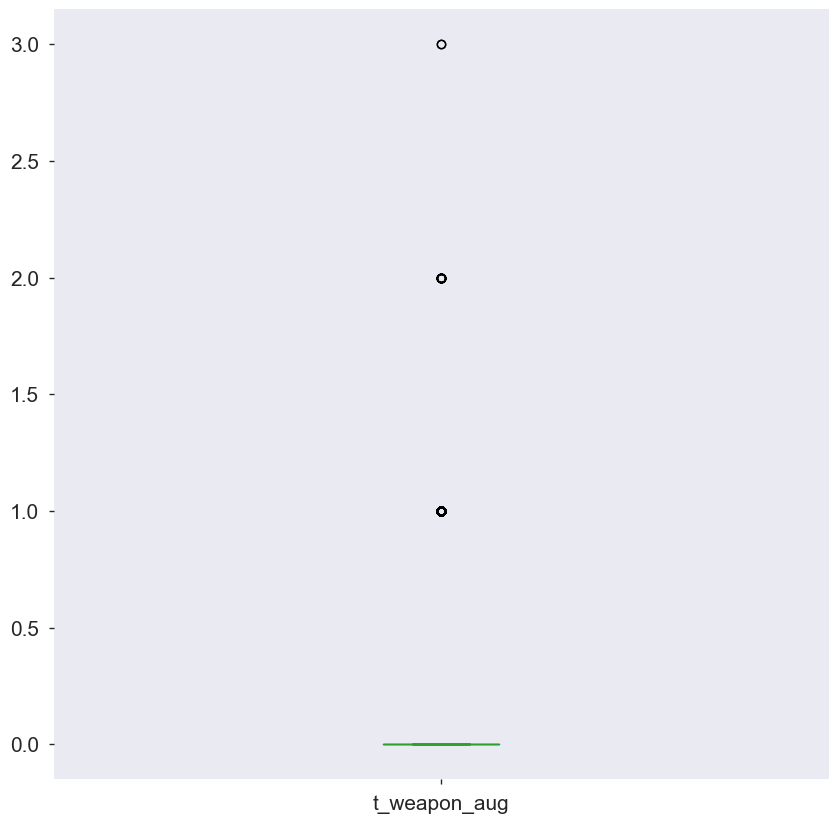

Analyzing outliers of column: ct_weapon_awp


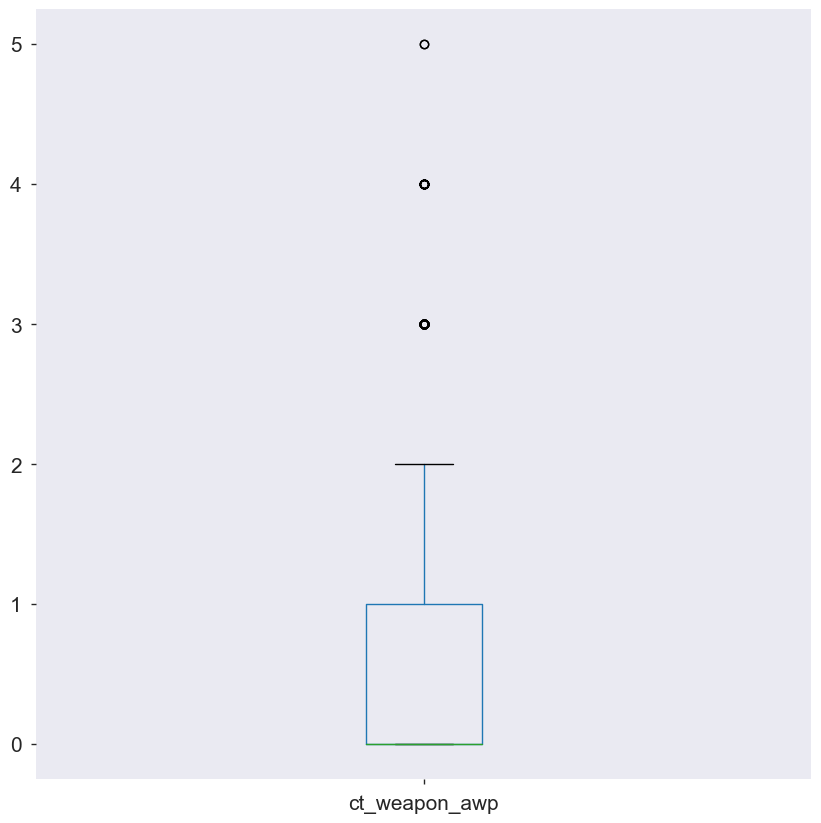

Analyzing outliers of column: t_weapon_awp


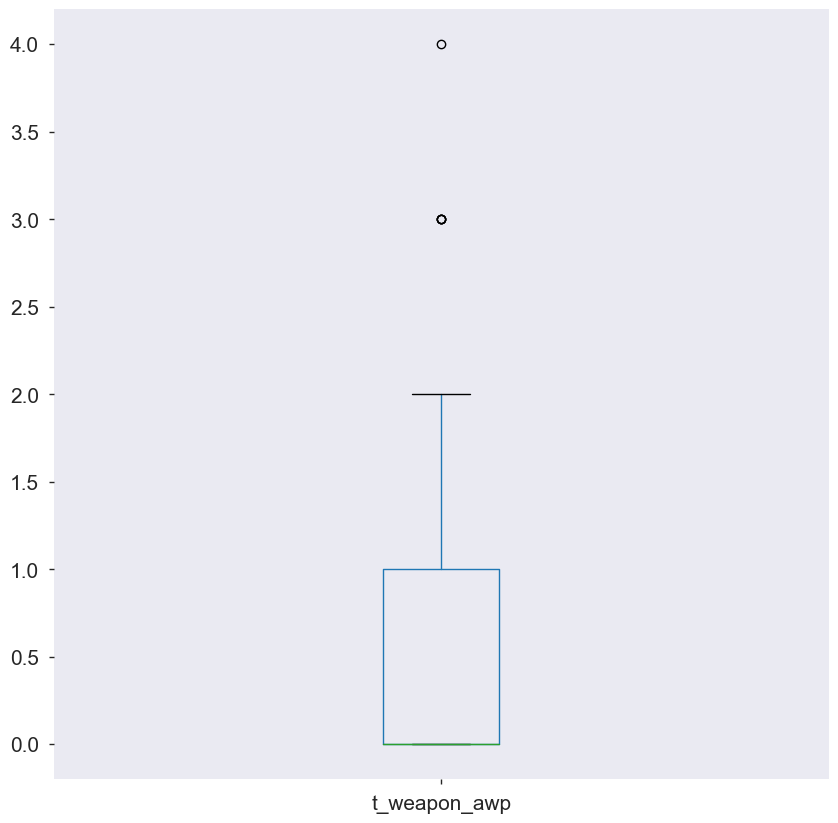

Analyzing outliers of column: ct_weapon_bizon


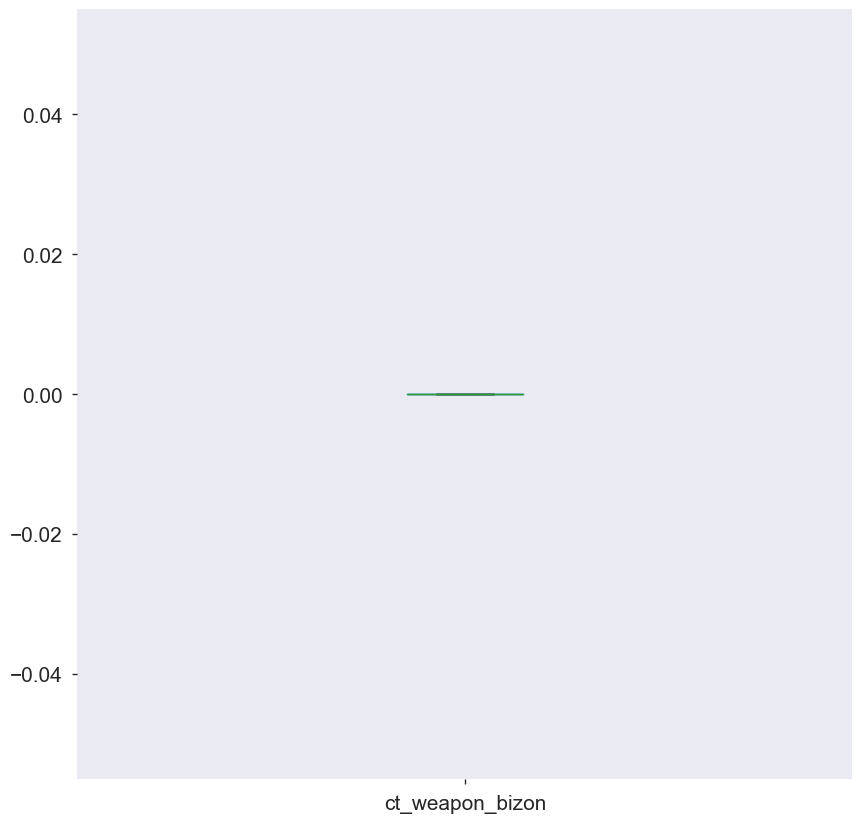

Analyzing outliers of column: t_weapon_bizon


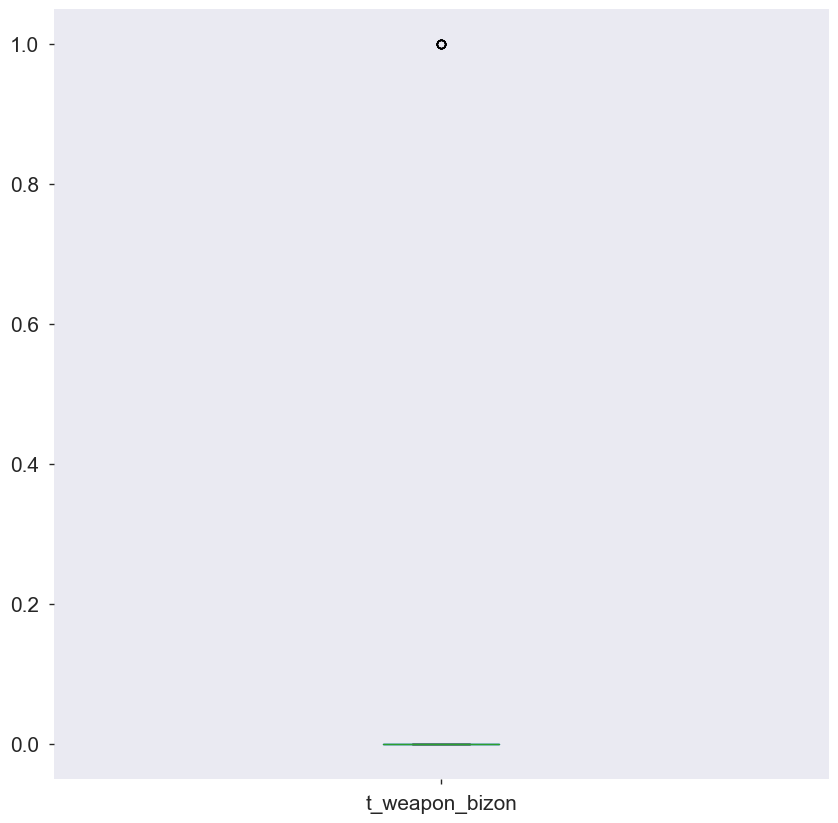

Analyzing outliers of column: ct_weapon_cz75auto


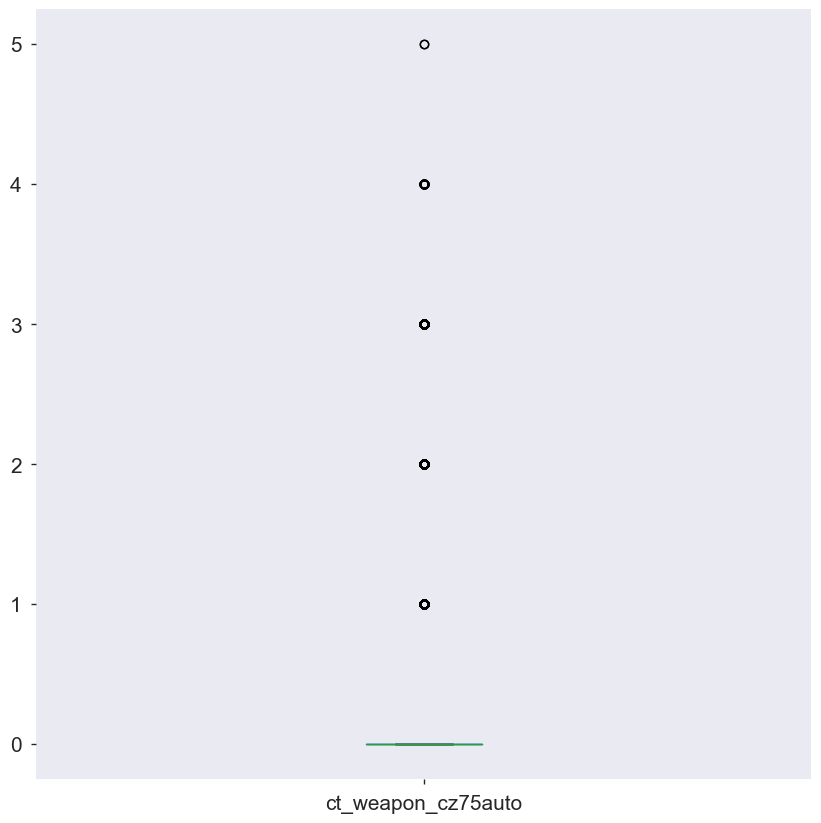

Analyzing outliers of column: t_weapon_cz75auto


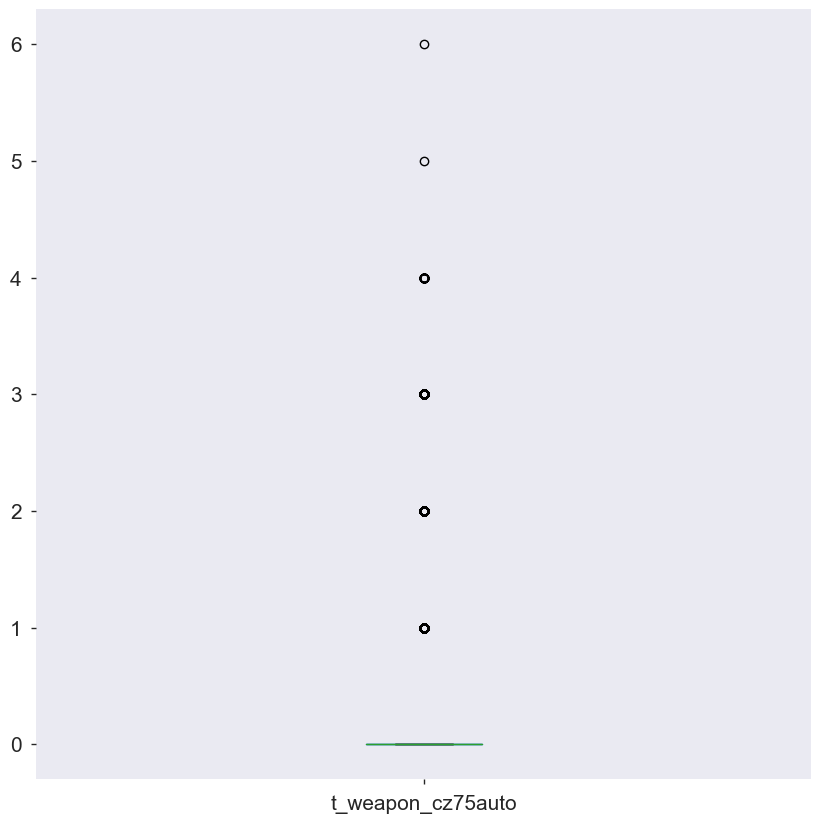

Analyzing outliers of column: ct_weapon_elite


Analyzing outliers of column: t_weapon_elite


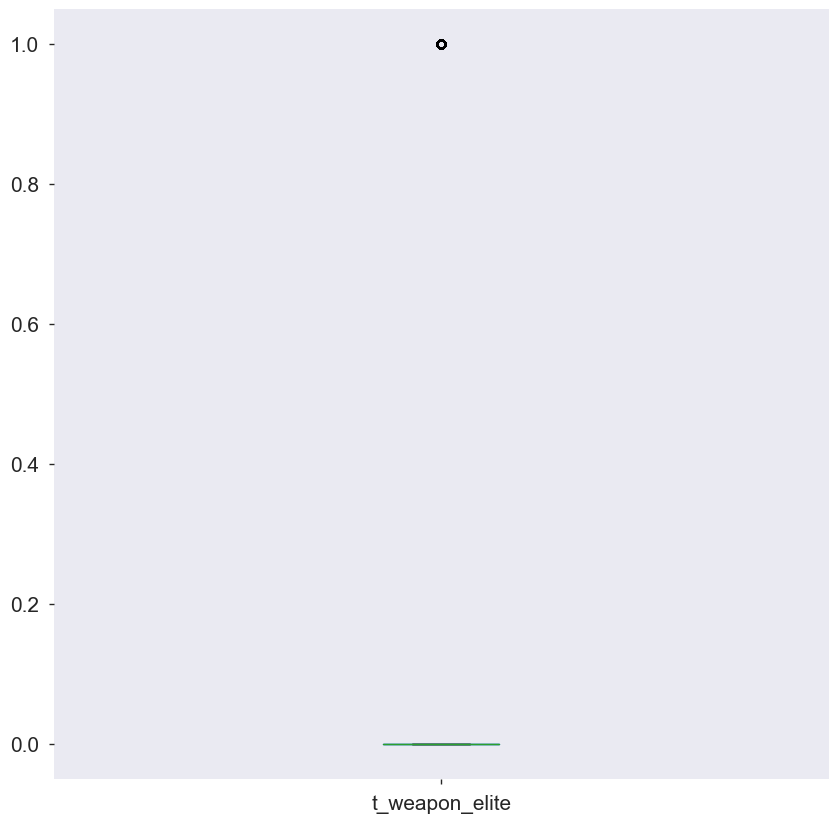

Analyzing outliers of column: ct_weapon_famas


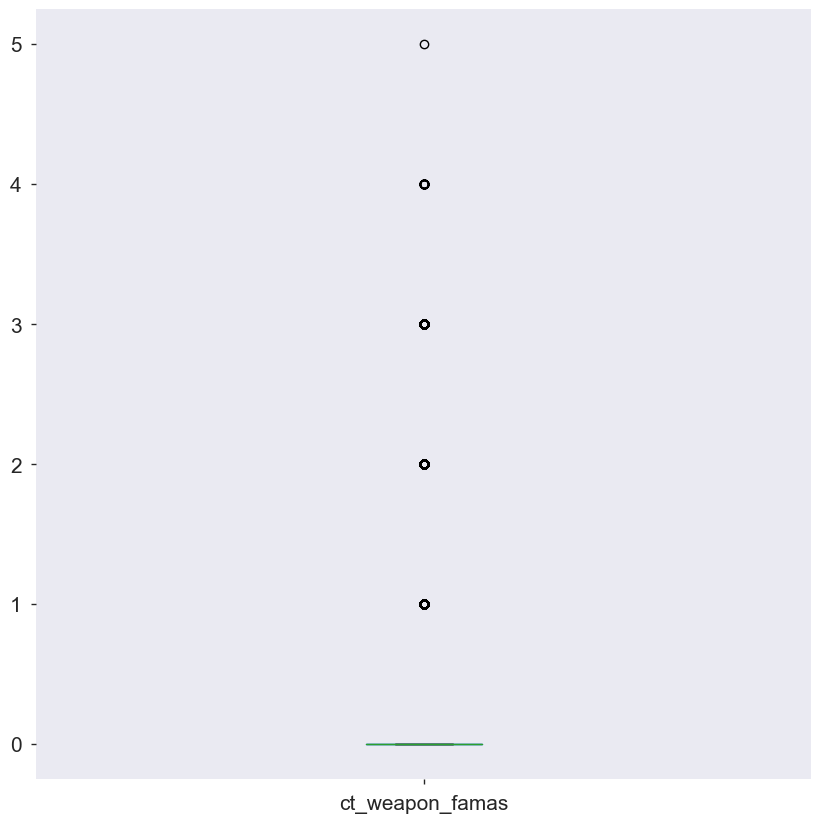

Analyzing outliers of column: t_weapon_famas


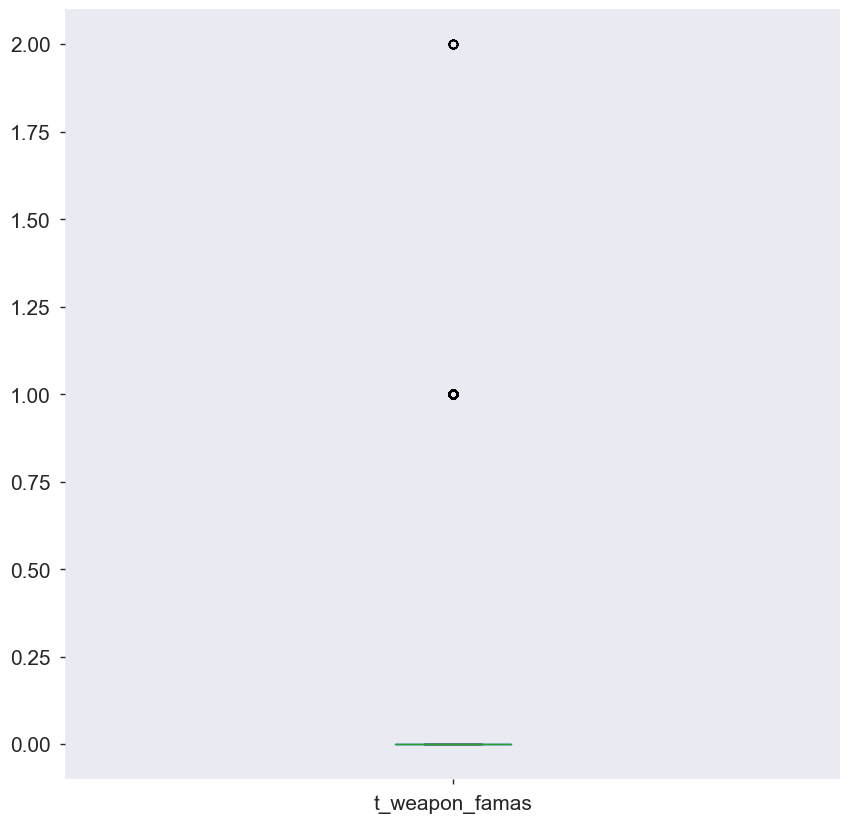

Analyzing outliers of column: ct_weapon_g3sg1


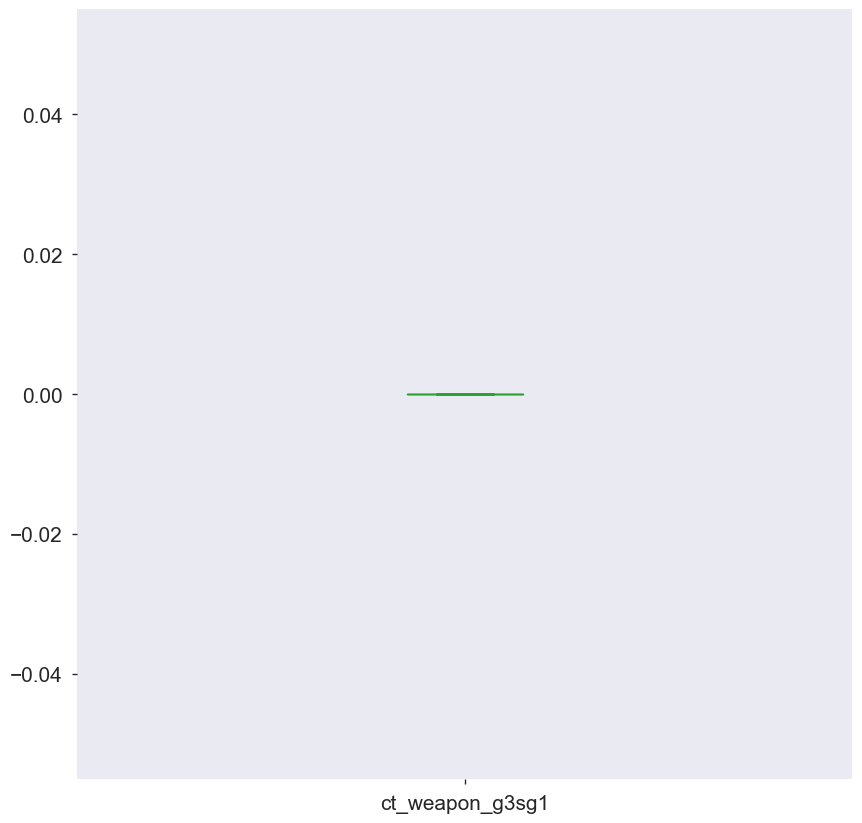

Analyzing outliers of column: t_weapon_g3sg1


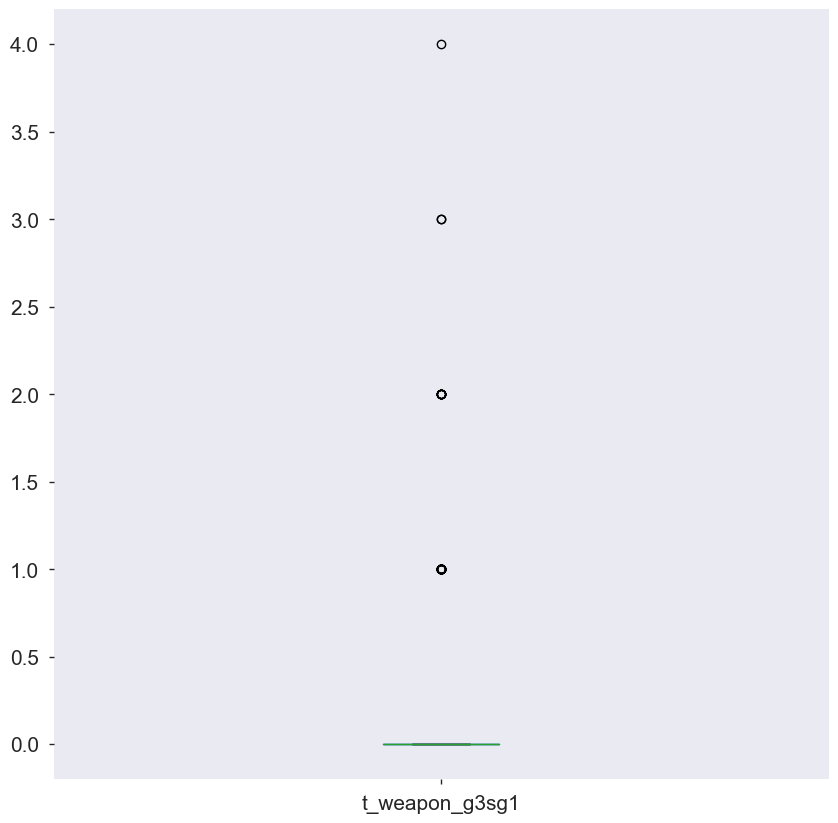

Analyzing outliers of column: ct_weapon_galilar


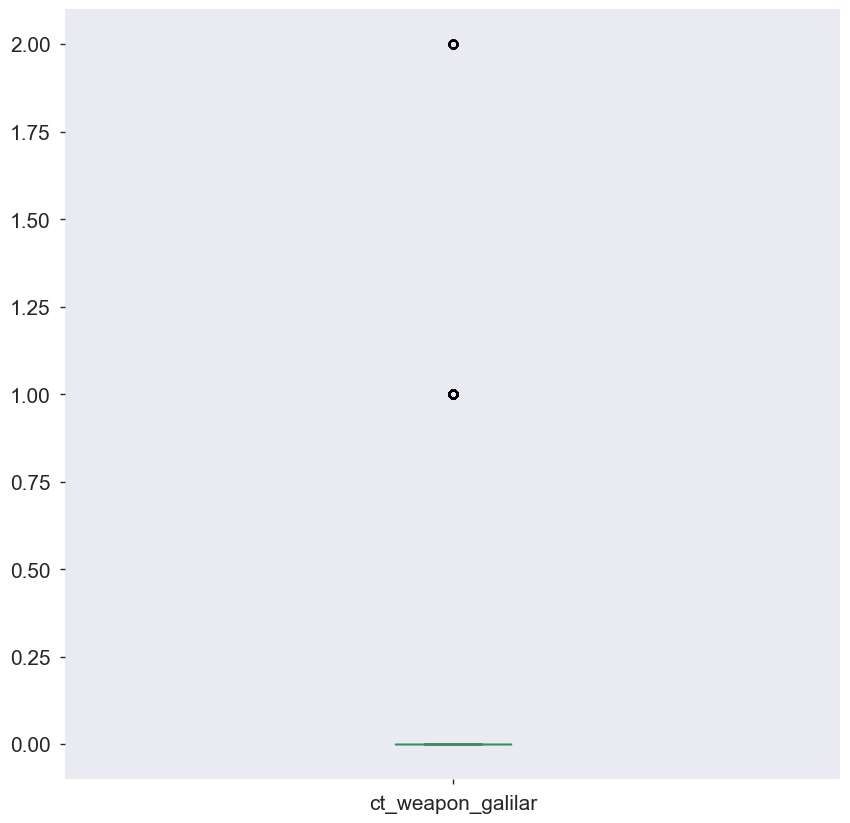

Analyzing outliers of column: t_weapon_galilar


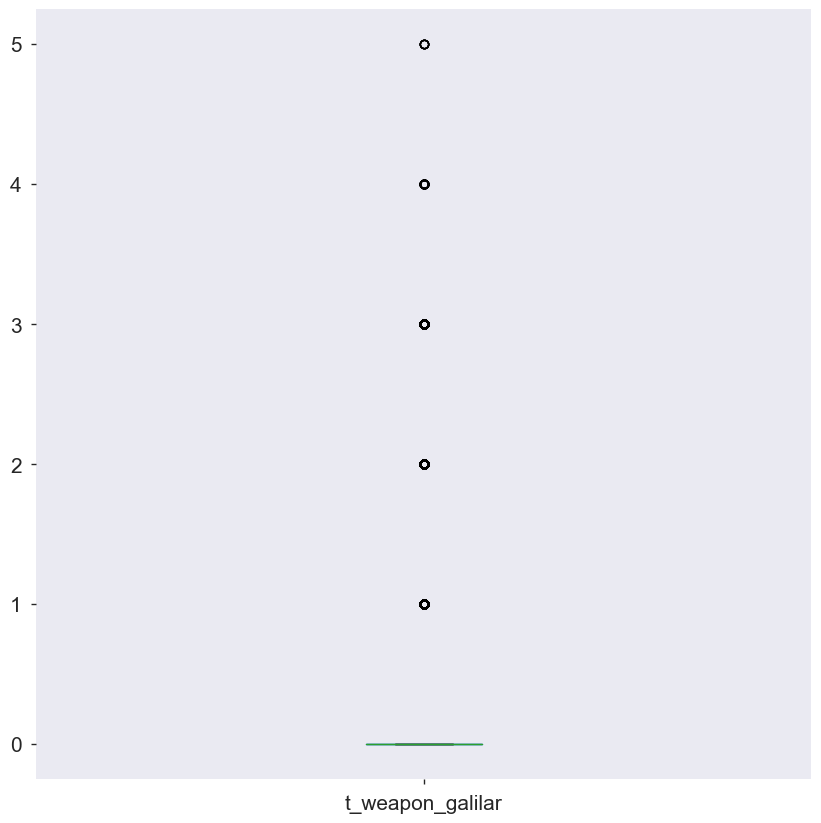

Analyzing outliers of column: ct_weapon_glock


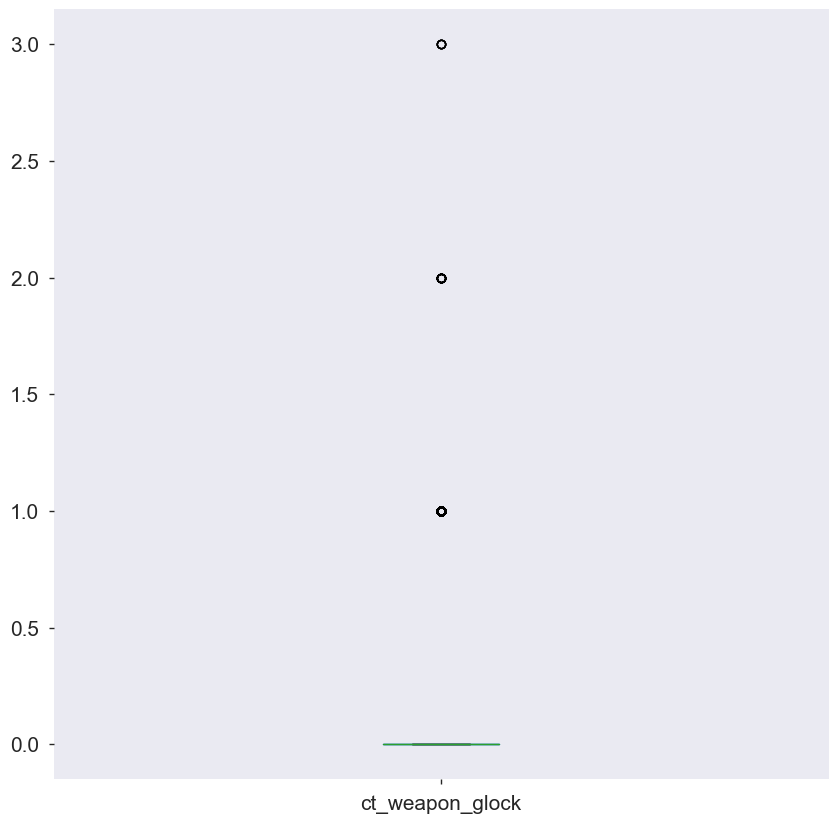

Analyzing outliers of column: t_weapon_glock


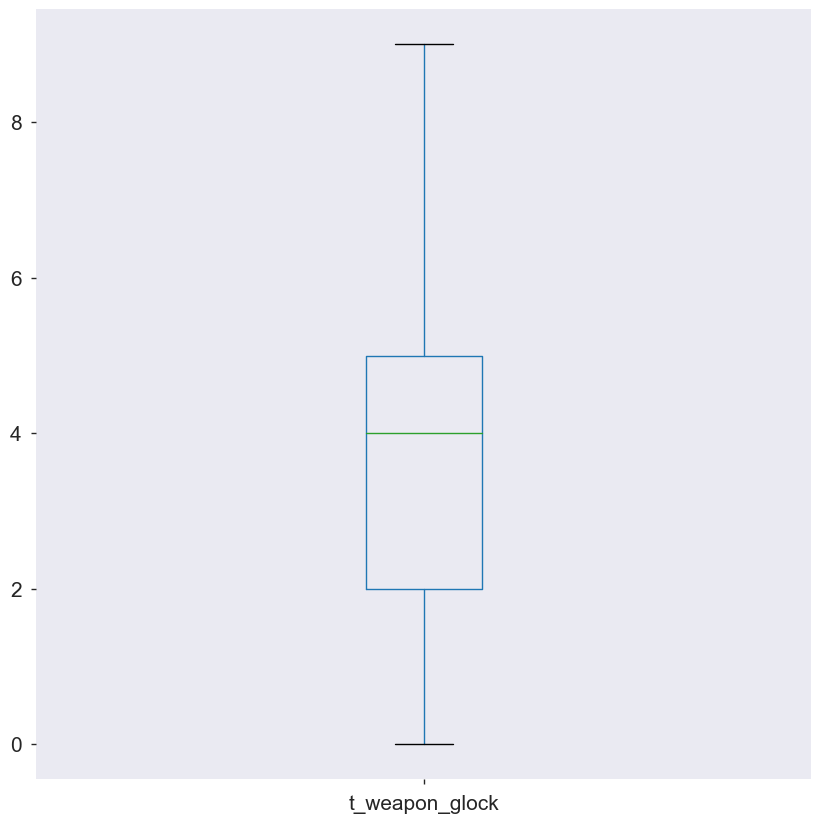

Analyzing outliers of column: ct_weapon_m249


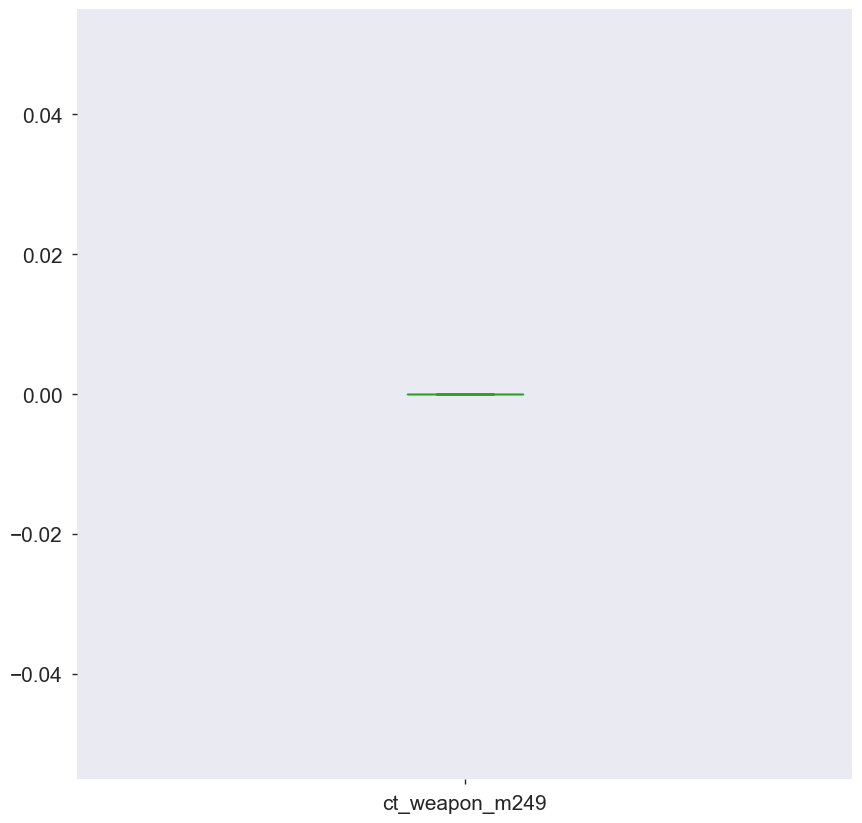

Analyzing outliers of column: t_weapon_m249


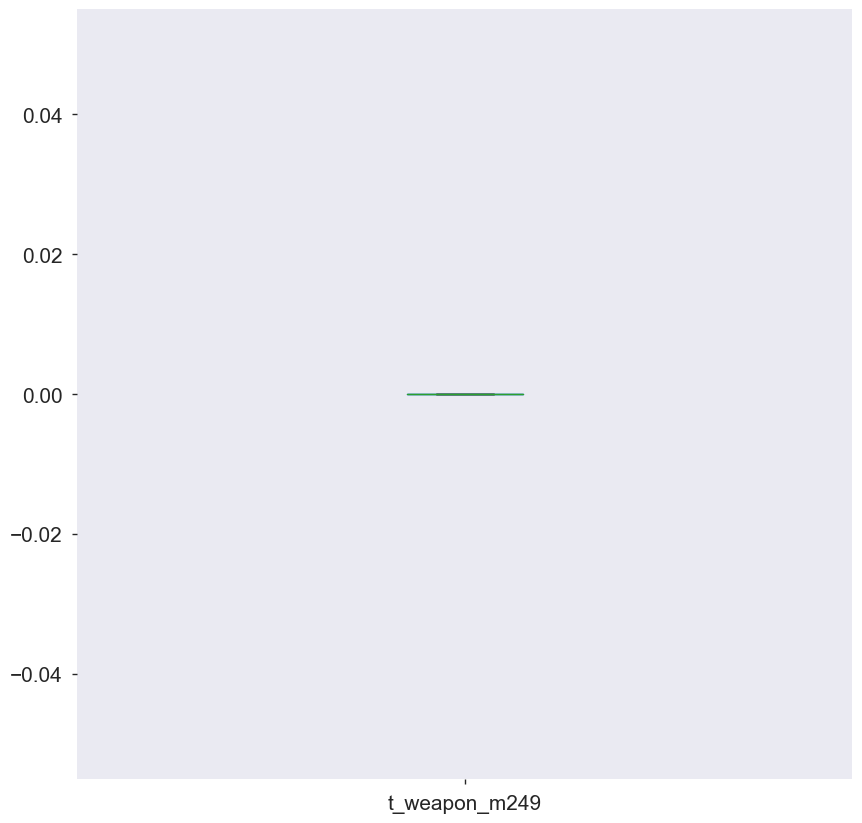

Analyzing outliers of column: ct_weapon_m4a1s


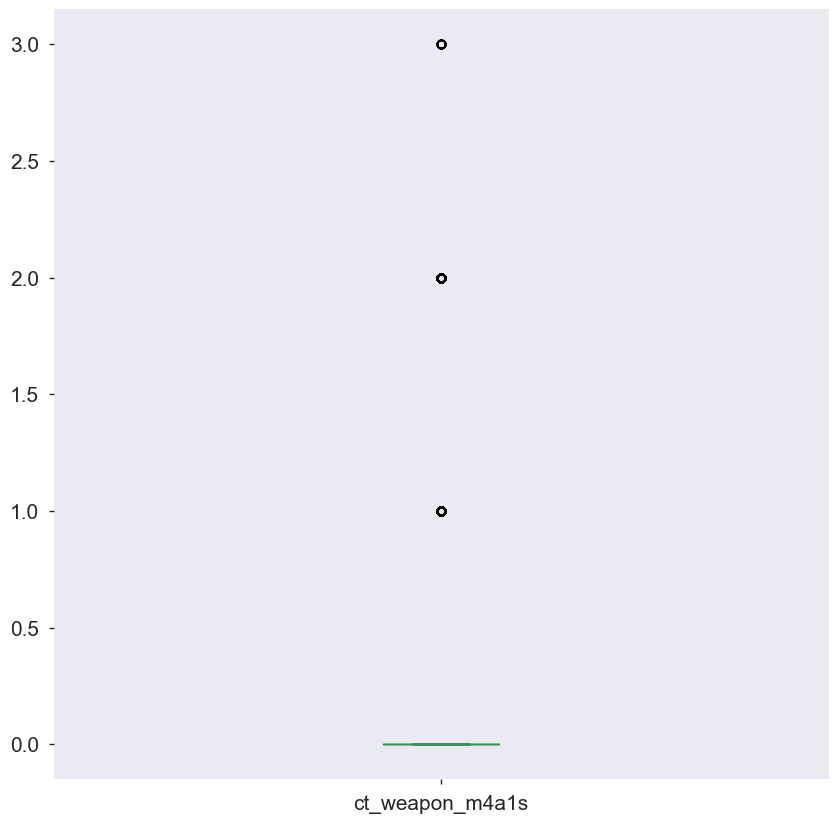

Analyzing outliers of column: t_weapon_m4a1s


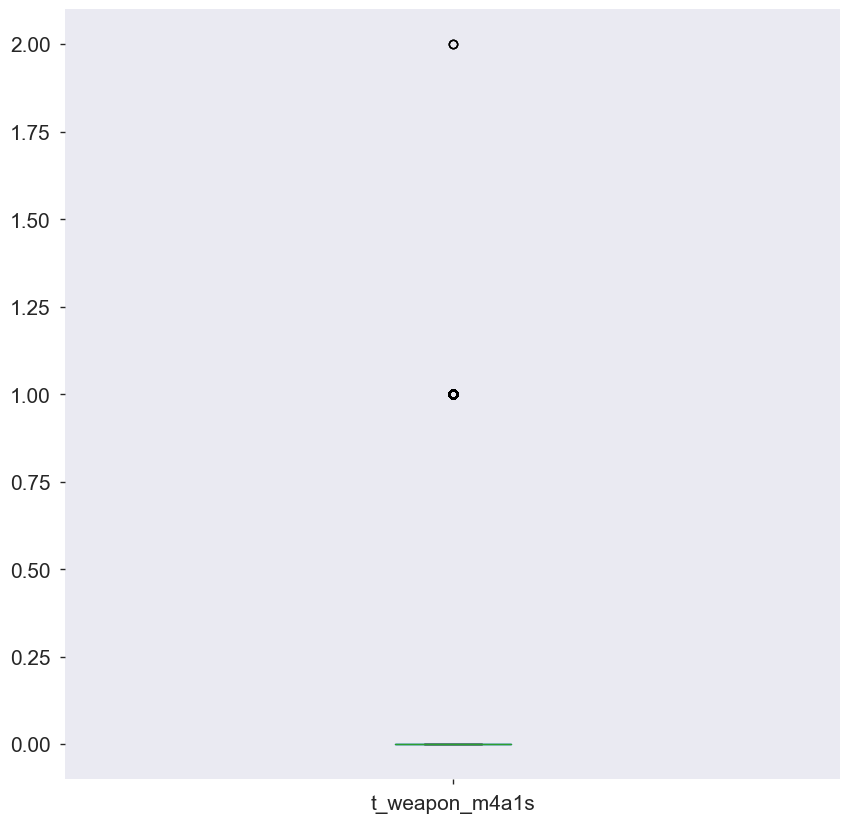

Analyzing outliers of column: ct_weapon_m4a4


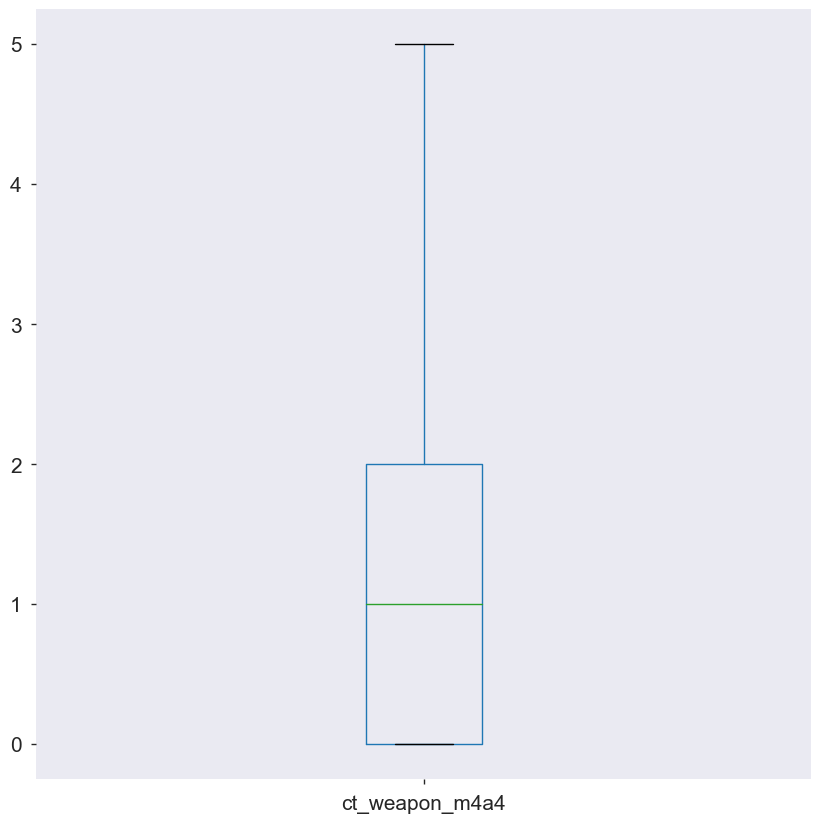

Analyzing outliers of column: t_weapon_m4a4


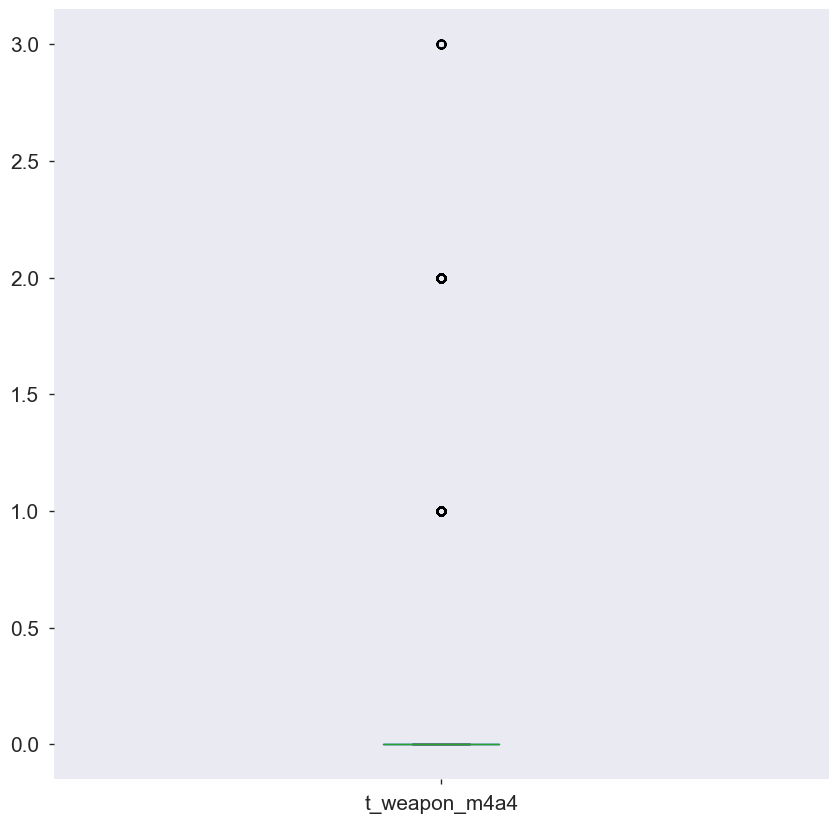

Analyzing outliers of column: ct_weapon_mac10


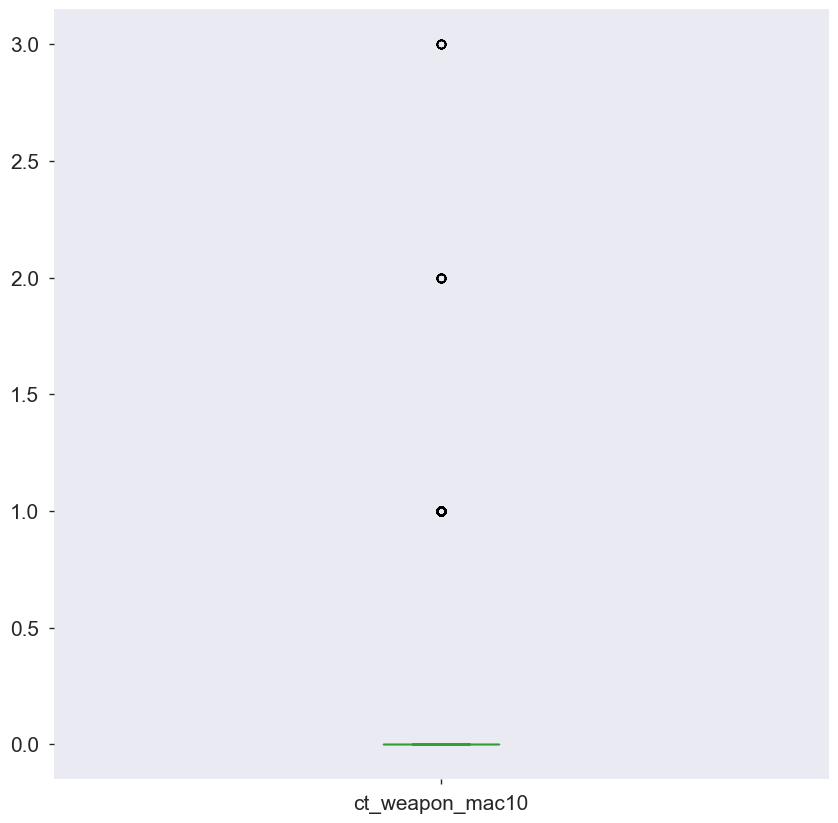

Analyzing outliers of column: t_weapon_mac10


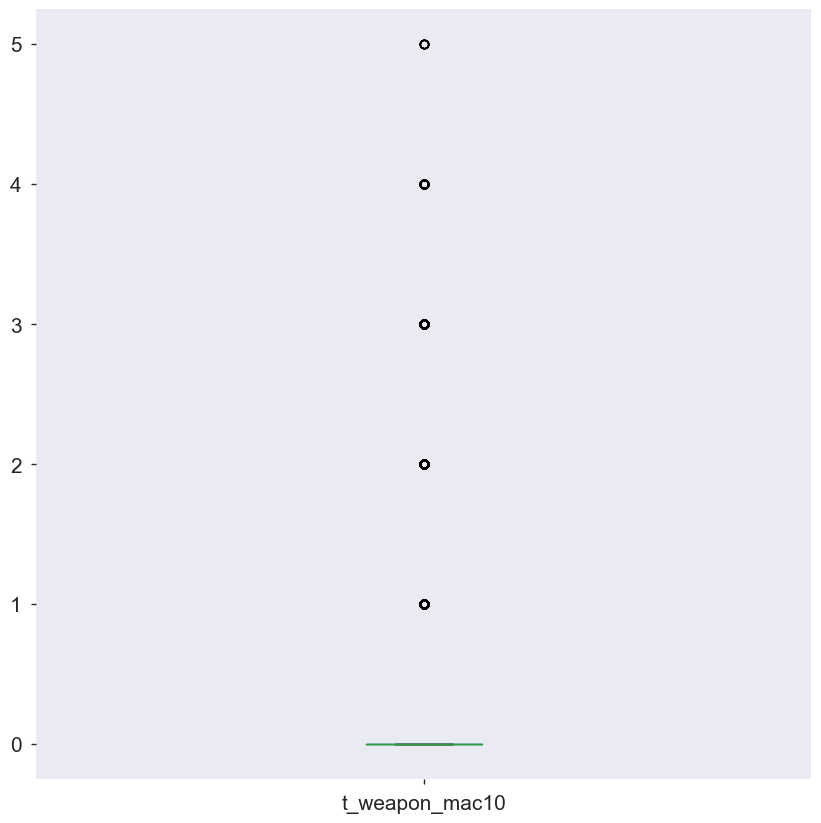

Analyzing outliers of column: ct_weapon_mag7


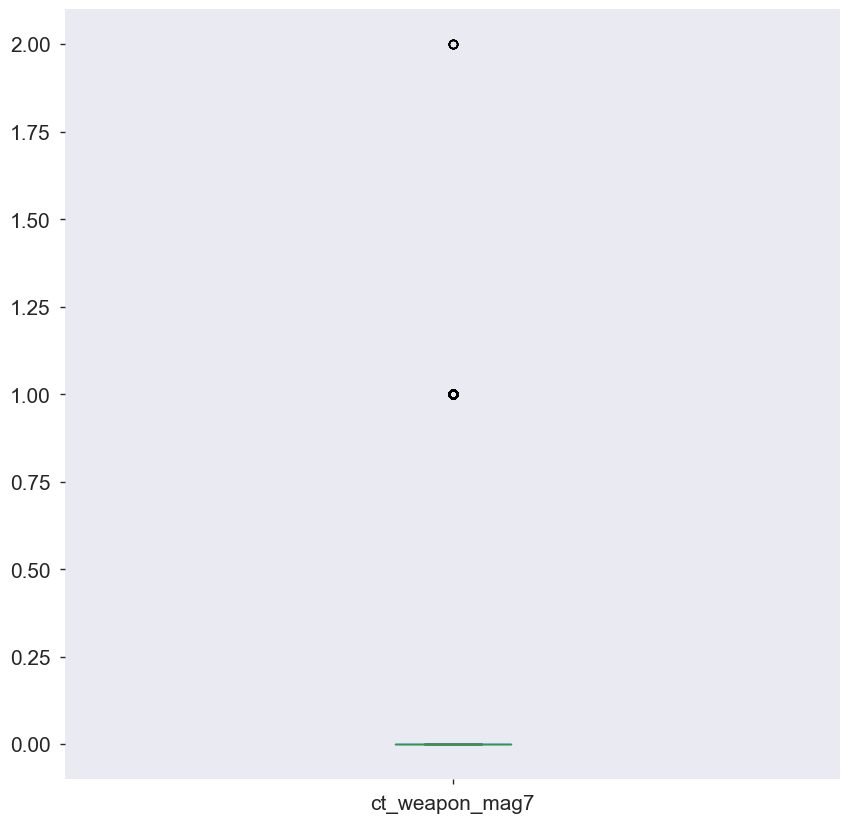

Analyzing outliers of column: t_weapon_mag7


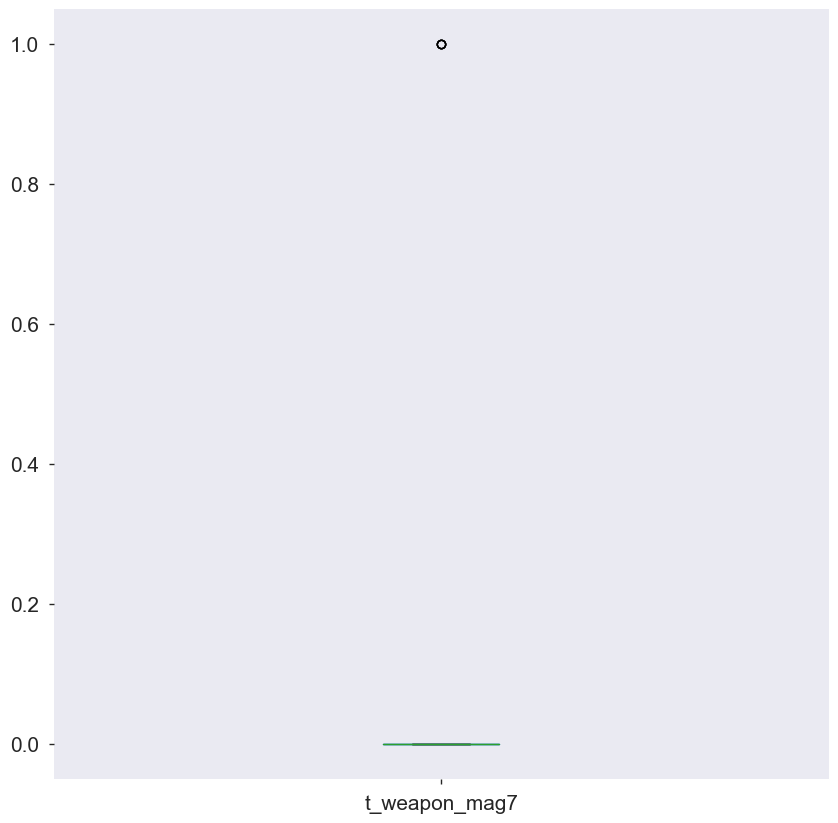

Analyzing outliers of column: ct_weapon_mp5sd


Analyzing outliers of column: t_weapon_mp5sd


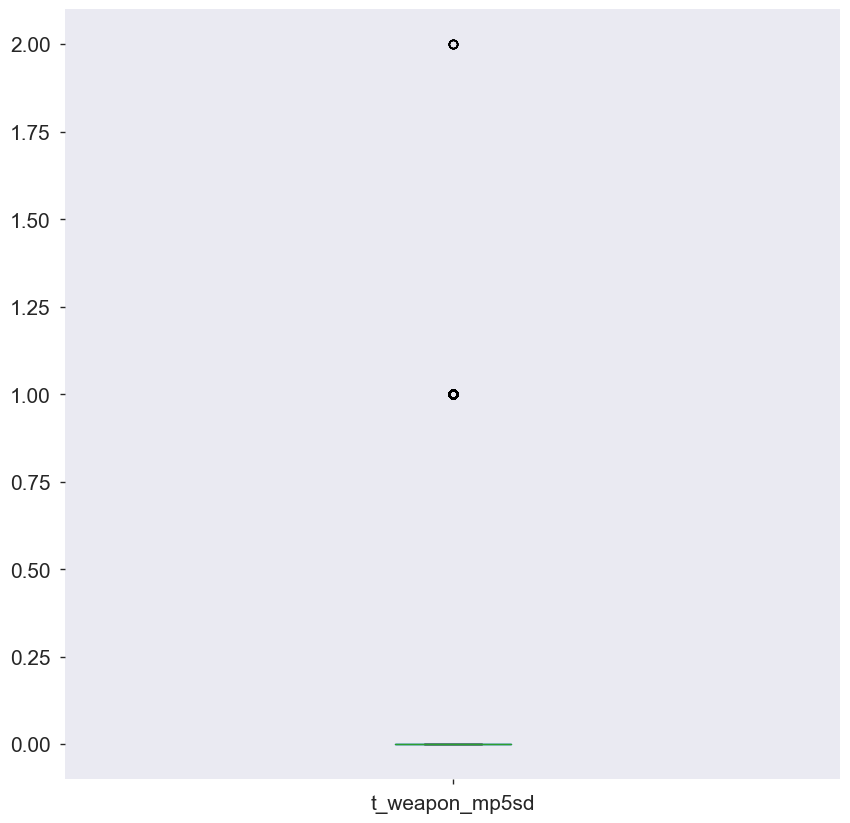

Analyzing outliers of column: ct_weapon_mp7


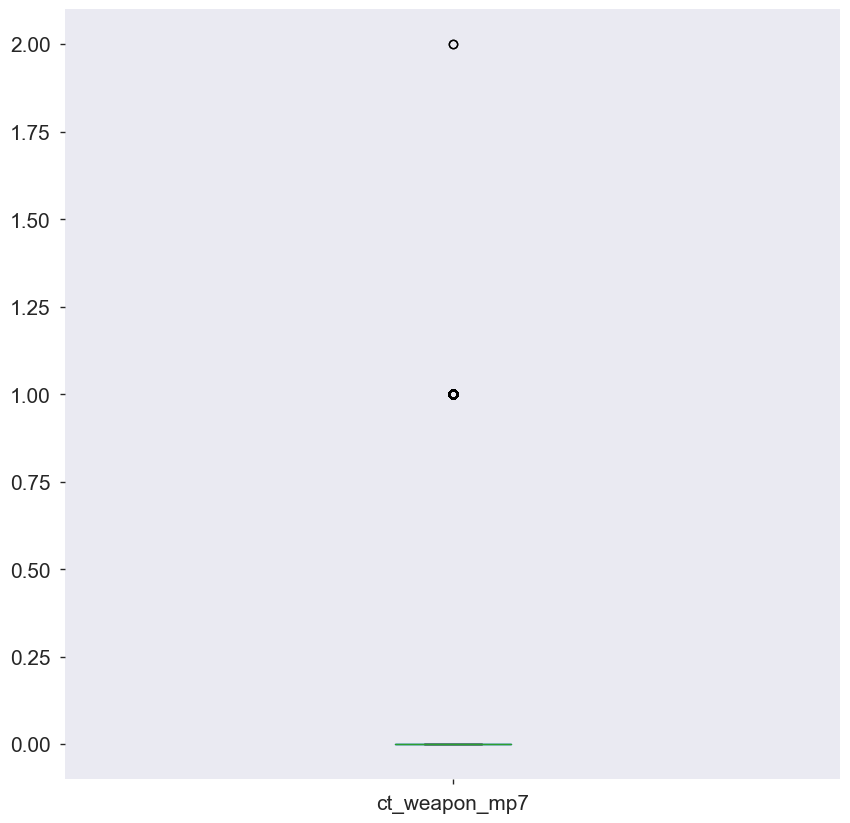

Analyzing outliers of column: t_weapon_mp7


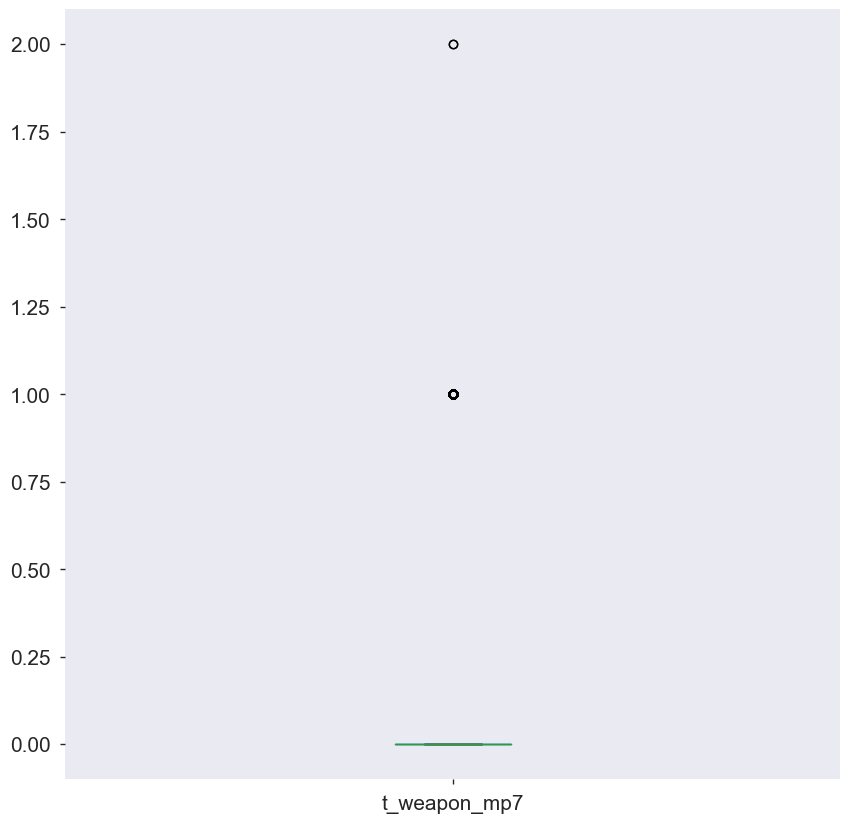

Analyzing outliers of column: ct_weapon_mp9


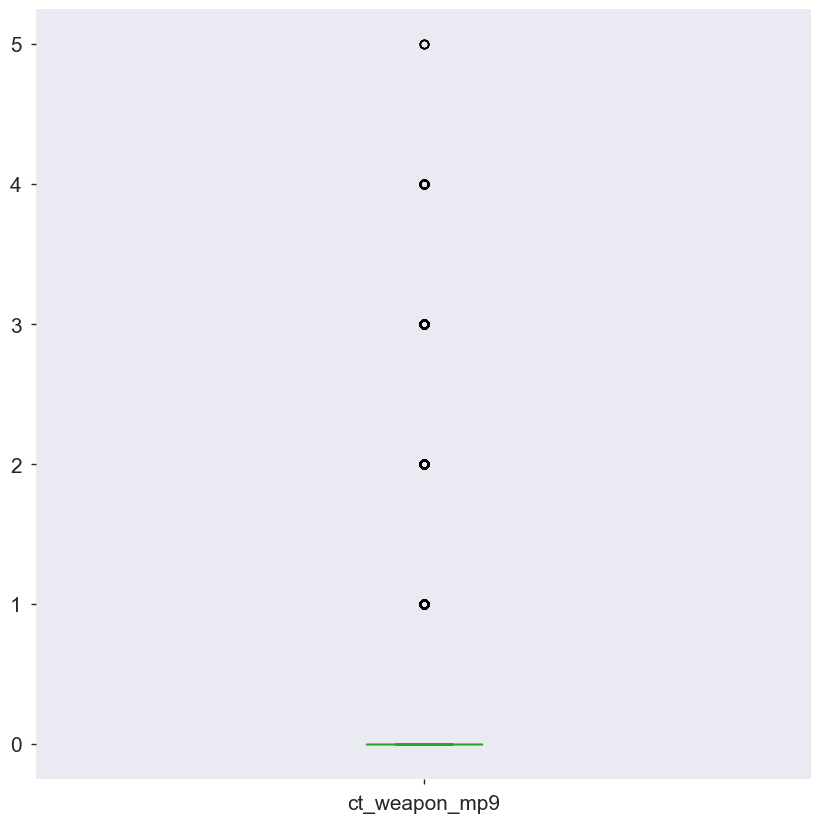

Analyzing outliers of column: t_weapon_mp9


Analyzing outliers of column: ct_weapon_negev


Analyzing outliers of column: t_weapon_negev


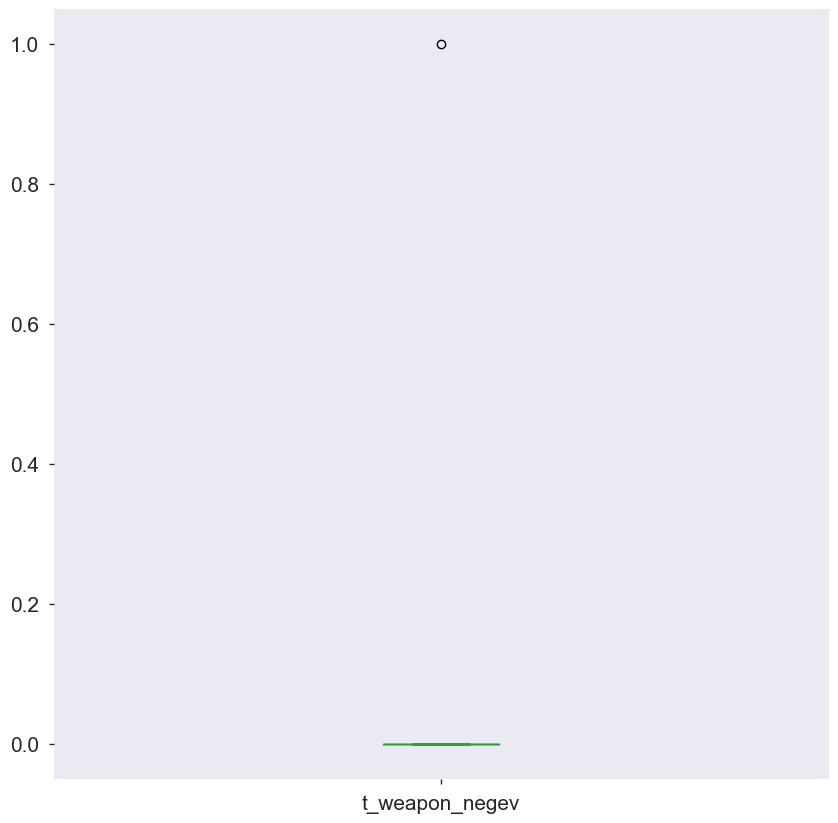

Analyzing outliers of column: ct_weapon_nova


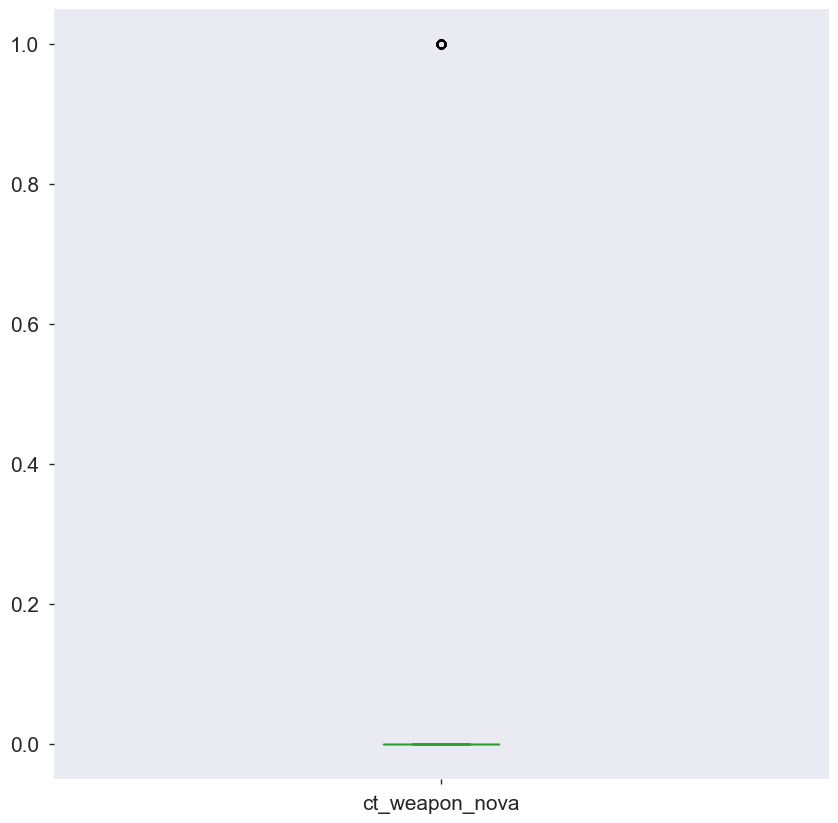

Analyzing outliers of column: t_weapon_nova


Analyzing outliers of column: ct_weapon_p90


Analyzing outliers of column: t_weapon_p90


Analyzing outliers of column: ct_weapon_r8revolver


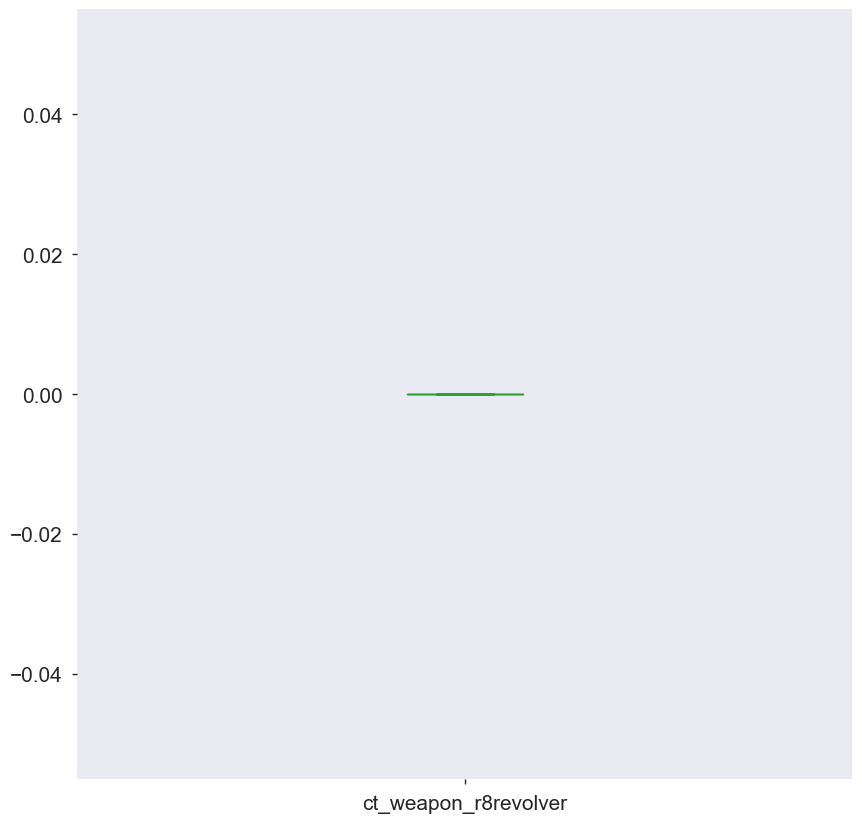

Analyzing outliers of column: t_weapon_r8revolver


Analyzing outliers of column: ct_weapon_sawedoff


Analyzing outliers of column: t_weapon_sawedoff


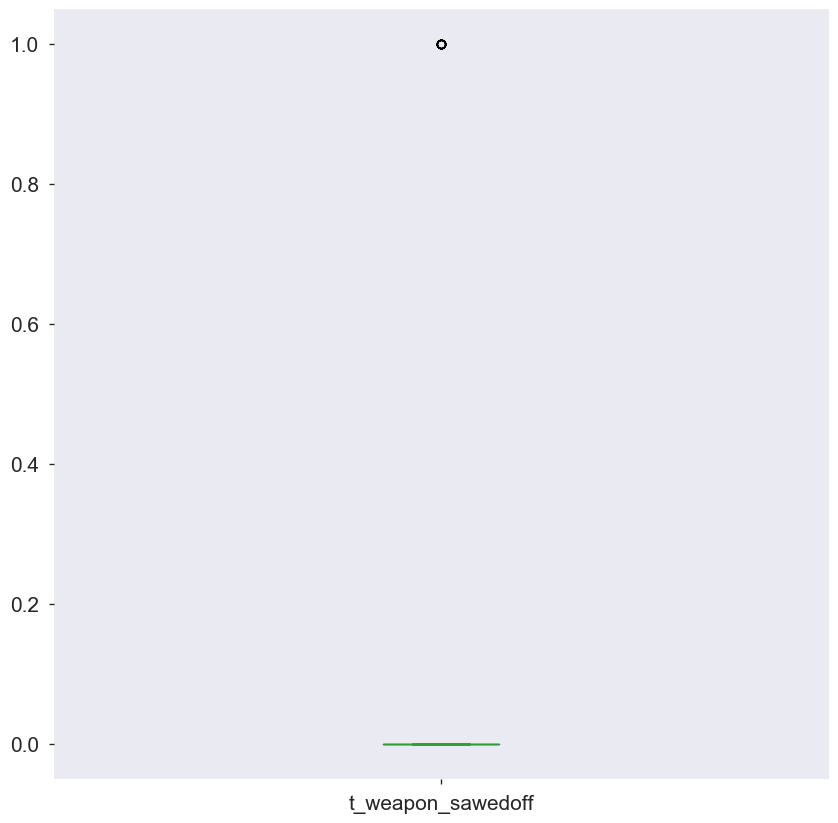

Analyzing outliers of column: ct_weapon_scar20


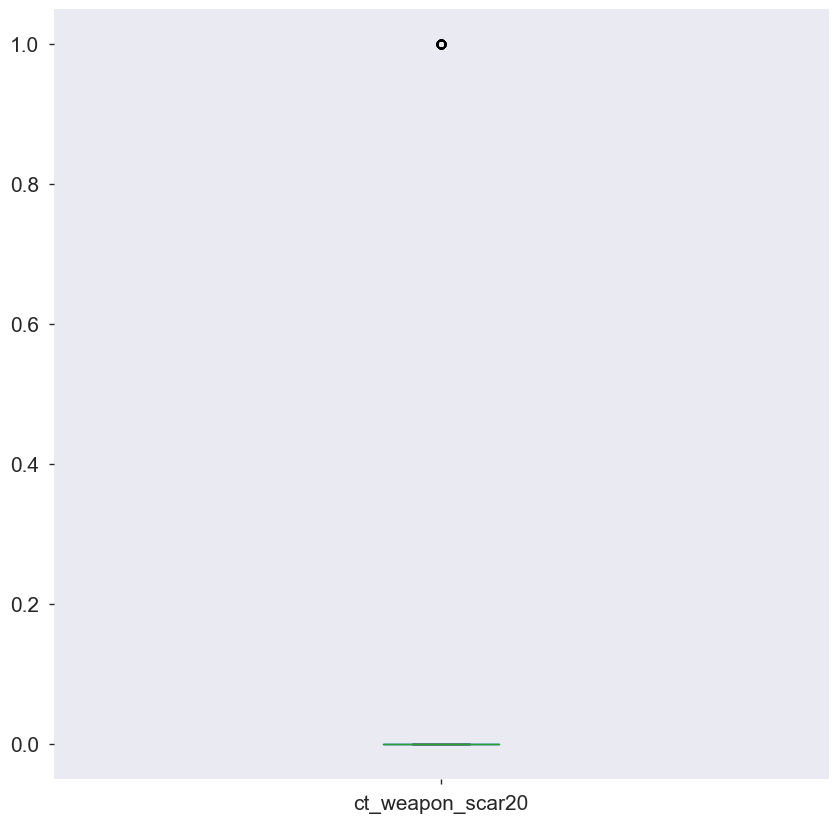

Analyzing outliers of column: t_weapon_scar20


Analyzing outliers of column: ct_weapon_sg553


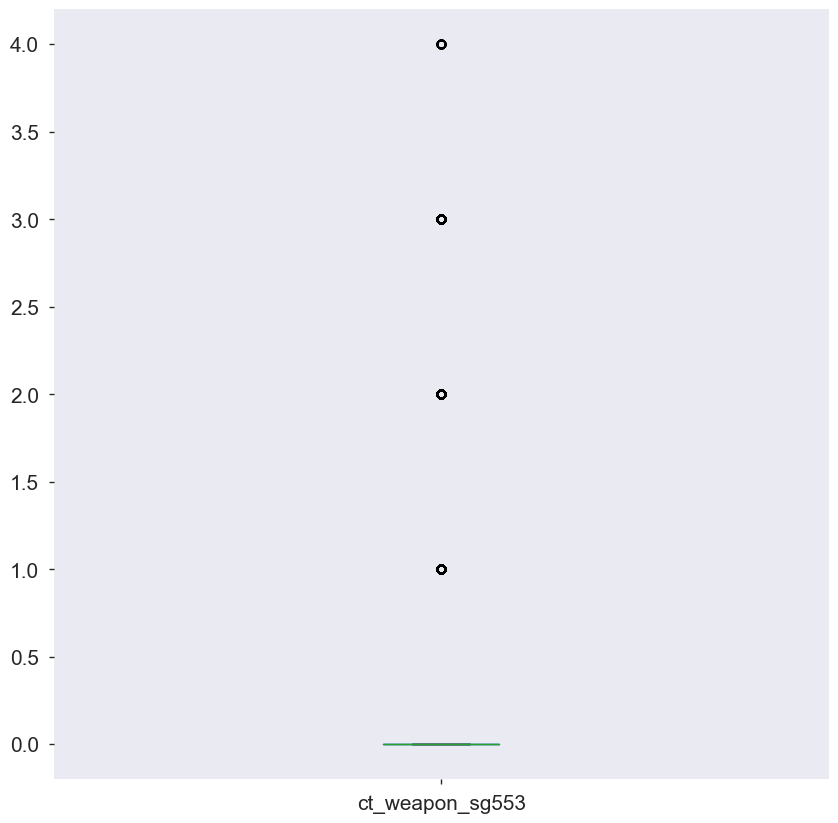

Analyzing outliers of column: t_weapon_sg553


Analyzing outliers of column: ct_weapon_ssg08


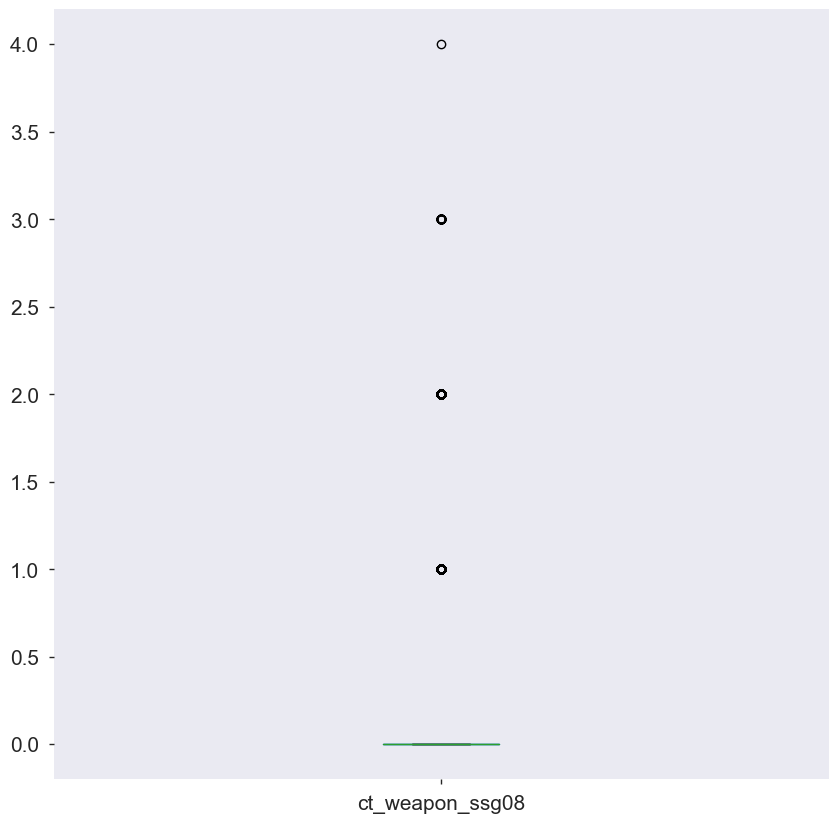

Analyzing outliers of column: t_weapon_ssg08


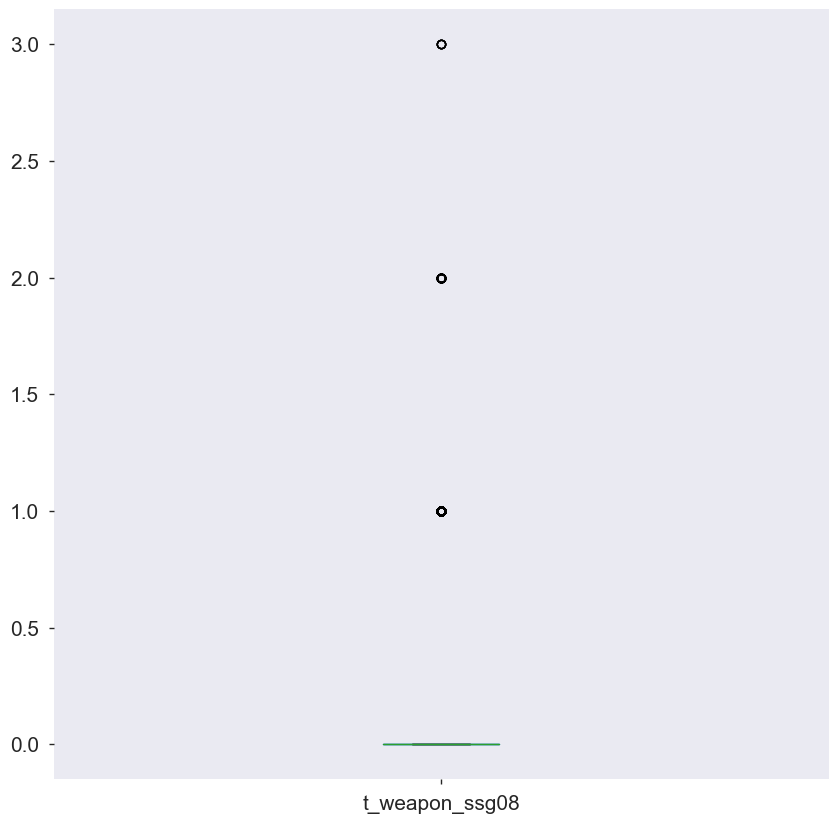

Analyzing outliers of column: ct_weapon_ump45


Analyzing outliers of column: t_weapon_ump45


Analyzing outliers of column: ct_weapon_xm1014


Analyzing outliers of column: t_weapon_xm1014


Analyzing outliers of column: ct_weapon_deagle


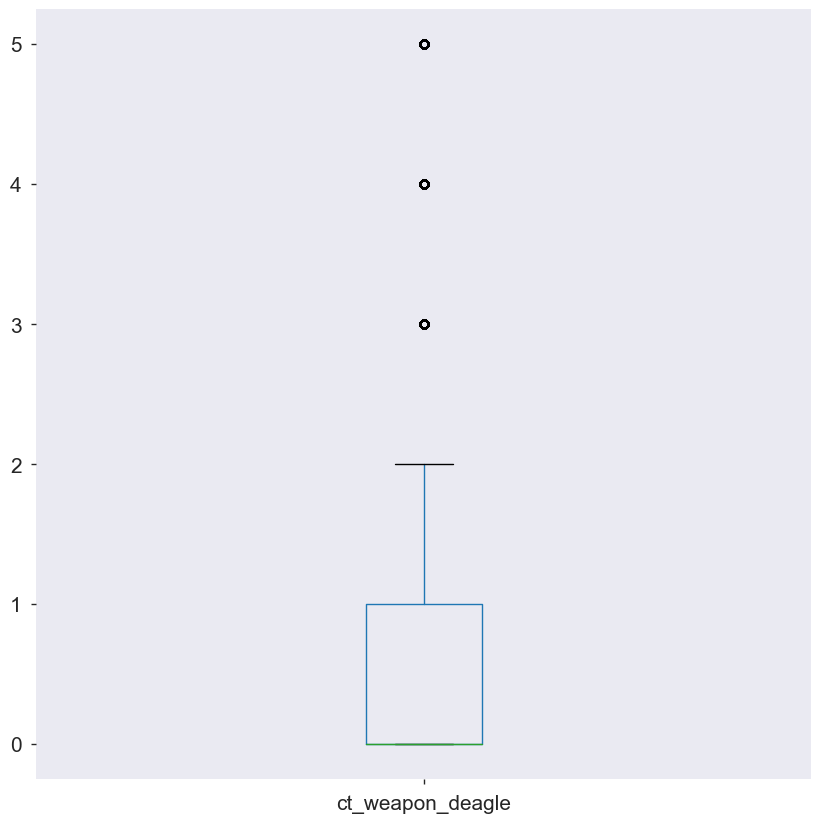

Analyzing outliers of column: t_weapon_deagle


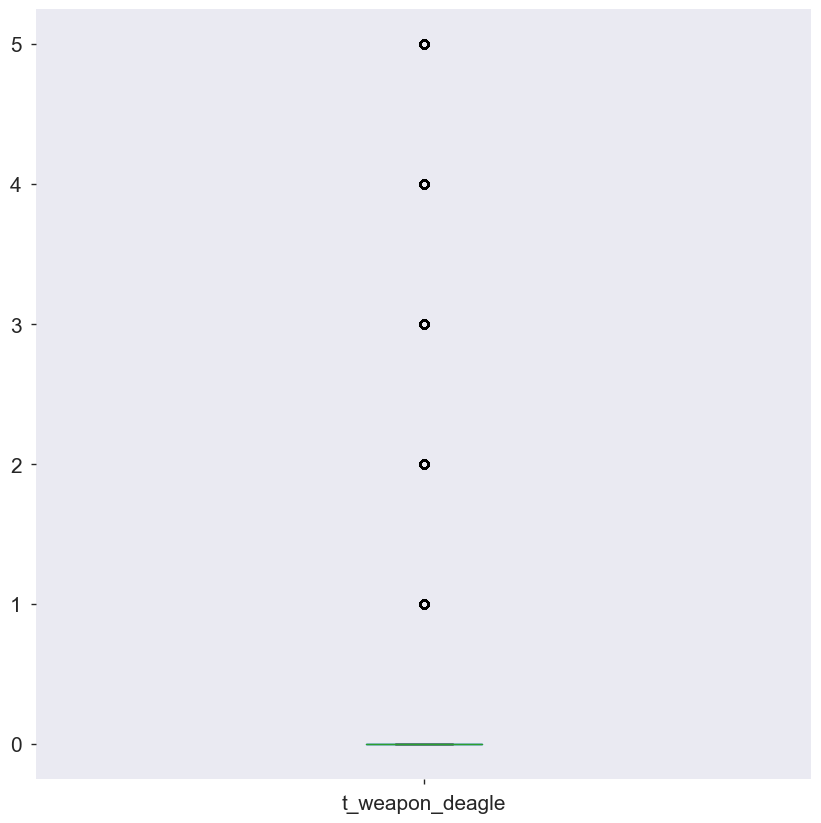

Analyzing outliers of column: ct_weapon_fiveseven


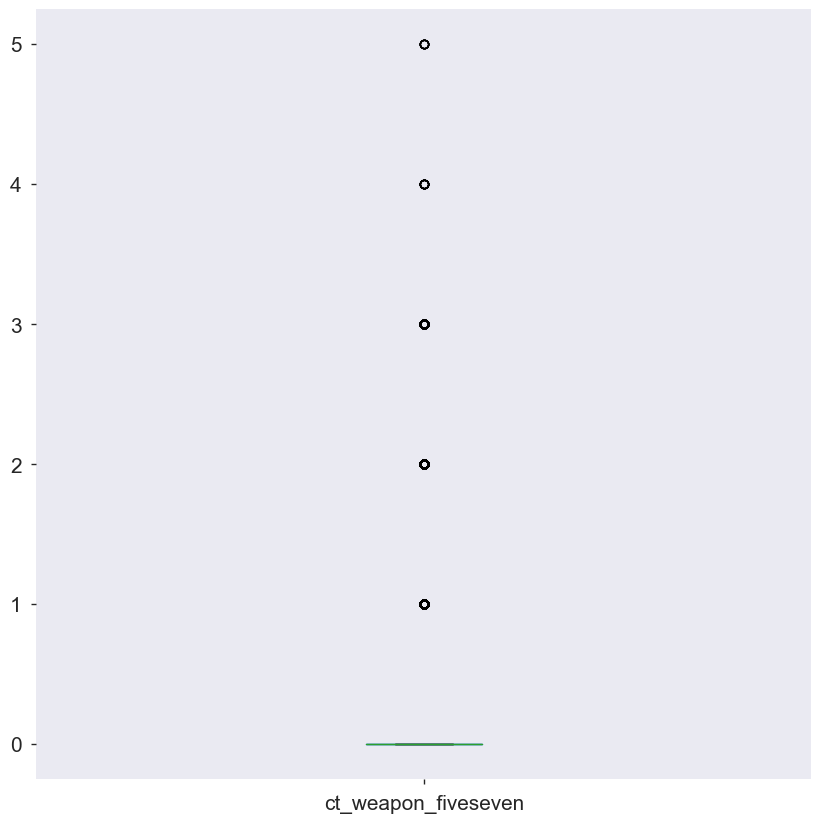

Analyzing outliers of column: t_weapon_fiveseven


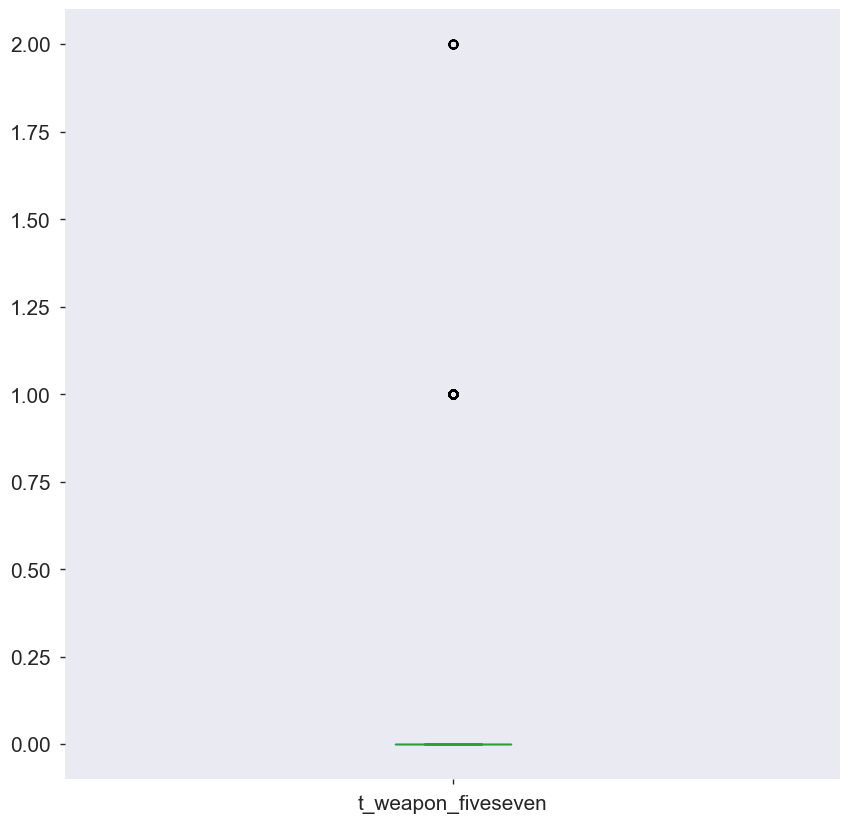

Analyzing outliers of column: ct_weapon_usps


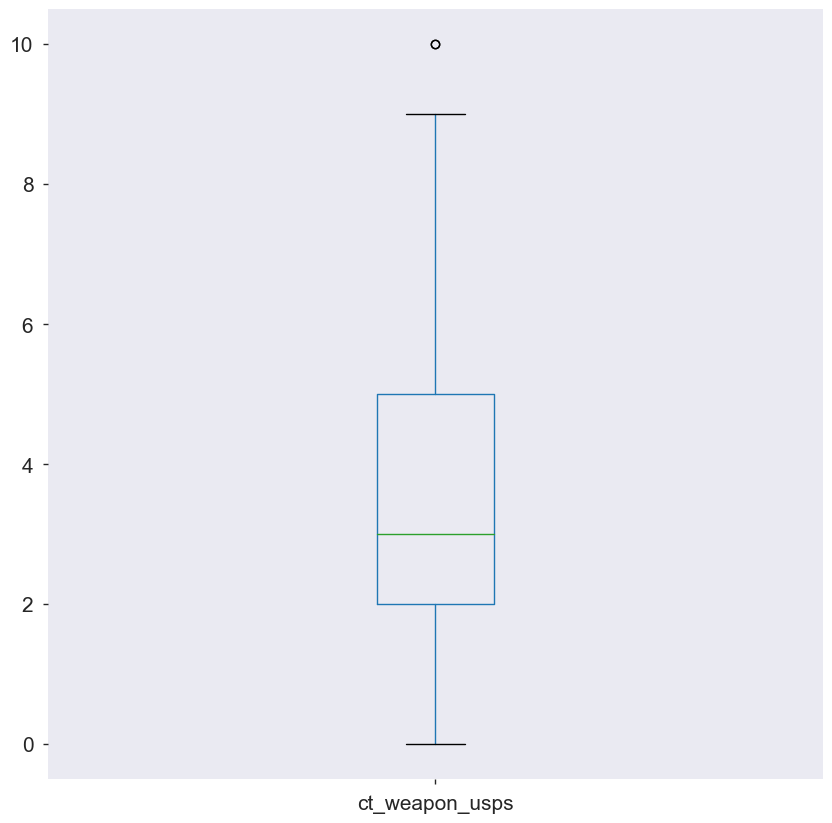

Analyzing outliers of column: t_weapon_usps


Analyzing outliers of column: ct_weapon_p250


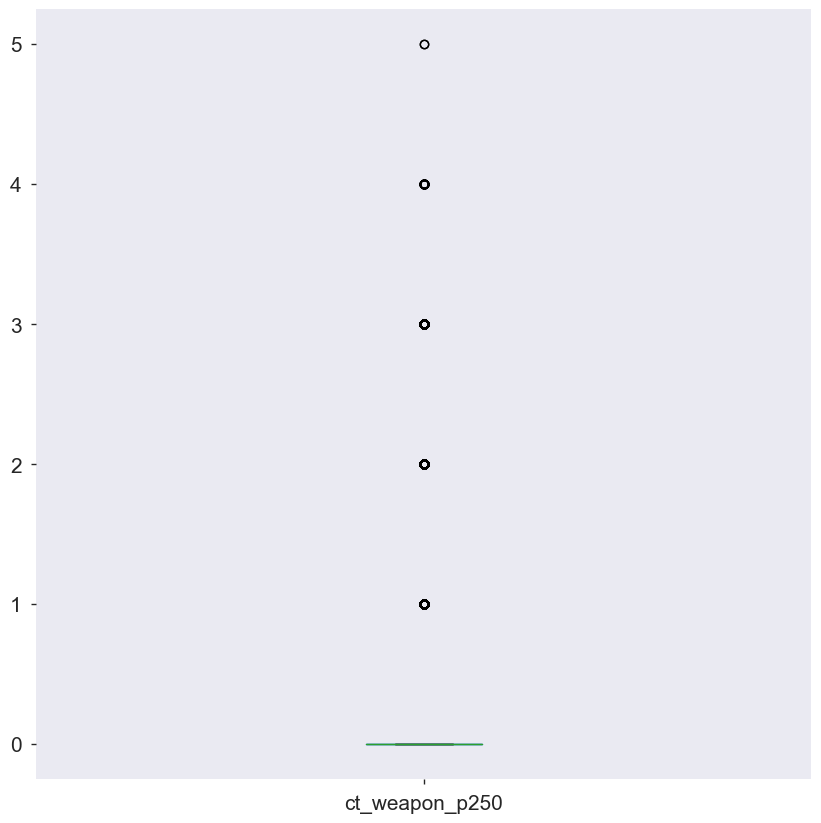

Analyzing outliers of column: t_weapon_p250


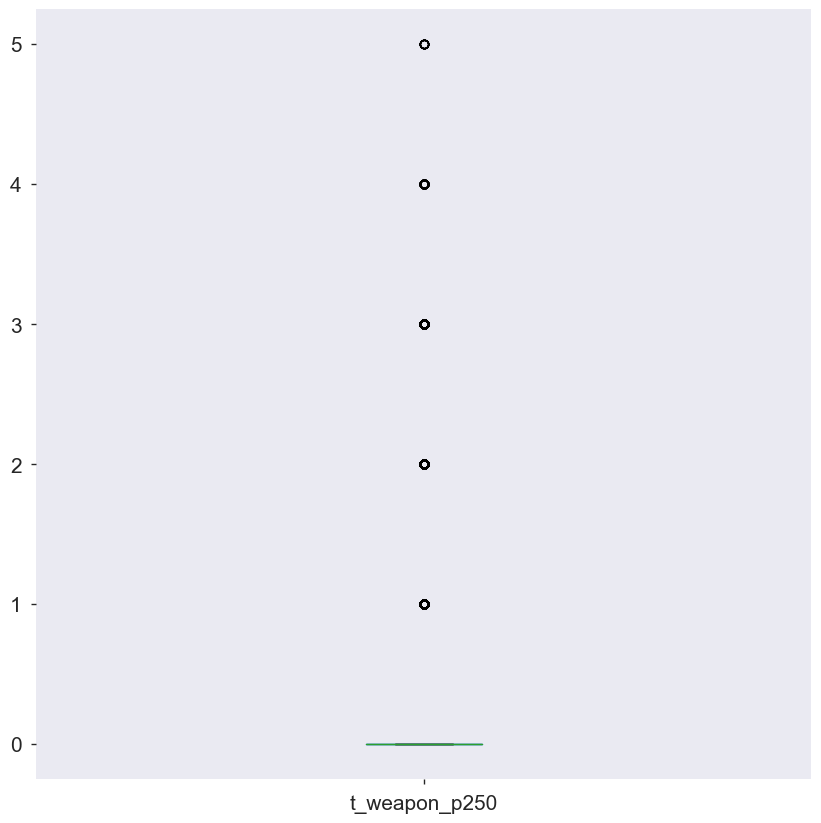

Analyzing outliers of column: ct_weapon_p2000


Analyzing outliers of column: t_weapon_p2000


Analyzing outliers of column: ct_weapon_tec9


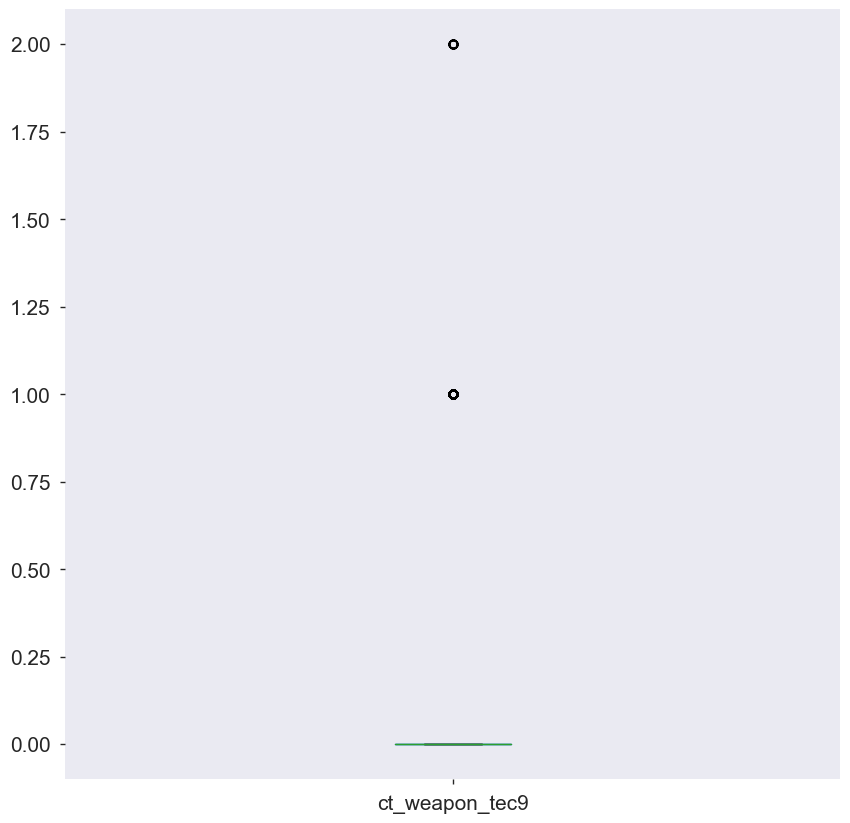

Analyzing outliers of column: t_weapon_tec9


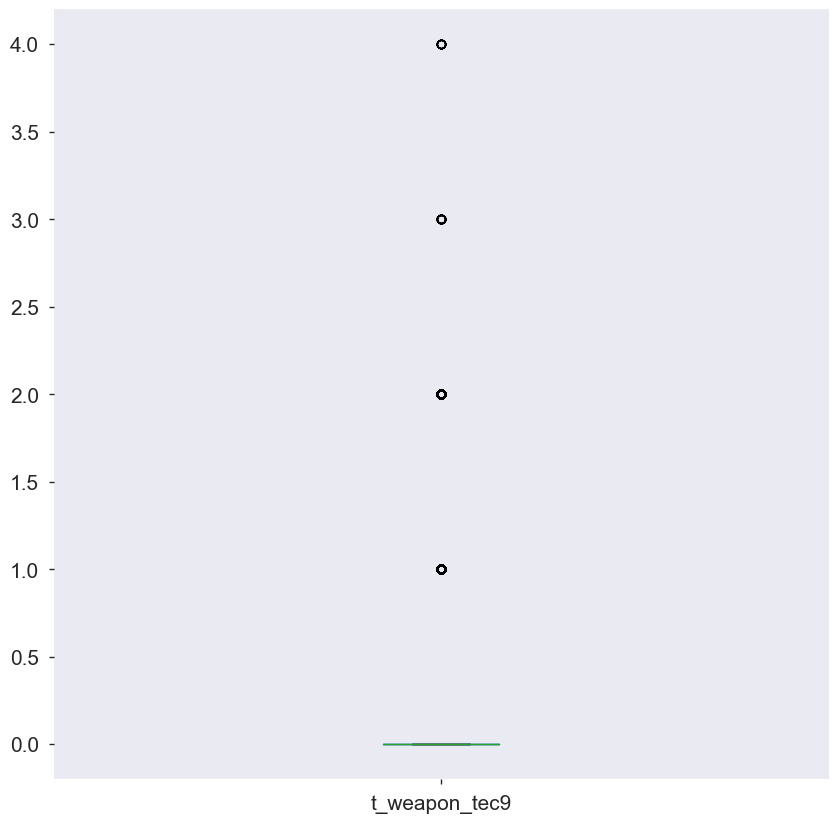

Analyzing outliers of column: ct_grenade_hegrenade


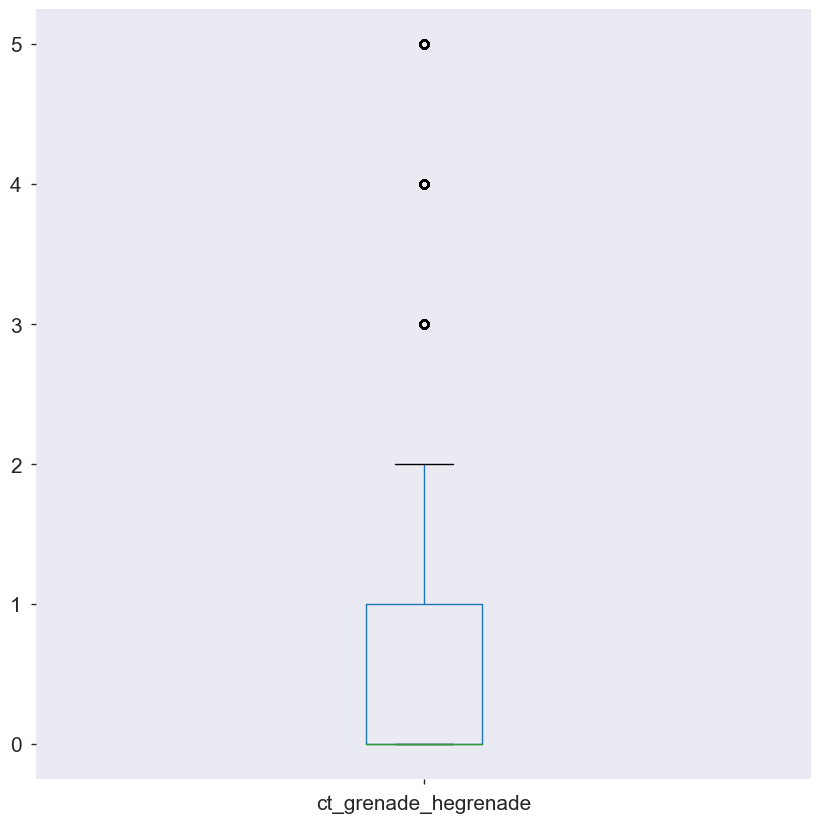

Analyzing outliers of column: t_grenade_hegrenade


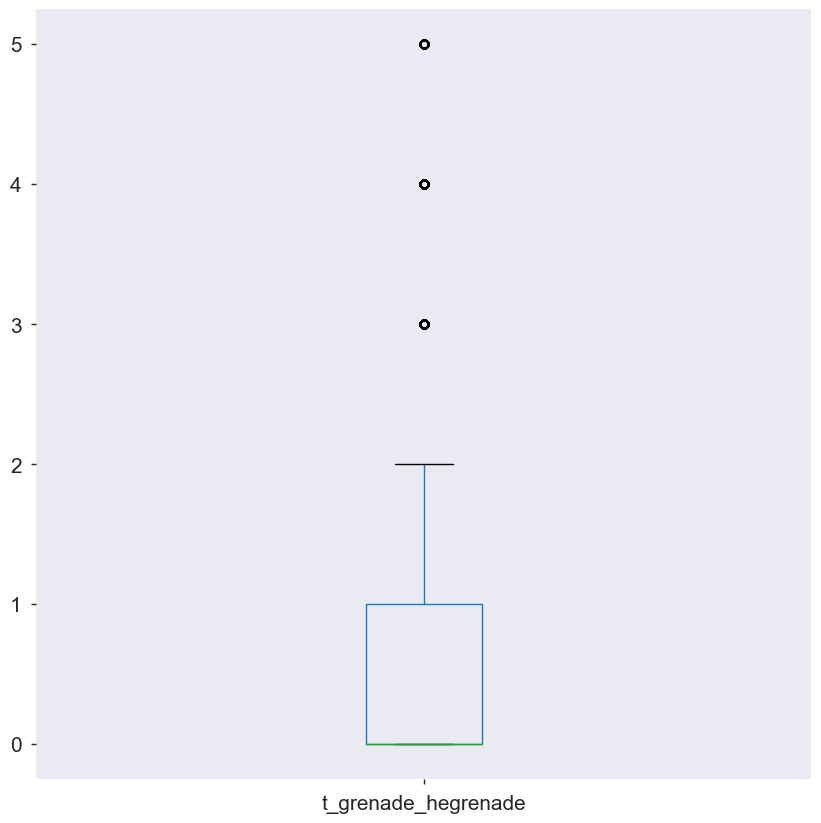

Analyzing outliers of column: ct_grenade_flashbang


Analyzing outliers of column: t_grenade_flashbang


Analyzing outliers of column: ct_grenade_smokegrenade


Analyzing outliers of column: t_grenade_smokegrenade


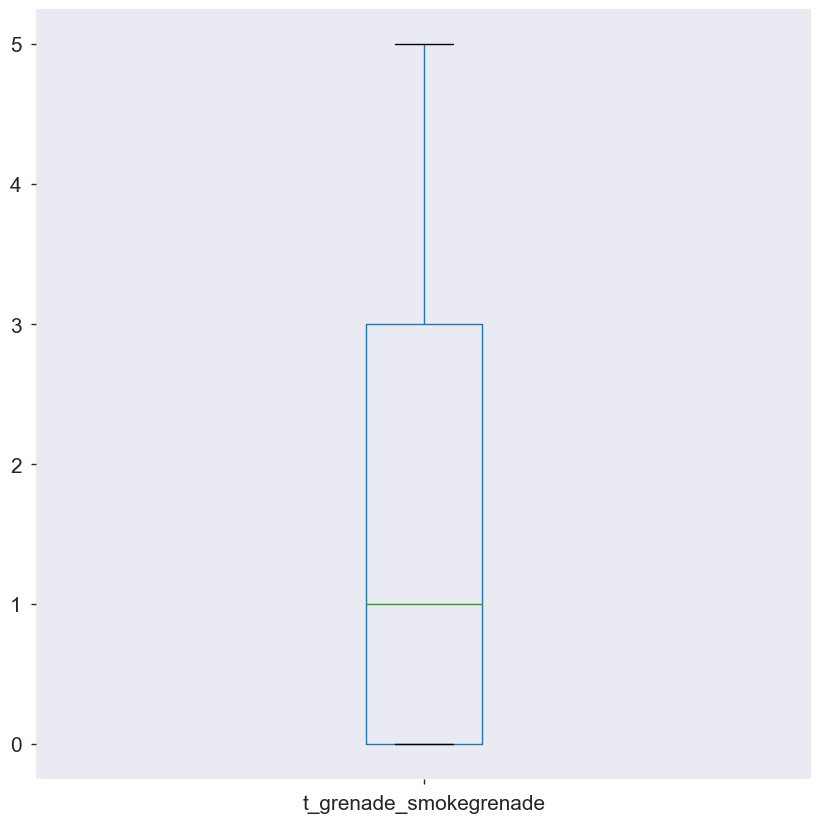

Analyzing outliers of column: ct_grenade_incendiarygrenade


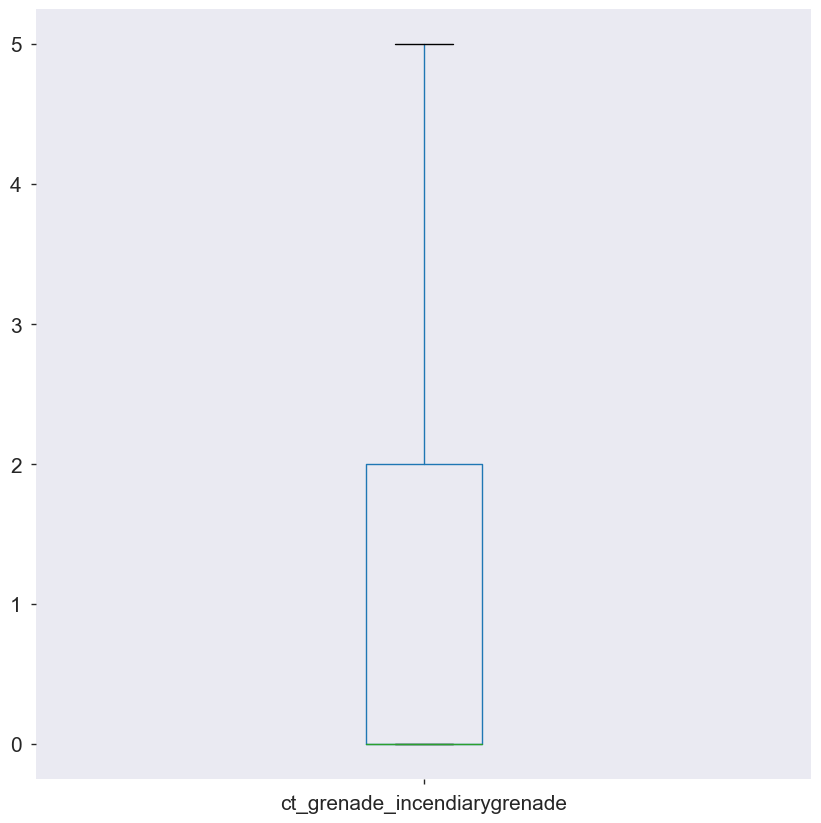

Analyzing outliers of column: t_grenade_incendiarygrenade


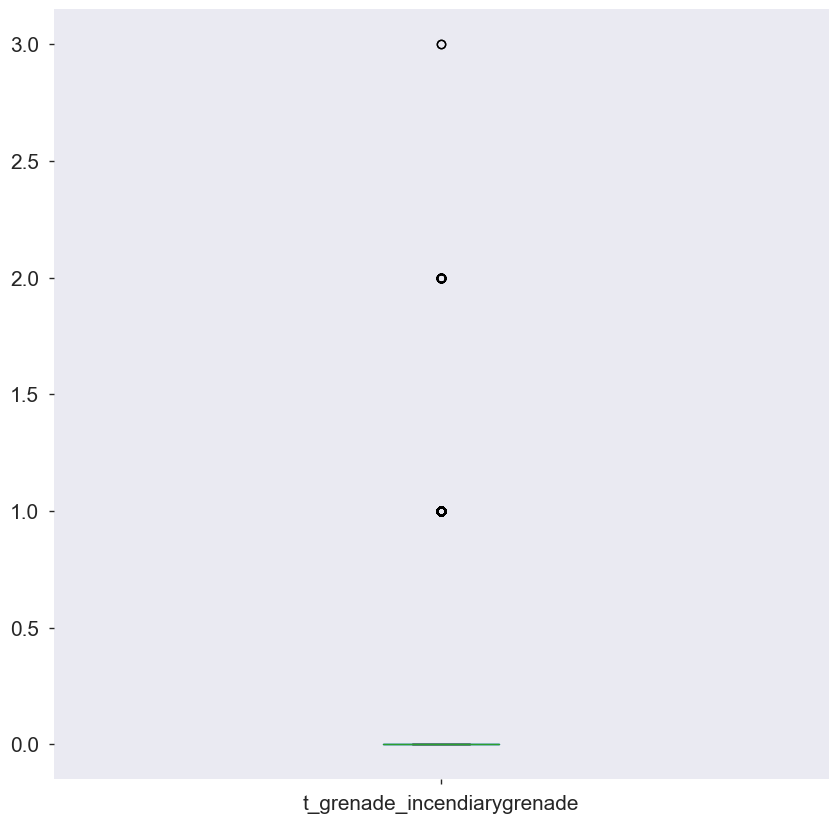

Analyzing outliers of column: ct_grenade_molotovgrenade


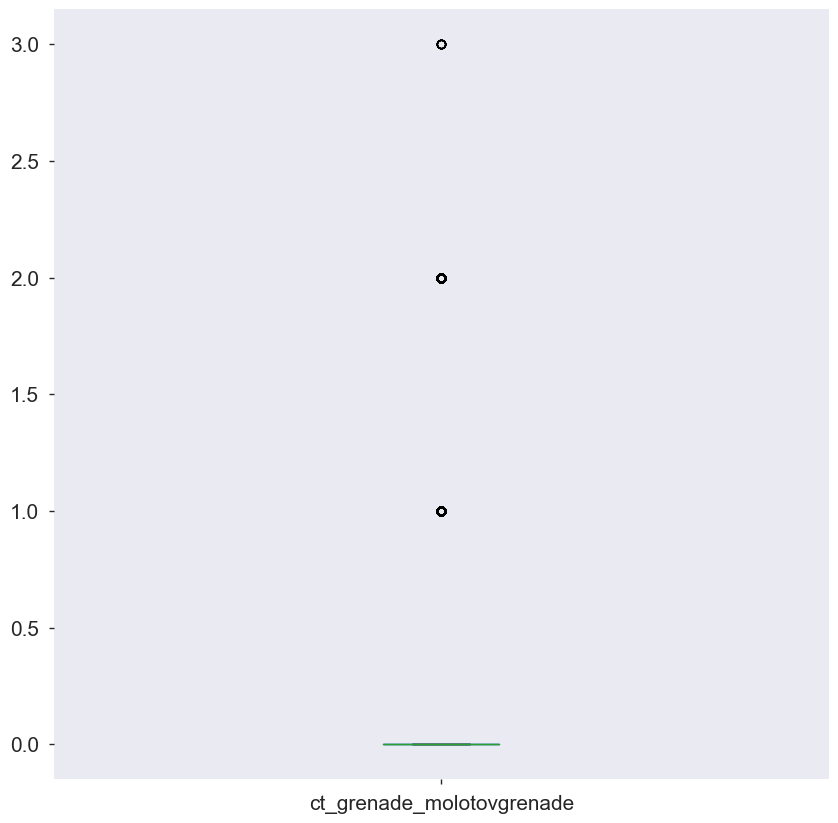

Analyzing outliers of column: t_grenade_molotovgrenade


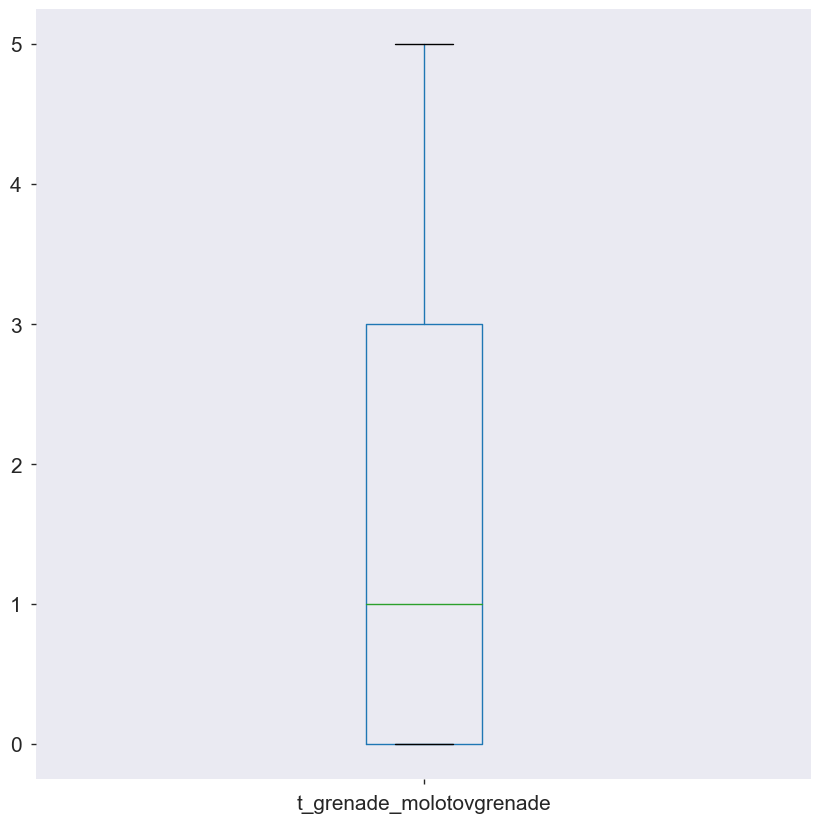

Analyzing outliers of column: ct_grenade_decoygrenade


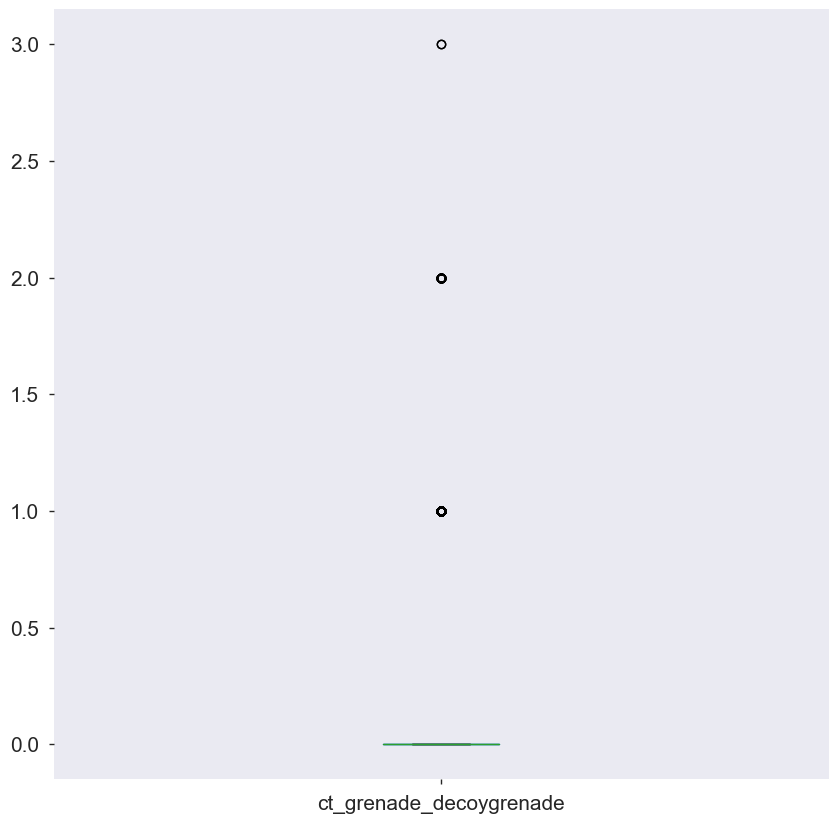

Analyzing outliers of column: t_grenade_decoygrenade


Analyzing outliers of column: round_winner


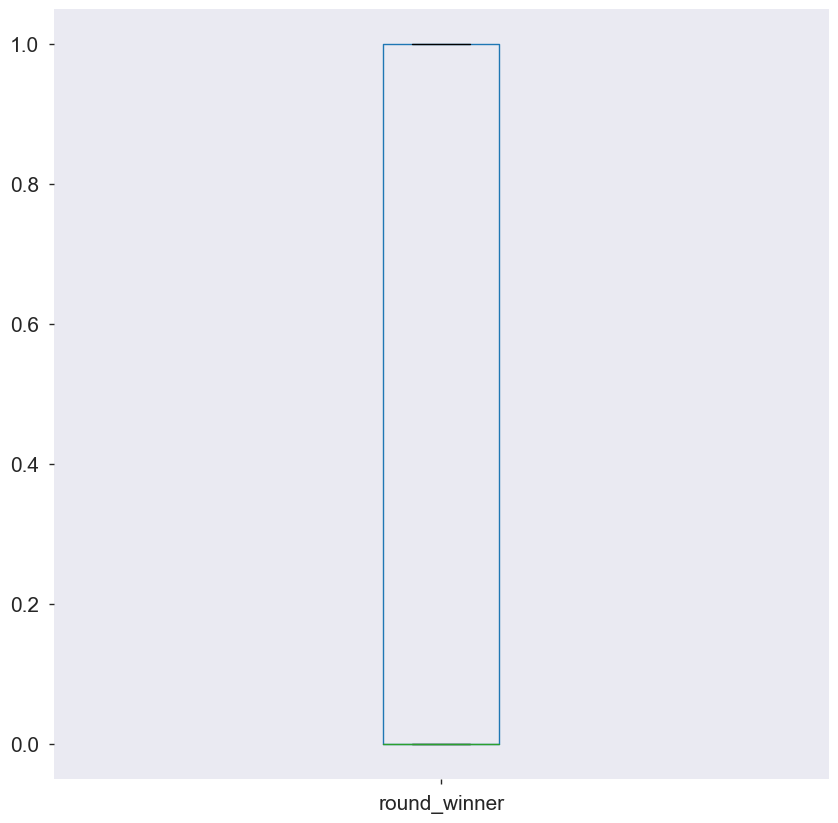

Analyzing outliers of column: map_de_cache


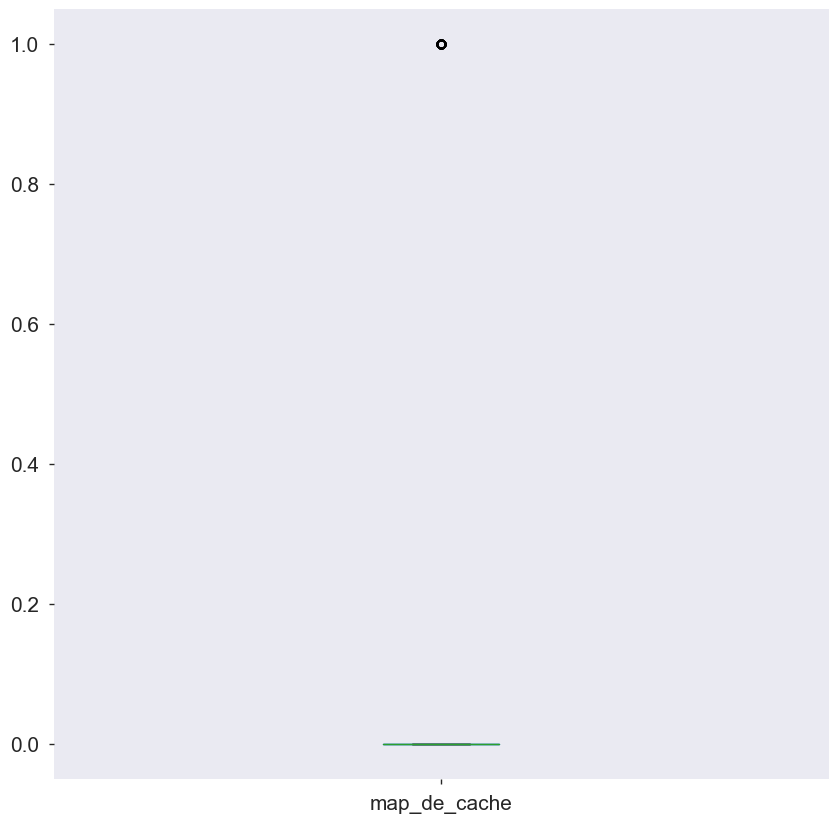

Analyzing outliers of column: map_de_dust2


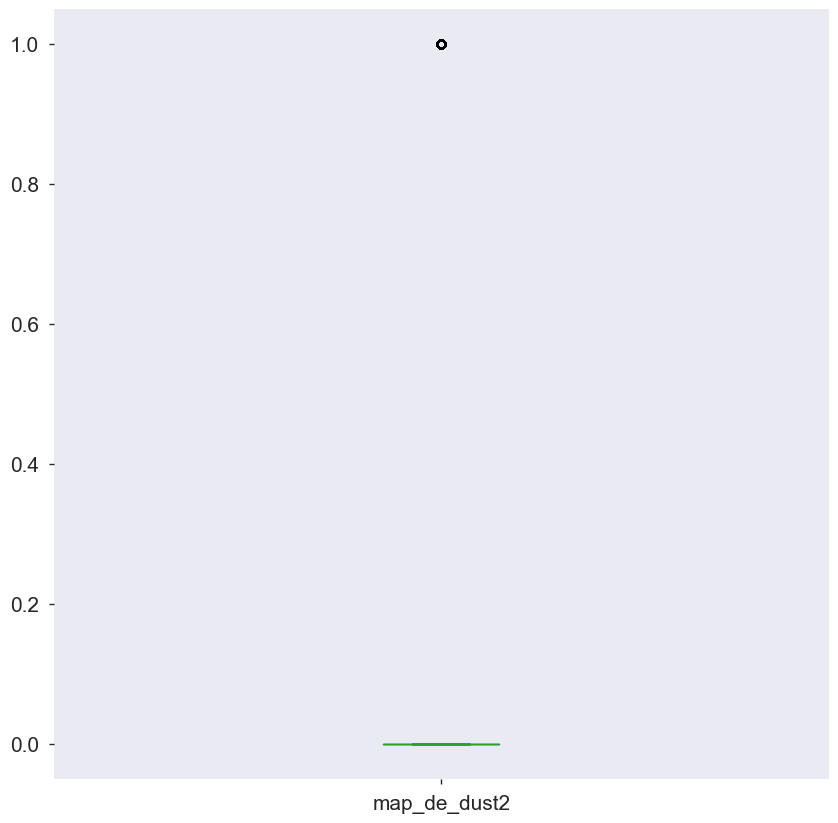

Analyzing outliers of column: map_de_inferno


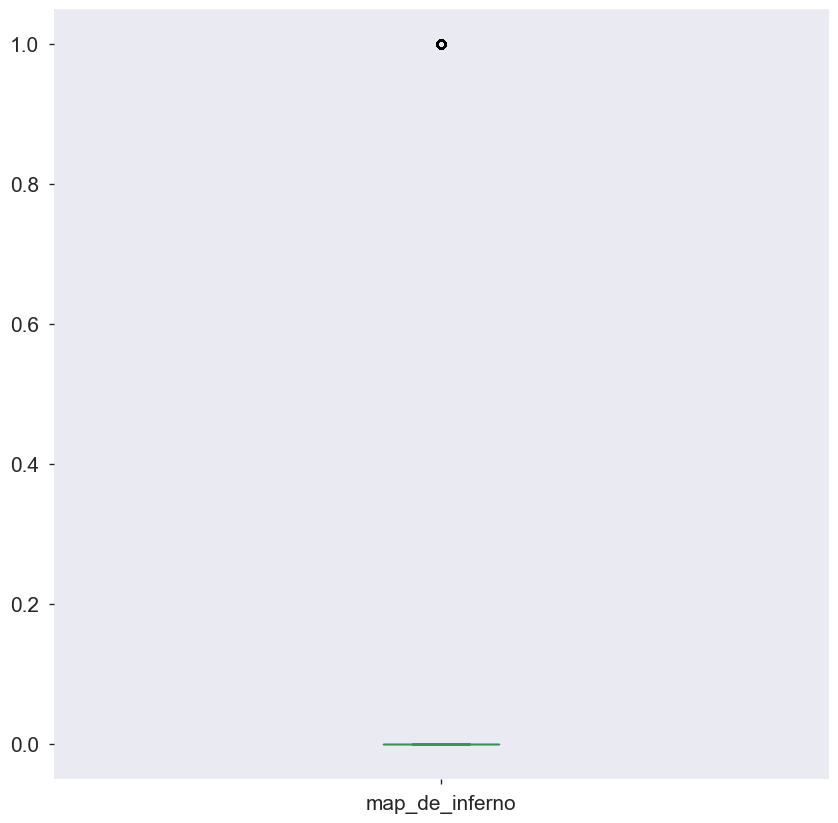

Analyzing outliers of column: map_de_mirage


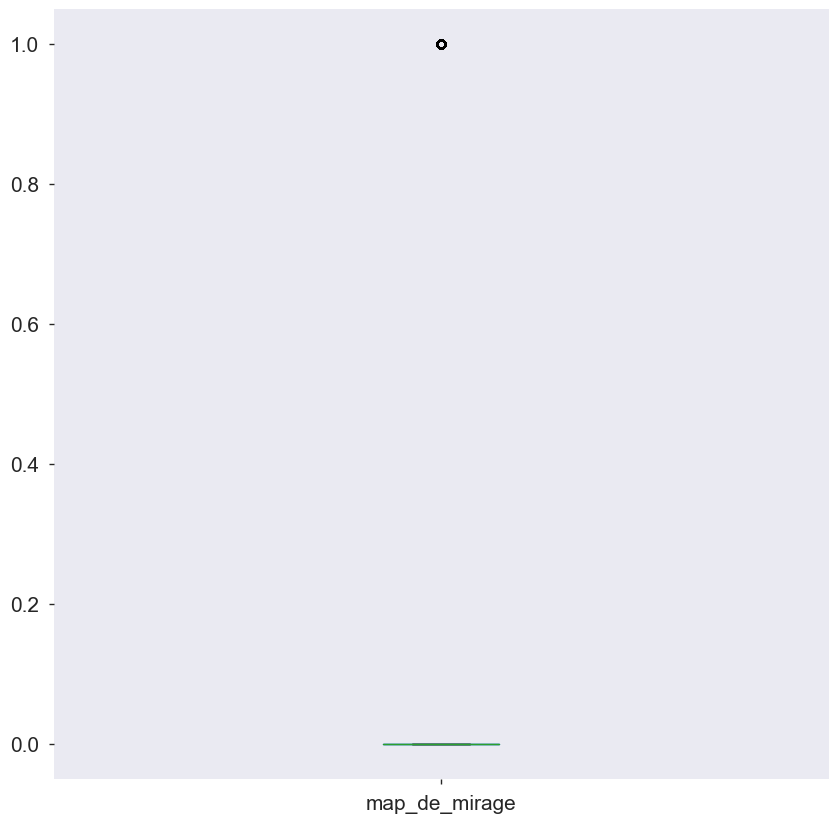

Analyzing outliers of column: map_de_nuke


Analyzing outliers of column: map_de_overpass


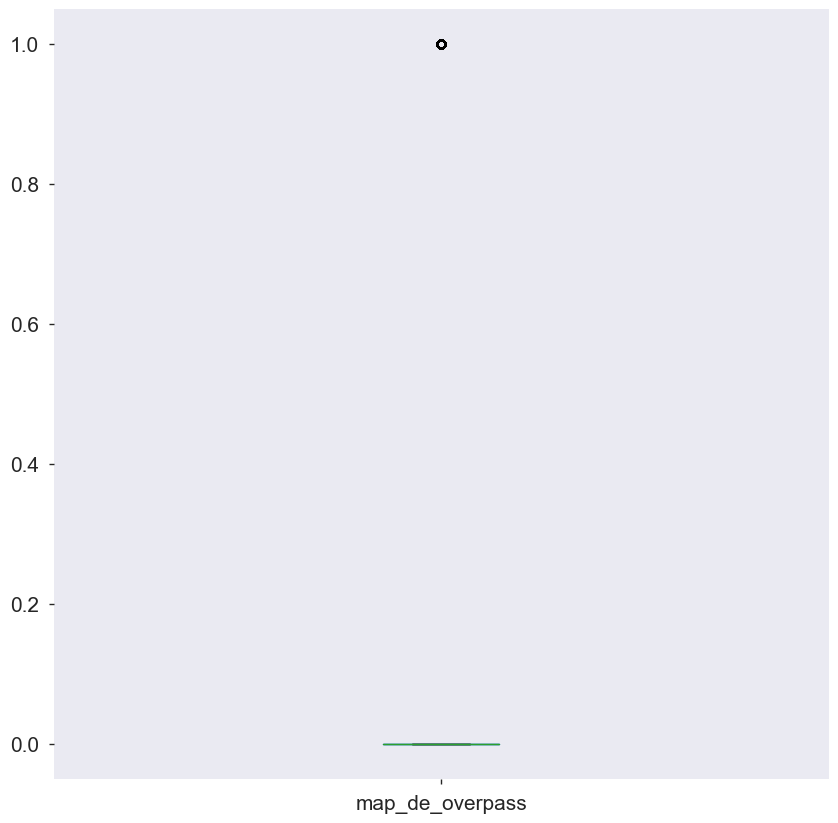

Analyzing outliers of column: map_de_train


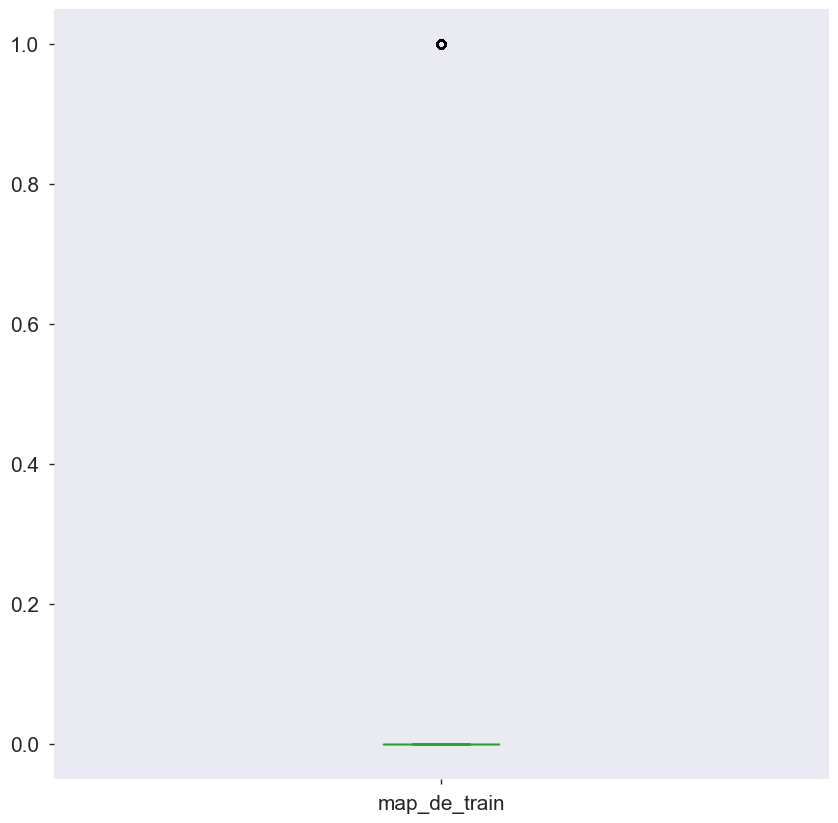

Analyzing outliers of column: map_de_vertigo


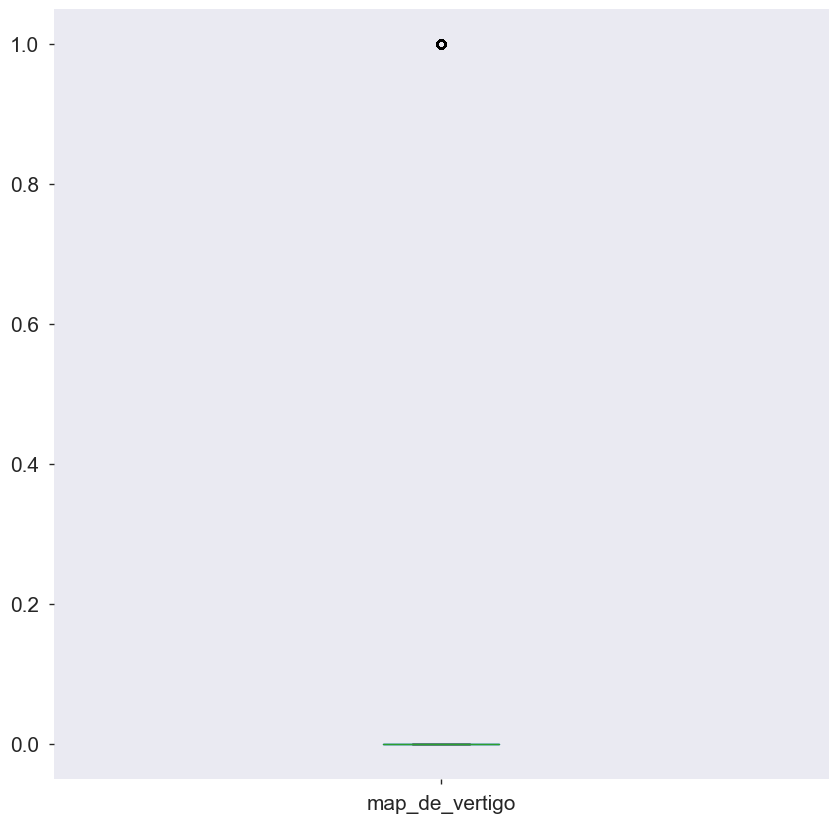

Analyzing outliers of column: timeleft_bin


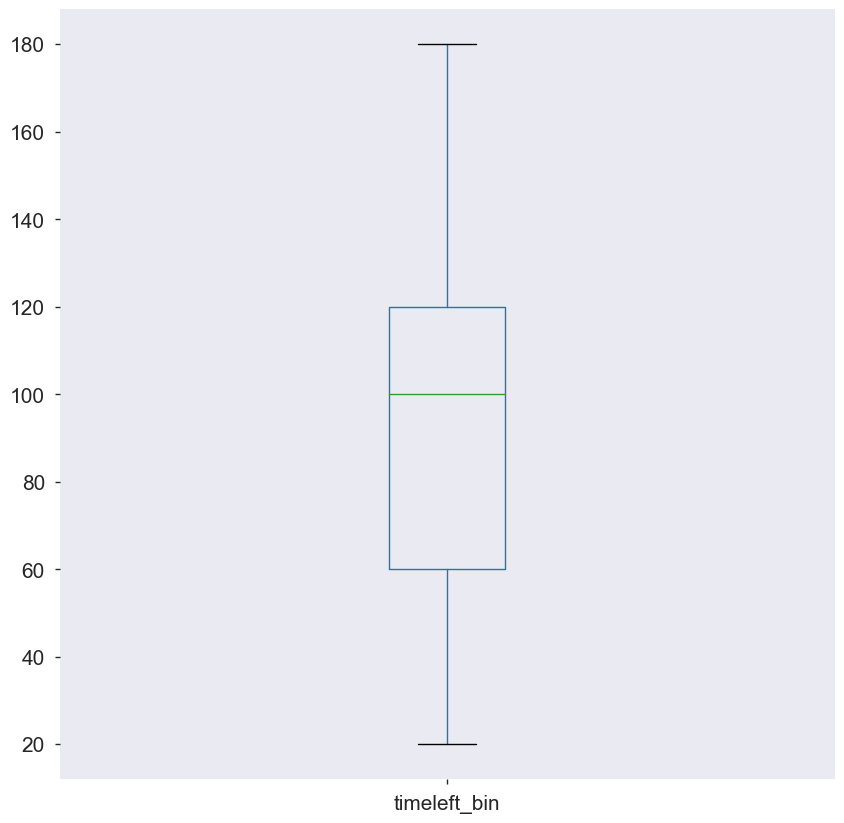

In [18]:
for (columnName, _) in train_data.iteritems():
    if train_data[columnName].dtype in ['int64','float64']: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        train_data.boxplot([columnName], grid=False, fontsize=15)
        #train_data = remove_outlier(hr_df,columnName)
        plt.show()

From the boxplots there are several outliers in the weapon features. However , the number of a specific weapon a team can have is only in the range 0-5. As there are max 5 players on a team. For this reason it does not make sense to consider these values in the weapon features as outliers. 

Similary for all other features no outlier handling will be done. As the outliers identified outside the IQR, are actually part of the features distributions adn shouldnt be considered outliers. Removing or changing them may result in one lossing significant information correlating to the team winning the round or not.  The reasoning behind this is explained further in the report. 





***Looking at the Boxplots, we did find 2 distinct outliers. t_health had one record of 600, which is cannot be, because 500 is the max health and t_players_alive has had 6 instead of its limit 5. Hence, we need to drop this row. As it turns out, the two values were within in the same row...***

In [172]:
train_data[train_data['t_players_alive']==6] # drop the 1 row with the outlier

time_left  ct_score  t_score  bomb_planted  ct_health  t_health  \
46347      175.0       0.0      0.0             0      400.0     600.0   

       ct_armor  t_armor  ct_money  t_money  ...        maps  map_de_cache  \
46347       0.0      0.0    3200.0   4800.0  ...  de_vertigo           0.0   

       map_de_dust2  map_de_inferno  map_de_mirage  map_de_nuke  \
46347           0.0             0.0            0.0          0.0   

       map_de_overpass  map_de_train  map_de_vertigo  timeleft_bin  
46347              0.0           0.0             1.0           180  

[1 rows x 106 columns]

In [13]:
# drop that specific row
train_data.drop(train_data[ train_data['t_players_alive'] == 6].index , inplace=True)

## 3.3. Visualizations

Visualization of features and their interactions are done in order to get deeper insight and understanding into our data set and the effects of the different features.

The visualizations are shown here and the insights extracted from them are discussed further in the report.

In [23]:
# style setup
sns.set_palette("pastel")

#### (1) Winners on each map

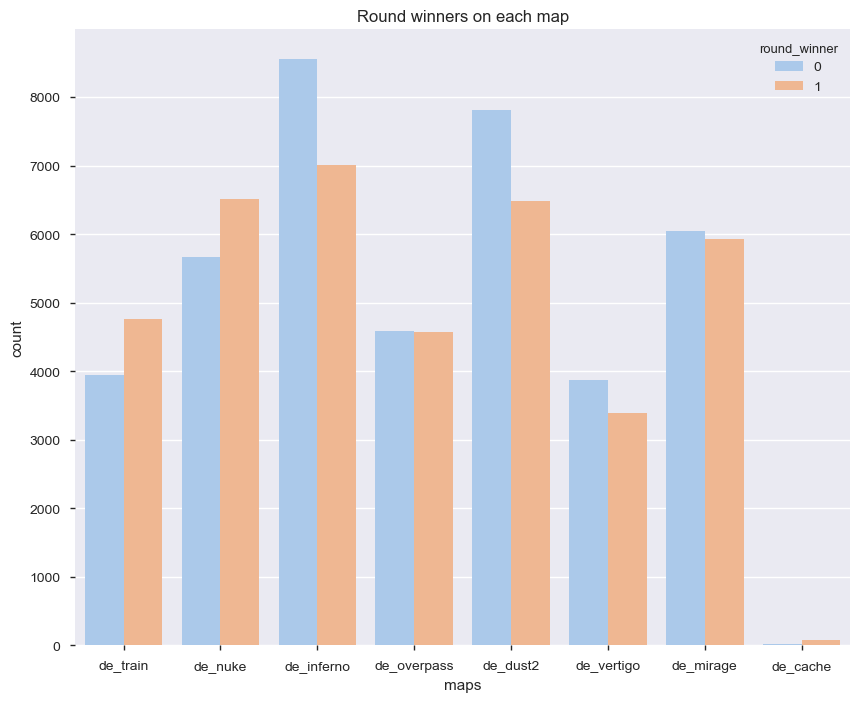

In [24]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="maps", hue="round_winner", data=train_data)
ax.set(title='Round winners on each map')
plt.show()

#### (2) Bombs planted on each map

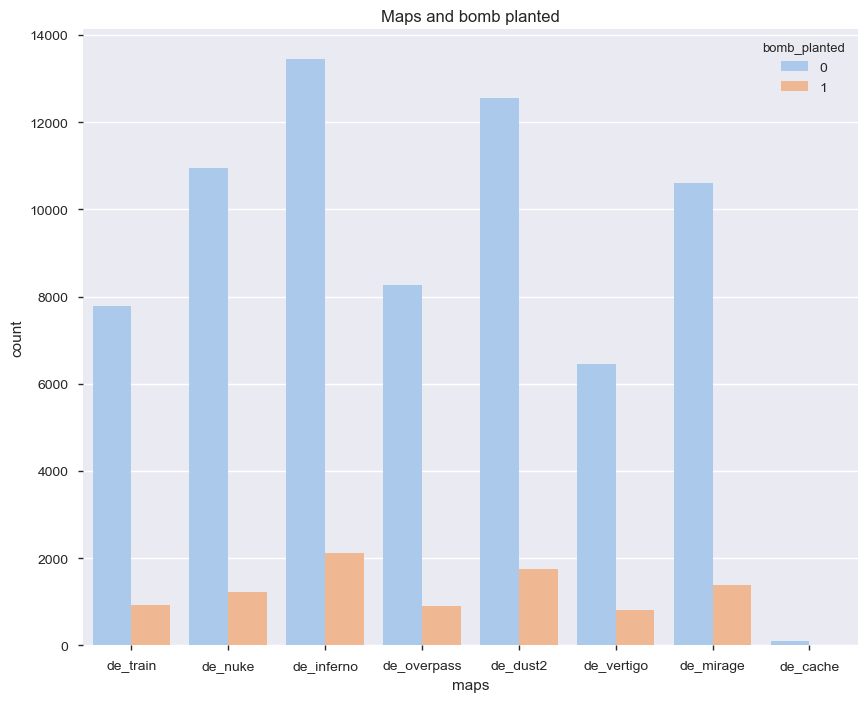

In [25]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="maps", hue="bomb_planted", data=train_data)
ax.set(title='Maps and bomb planted')
plt.show()

#### (3) Roundwinners

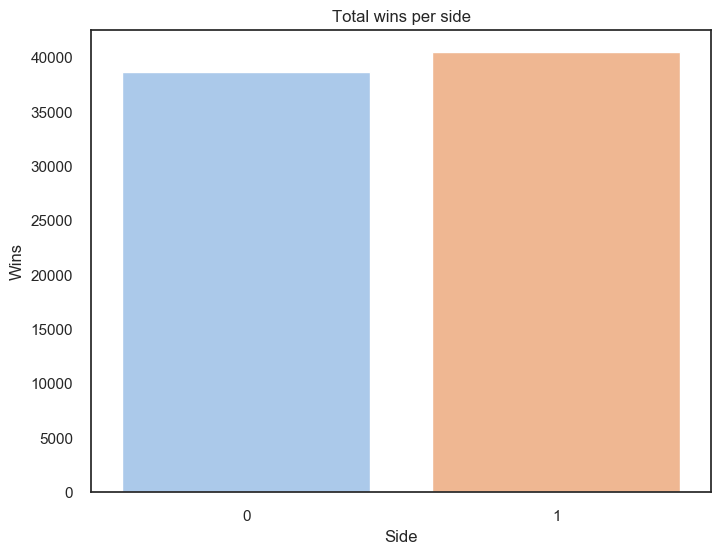

In [69]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x = train_data['round_winner'].unique(), y = train_data['round_winner'].value_counts())
ax.set(title='Total wins per side', xlabel='Side', ylabel='Wins')
plt.show()

#### (4) Total time left

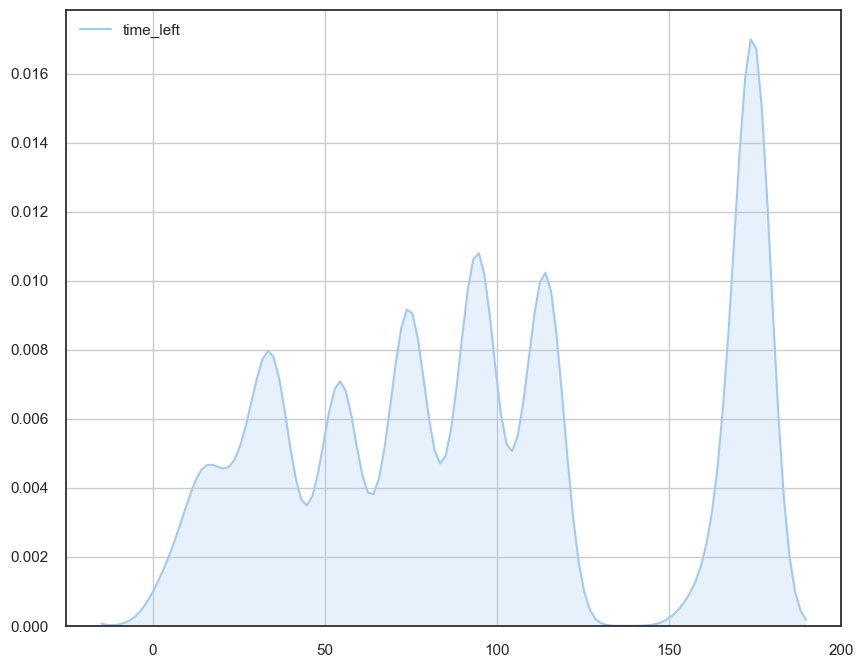

In [34]:
# Plot the distribution of time left
plt.figure(figsize=(10,8))
ax = sns.kdeplot(train_data['time_left'], shade=True)
ax.grid()

#### (5) CT side players alive distribution per time left in the round in seconds

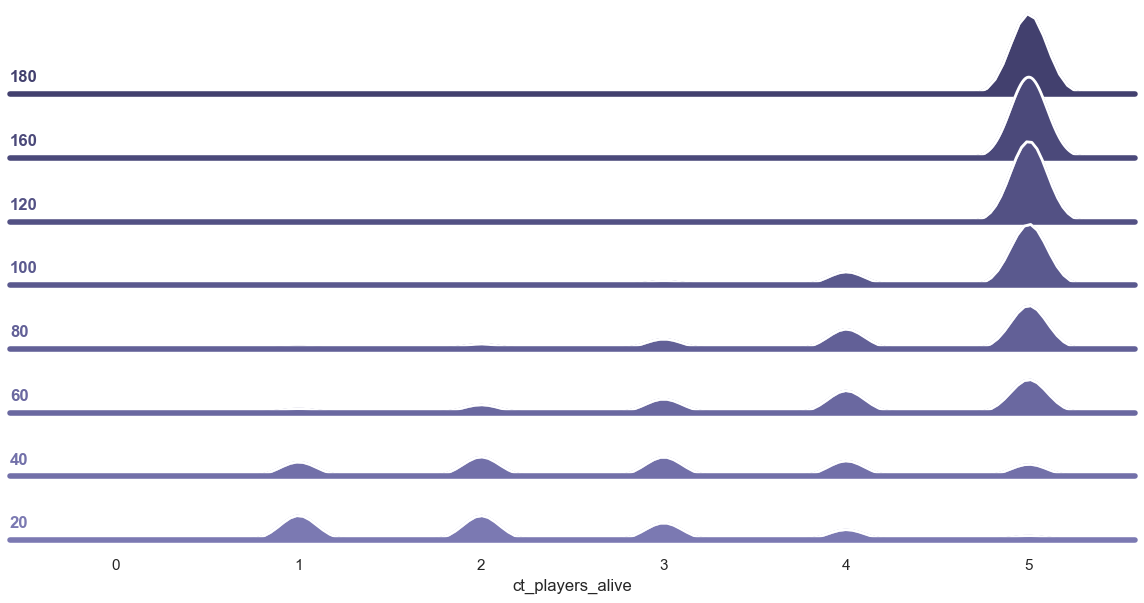

In [30]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-.01, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "ct_players_alive", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.1) # plot densities
ridge_plot.map(sns.kdeplot, "ct_players_alive", clip_on=False, color="w", lw=2, bw=0.1) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "ct_players_alive")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### (6) T side players alive distribution per time left in the round in seconds

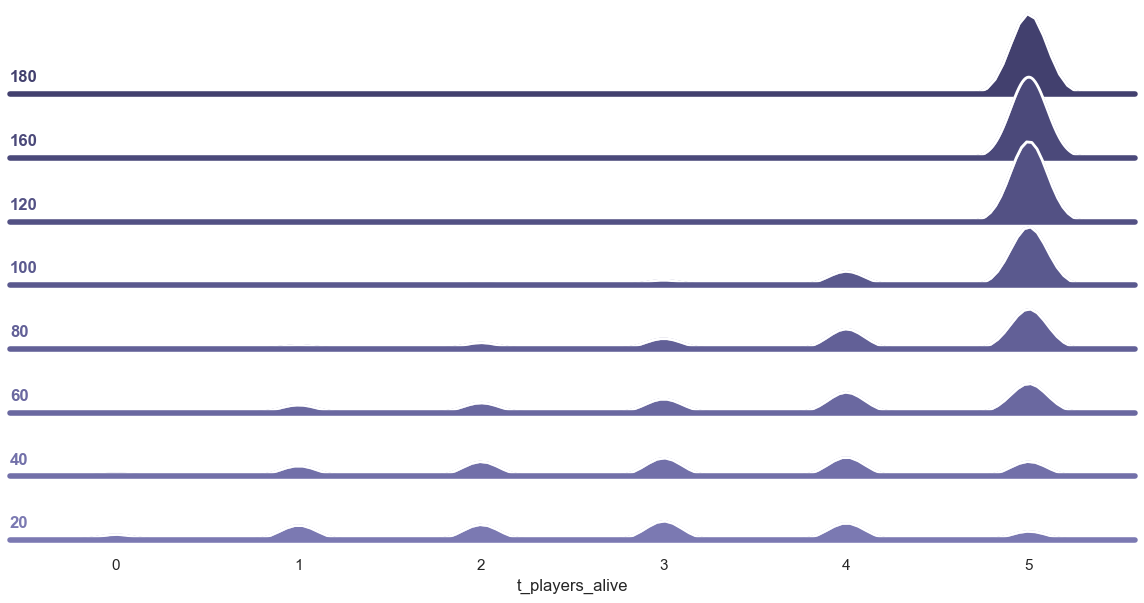

In [39]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-.01, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "t_players_alive", clip_on=False, shade=True, alpha=1, lw=1.5, bw=0.1) # plot densities
ridge_plot.map(sns.kdeplot, "t_players_alive", clip_on=False, color="w", lw=2, bw=0.1) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "t_players_alive")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### (7) CT side armor distribution per time left in the round in seconds

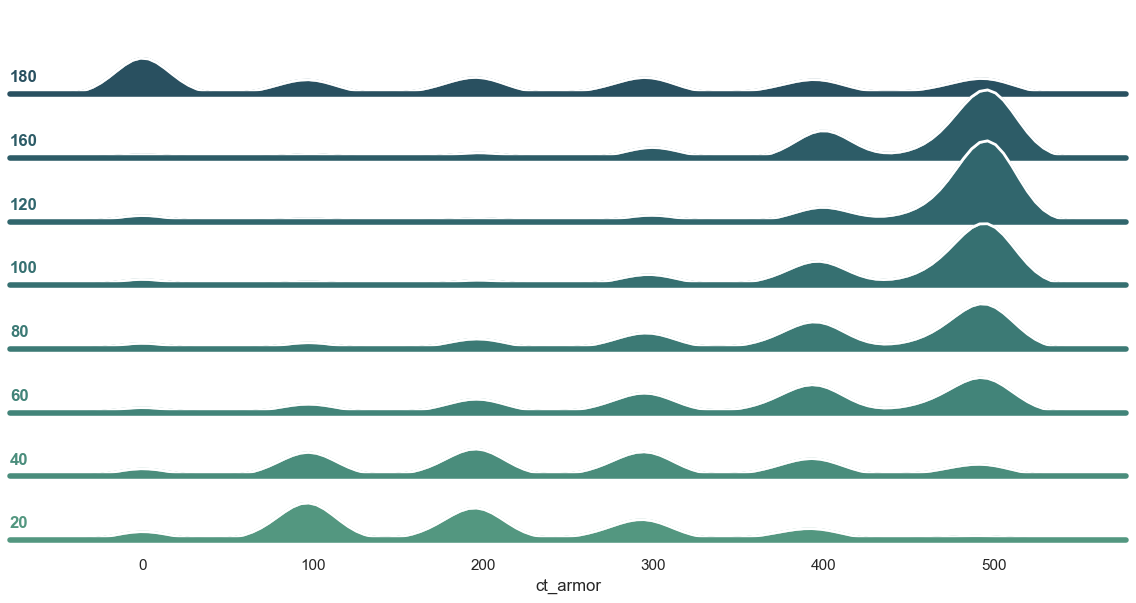

In [40]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-.5, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "ct_armor", clip_on=False, shade=True, alpha=1, lw=1.5, bw=16) # plot densities
ridge_plot.map(sns.kdeplot, "ct_armor", clip_on=False, color="w", lw=2, bw=16) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "ct_armor")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### (8) T side armor distribution per time left in the round in seconds

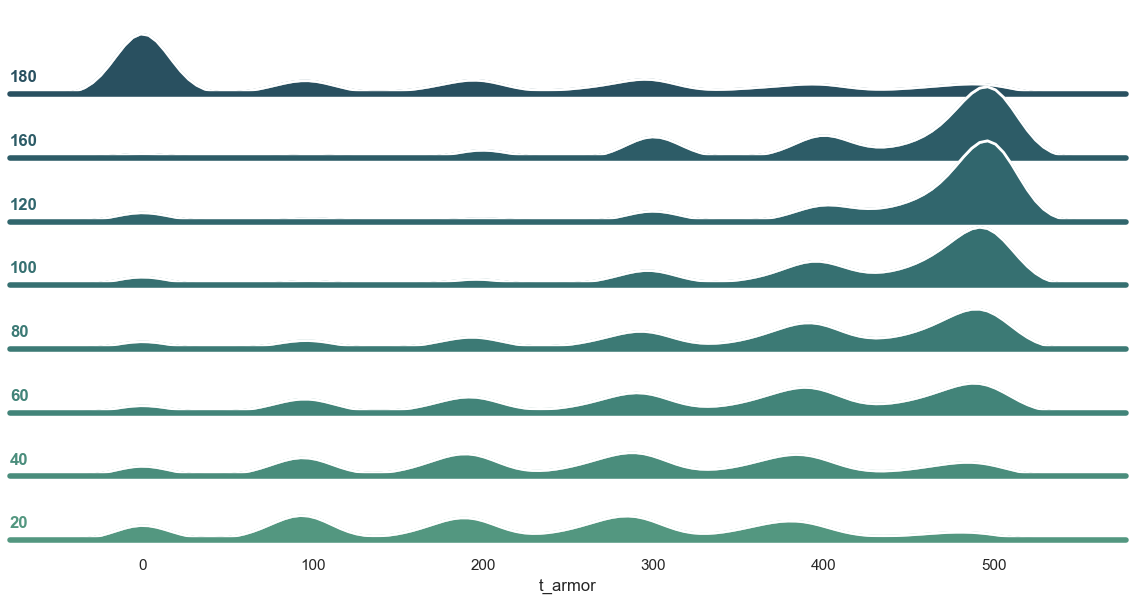

In [41]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-.5, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "t_armor", clip_on=False, shade=True, alpha=1, lw=1.5, bw=16) # plot densities
ridge_plot.map(sns.kdeplot, "t_armor", clip_on=False, color="w", lw=2, bw=16) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "t_armor")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### (9) CT side money distribution per time left in the round in seconds

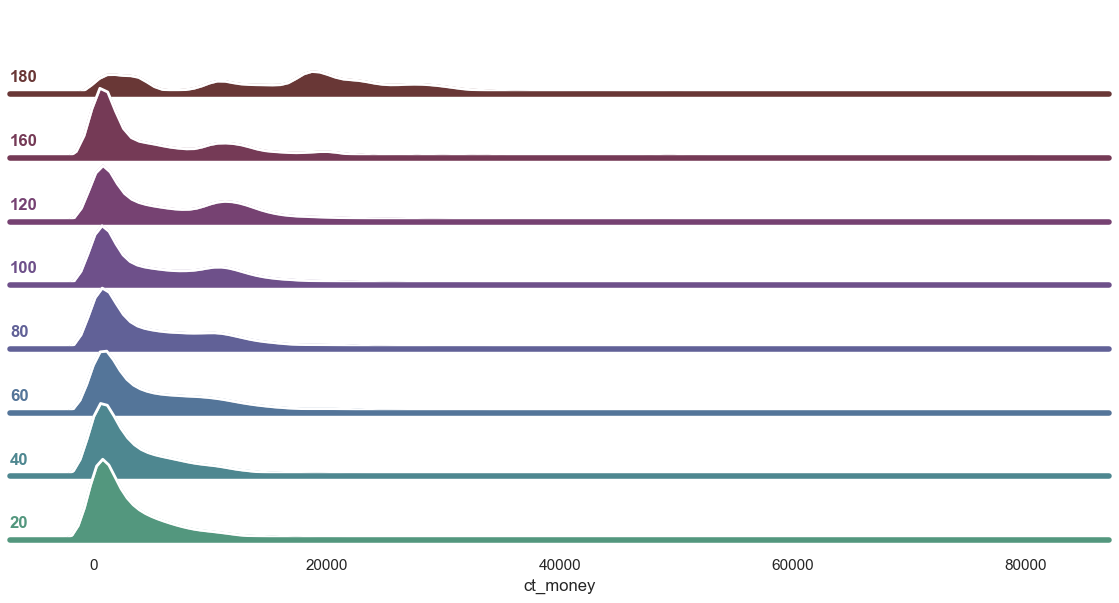

In [42]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-2.5, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "ct_money", clip_on=False, shade=True, alpha=1, lw=1.5, bw=950) # plot densities
ridge_plot.map(sns.kdeplot, "ct_money", clip_on=False, color="w", lw=2, bw=950) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "ct_money")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### (10) T side money distribution per time left in the round in seconds

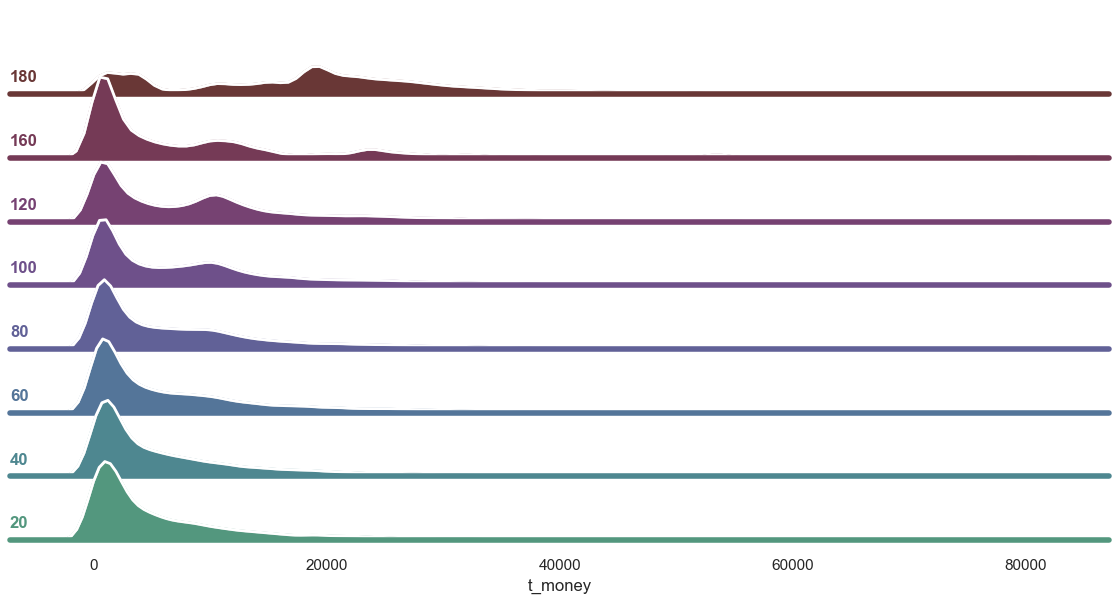

In [43]:
# set background white
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# set Facetgraph
pal = sns.cubehelix_palette(12, rot=-2.5, light=0.5)
ridge_plot = sns.FacetGrid(train_data, row="timeleft_bin", hue="timeleft_bin", row_order=[180,160,120,100,80,60,40,20], aspect=15, height=.8, palette=pal)

# plot densities
ridge_plot.map(sns.kdeplot, "t_money", clip_on=False, shade=True, alpha=1, lw=1.5, bw=950) # plot densities
ridge_plot.map(sns.kdeplot, "t_money", clip_on=False, color="w", lw=2, bw=950) # plot border between densities
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)

# function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

# set labels
ridge_plot.map(label, "t_money")

# set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.25)

# remove axes details
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.despine(bottom=True, left=True)

#### Extra Graph Setups

In [44]:
# Setting up lists of columns and datasets per CT / T
ct_cols = [col for col in train_data.columns if 'ct_' in col]
ct_data = train_data.loc[:, ct_cols]

almost_t_cols = [col for col in train_data.columns if 'ct_' not in col]
t_cols = [x for x in almost_t_cols if 't_' in x]

t_data = train_data.loc[:, t_cols]

In [45]:
# Setting up lists of columns and datasets with only "weapons", per CT / T
ct_weapon_cols = [col for col in train_data.columns if 'ct_weapon_' in col]
ct_weapon_data = train_data.loc[:, ct_weapon_cols]

almost_t_weapon_cols = [col for col in train_data.columns if 'ct_weapon_' not in col]
t_weapon_cols = [x for x in almost_t_weapon_cols if 't_weapon_' in x]

# t_weapon_cols
t_weapon_data = train_data.loc[:, t_weapon_cols]

In [47]:
# style setup
sns.set_palette("pastel")

#### (11) - T weapons

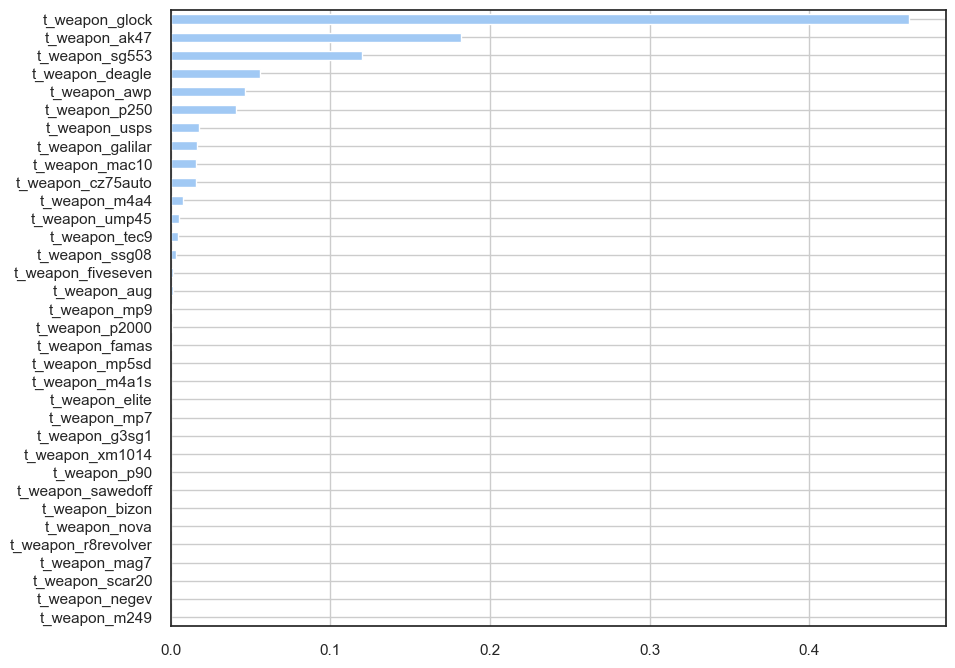

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
t_weapon_percent = t_weapon_data.sum() / t_weapon_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax, kind='barh')
ax.grid()

#### (12) - CT weapons

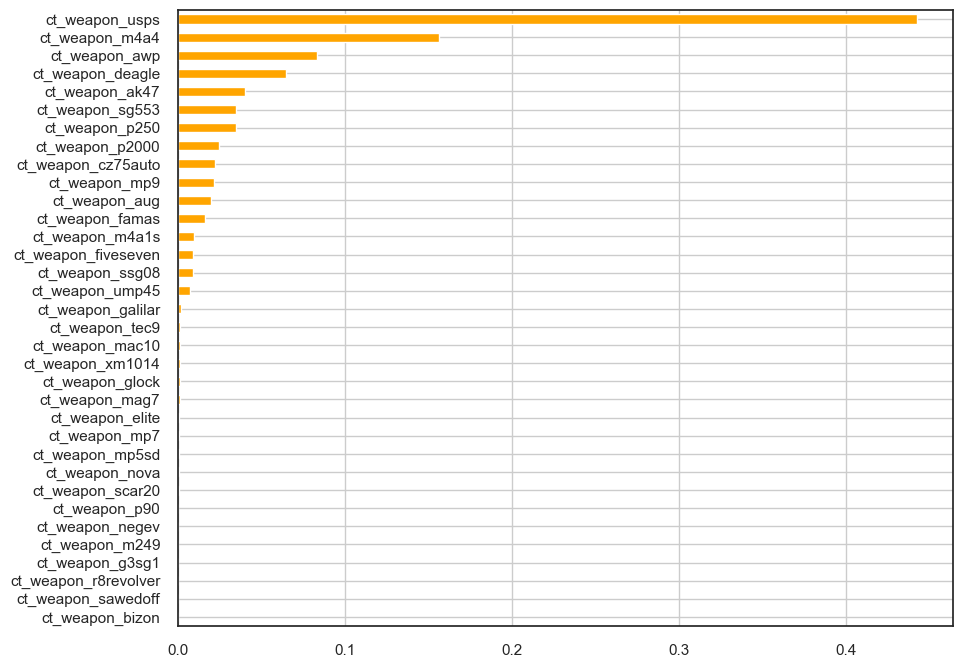

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
ct_weapon_percent = ct_weapon_data.sum() / ct_weapon_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax, kind='barh', color='orange')
ax.grid()

#### (13) - T weapons w/o glock

In [54]:
# Need to drop 'glock' from T and 'usps' from CT since skewing proportional view
t_weapon_data = t_weapon_data.drop('t_weapon_glock', 1, errors='ignore')
ct_weapon_data = ct_weapon_data.drop('ct_weapon_usps', 1, errors='ignore')

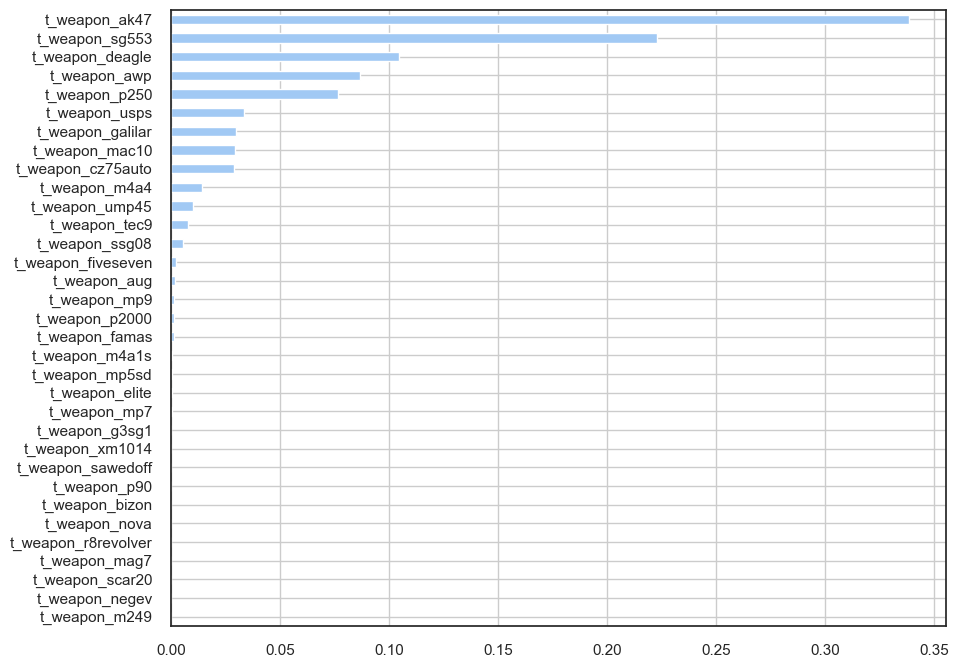

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
t_weapon_percent = t_weapon_data.sum() / t_weapon_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax, kind='barh')
ax.grid()

#### (14) - CT weapons w/o usps

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
ct_weapon_percent = ct_weapon_data.sum() / ct_weapon_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax, kind='barh', color='orange')
ax.grid()

#### (15) - T grenades

In [58]:
# Setting up lists of columns and datasets with only "grenades", per CT / T
ct_grenade_cols = [col for col in train_data.columns if 'ct_grenade_' in col]
ct_grenade_data = train_data.loc[:, ct_grenade_cols]

almost_t_grenade_cols = [col for col in train_data.columns if 'ct_grenade_' not in col]
t_grenade_cols = [x for x in almost_t_grenade_cols if 't_grenade_' in x]

# t_grenade_cols
t_grenade_data = train_data.loc[:, t_grenade_cols]

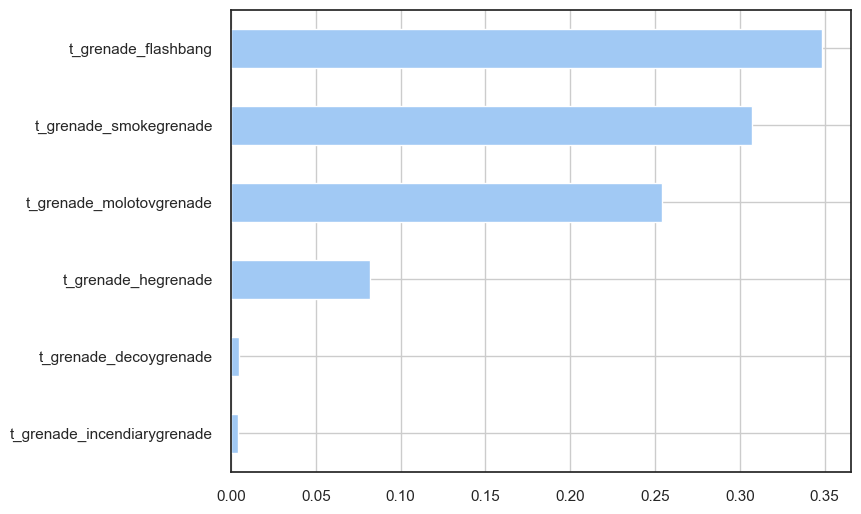

In [60]:
fig, ax = plt.subplots(figsize=(8,6))
t_grenade_percent = t_grenade_data.sum() / t_grenade_data.sum().sum()
ax = t_grenade_percent.sort_values().plot(ax=ax, kind='barh')
ax.grid()

#### (16) - CT weapons

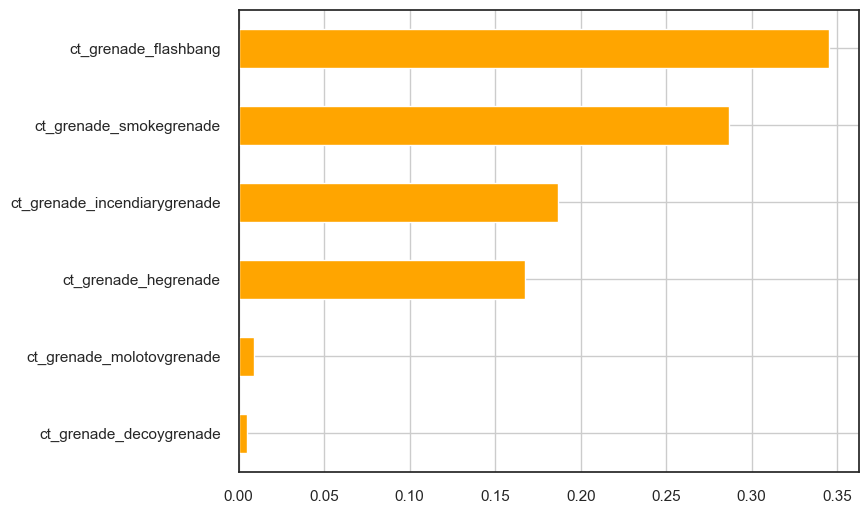

In [71]:
fig, ax = plt.subplots(figsize=(8,6))
ct_grenade_percent = ct_grenade_data.sum() / ct_grenade_data.sum().sum()
ax = ct_grenade_percent.sort_values().plot(ax=ax, kind='barh', color='orange')
ax.grid()

#### (17) Timestamp at which the bomb was planted

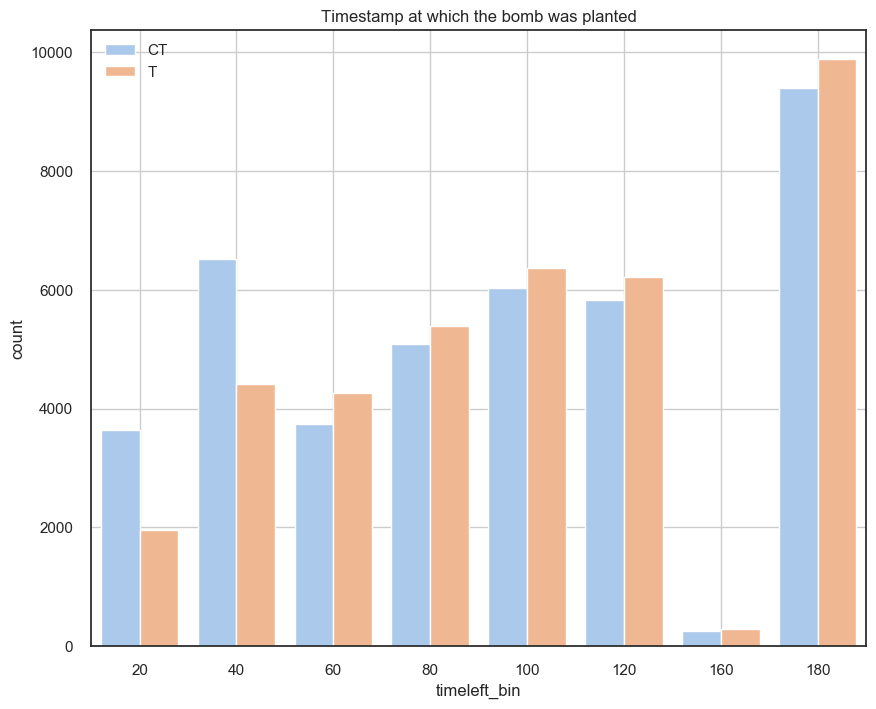

In [64]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="timeleft_bin", hue='round_winner', data=train_data)
ax.set(title='Timestamp at which the bomb was planted')
ax.legend(['CT','T'])
ax.grid()
plt.show()

#### (18) Number of defuse kits by round winner

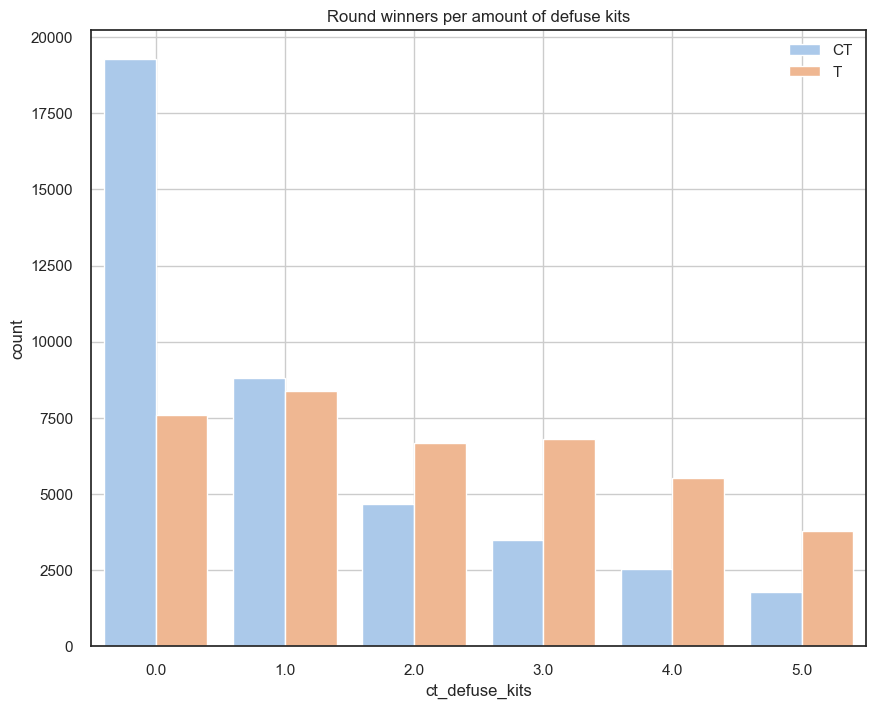

In [67]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data)
ax.set(title='Round winners per amount of defuse kits')
ax.legend(['CT','T'])
ax.grid()
plt.show()

#### (19) Number of defuse kits by round winner, by map area

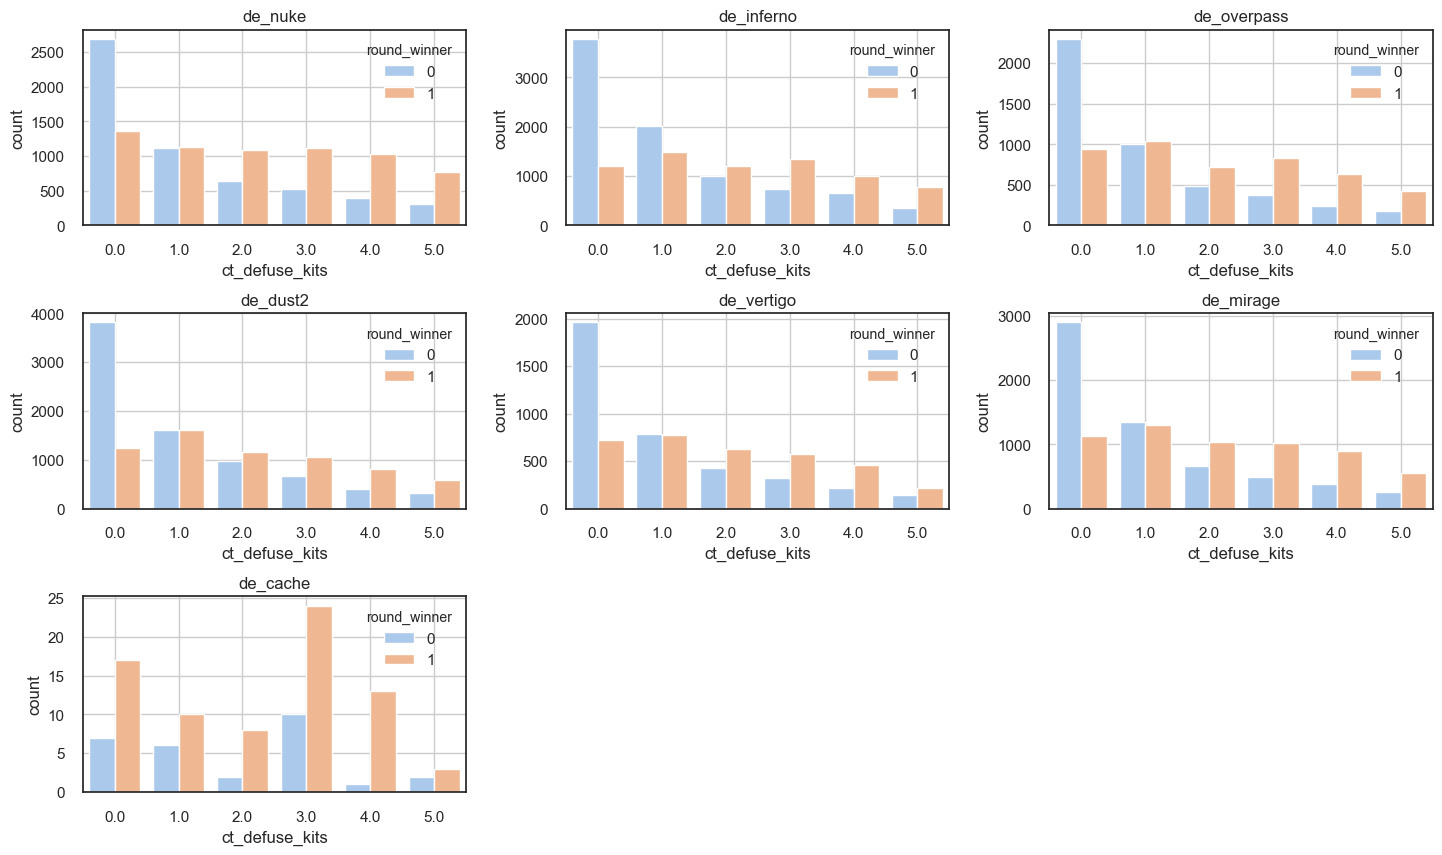

In [83]:
# Number of defuse kits by round winner, by map area
f, axes = plt.subplots(3, 3, figsize=(15, 9))
f.tight_layout(pad=3.0)

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_nuke"] == 1], ax=axes[0, 0])
axes[0,0].set_title("de_nuke")
axes[0,0].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_inferno"] == 1], ax=axes[0, 1])
axes[0,1].set_title("de_inferno")
axes[0,1].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_overpass"] == 1], ax=axes[0, 2])
axes[0,2].set_title("de_overpass")
axes[0,2].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_dust2"] == 1], ax=axes[1, 0])
axes[1,0].set_title("de_dust2")
axes[1,0].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_vertigo"] == 1], ax=axes[1, 1])
axes[1,1].set_title("de_vertigo")
axes[1,1].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_mirage"] == 1], ax=axes[1, 2])
axes[1,2].set_title("de_mirage")
axes[1,2].grid()

sns.countplot(x="ct_defuse_kits", hue="round_winner", data=train_data.loc[train_data["map_de_cache"] == 1], ax=axes[2, 0])
axes[2,0].set_title("de_cache")
axes[2,0].grid()

# delete last two empty graphs
f.delaxes(axes[2,1])
f.delaxes(axes[2,2])

# IV. Feature Engineering

## 4.1. PCA Analysis

A PCA anysis will be done in order to see if it is possible to reduce the number of features in the data set.

PCA is only valid to impliment when there are high correlation between features in the dataset.

First the correlations between features in the training data set will be analysed:

Plotting the correlation matrix on the following variables : ['time_left', 'ct_score', 't_score', 'bomb_planted', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon', 'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite', 't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas', 'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar', 't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock', 'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s', 'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10', 'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd', 'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9']


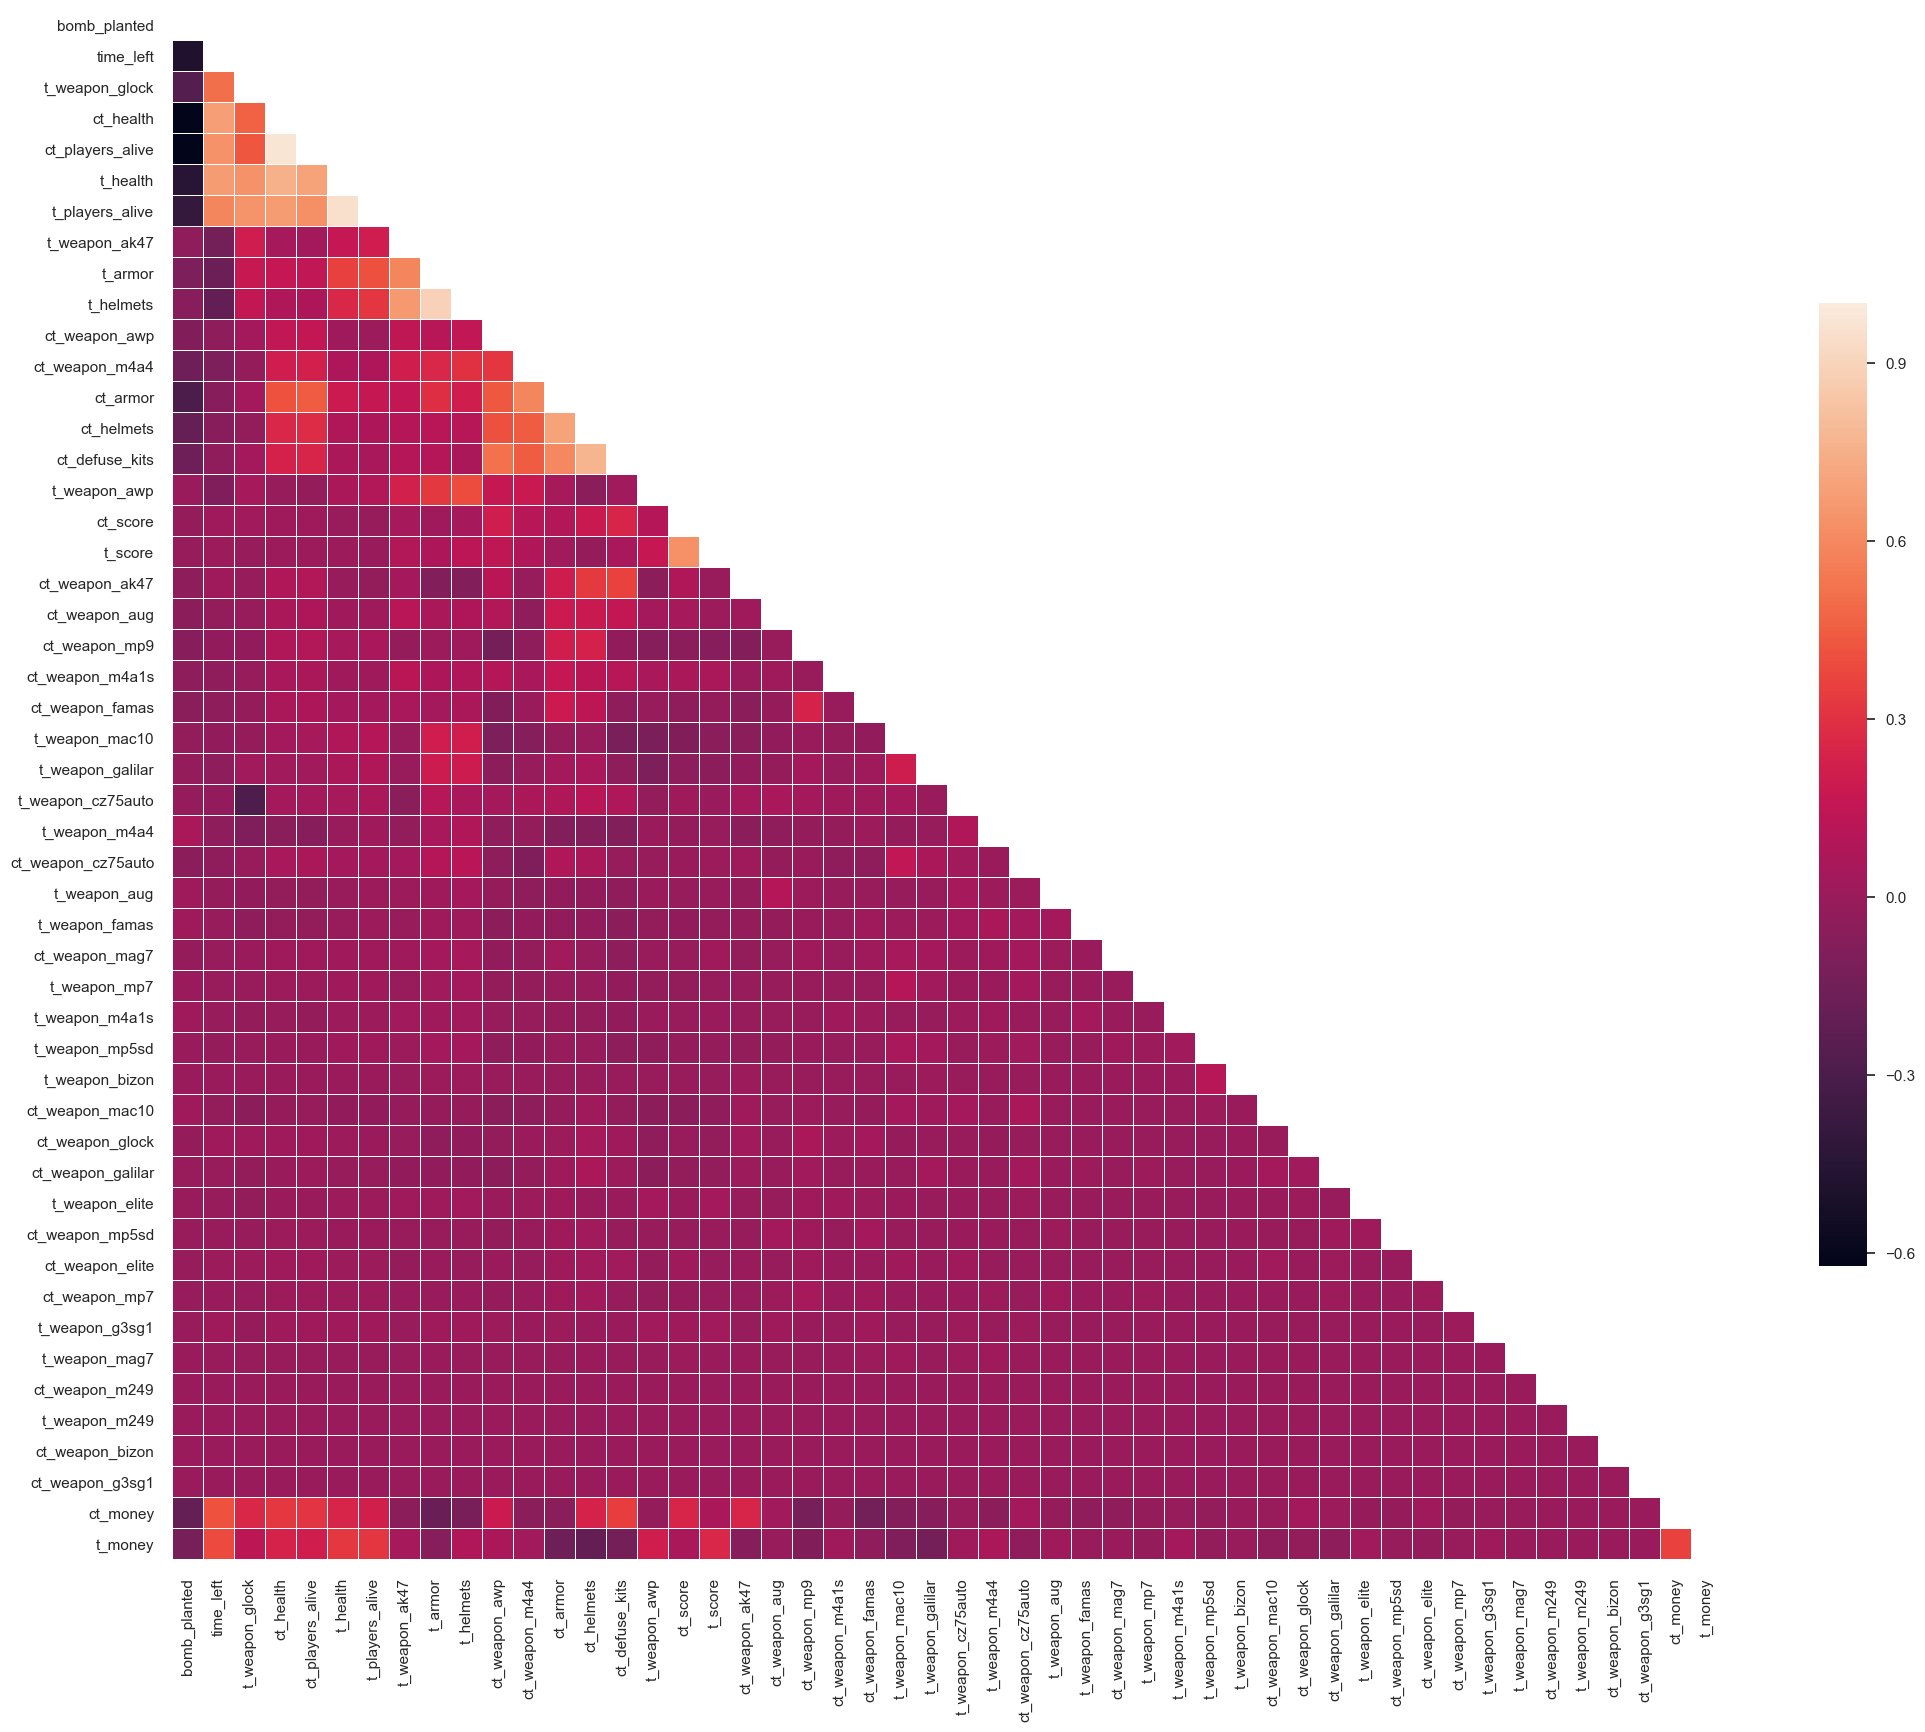

In [140]:
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix


# Get the column names
numerical_columns = list(train_data.select_dtypes(include=[np.number]).columns)
categorical_columns = list(train_data.select_dtypes(include=[object]).columns)
date_columns = list(train_data.select_dtypes(include=['<M8[ns]']).columns)

# Select variables to plot for the correlation matrix
corr_matrix_vars = numerical_columns[0:50]

print("Plotting the correlation matrix on the following variables : %s" % corr_matrix_vars)

# Only select the requested columns
df_corr_matrix = train_data[corr_matrix_vars]

# This computes the Pearson coefficient for all couples
corr = df_corr_matrix.corr().fillna(0)

# Generate features and distance matrix.
D = corr.values
# Compute and plot dendrogram.
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right',no_plot=True)
# Compute distance matrix.
index = Z['leaves']
D = D[index,:]
D = D[:,index]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(D, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)
#ax.set(xticks=range(len(corr.columns)), xticklabels=corr.columns[index], yticks=range(len(corr.columns)), yticklabels=reversed(corr.columns[index]))
ax.set_xticklabels(corr.columns[index], rotation=90, ha='center');
ax.set_yticklabels(corr.columns[index], rotation=0);

In [33]:
# PCA Analysis
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_pca = sc.fit_transform(train_data.drop("maps", axis = 1))
## !! need to remeber to do this for test set as well

from sklearn.decomposition import PCA
pca = PCA(n_components= 60)
X_train_pca = pca.fit_transform(X_train_pca)

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.09016859, 0.0531938 , 0.05100153, 0.02775633, 0.02386893,
       0.01891371, 0.01524887, 0.01504683, 0.01488058, 0.0147295 ,
       0.01349045, 0.01313545, 0.01279791, 0.01239083, 0.01202291,
       0.01196361, 0.01174536, 0.01142938, 0.01127767, 0.01116321,
       0.01097441, 0.0108052 , 0.01060383, 0.01055027, 0.01047554,
       0.01044011, 0.01041967, 0.01038856, 0.01036046, 0.01033153,
       0.0102767 , 0.01024739, 0.01020895, 0.01019977, 0.01017222,
       0.01017068, 0.01011967, 0.01008719, 0.01008323, 0.01004464,
       0.00999219, 0.0099726 , 0.00990916, 0.00982021, 0.00976965,
       0.00968413, 0.00966211, 0.00963545, 0.00956922, 0.00947214,
       0.00937397, 0.00923168, 0.00916466, 0.00915771, 0.00898789,
       0.00892911, 0.00881038, 0.00877349, 0.00861845, 0.00850157])

In [34]:
len(explained_variance)

60

In [35]:
explained_variance.sum()

0.8402212543677599

Through PCA 84% of the variance in the train set was able to be captured in 60 features. However each of the features only contributes less than 1% of the variance. Which indicates that PCA is not suited to be used here. 

To confirm this the Random Forest algorithm was run with the default hyperparameters for the PCA train set and the Train se after manual feature engineering shown next. The resulting accuracies were 81.82% for PCA and 84.32% for manual feature engineering. SHowing that PCA is not needed in this case 

## 4.2. Manual Feature Engineering

The weapons colums will be analysed in order to atempt to reduce the amount of features in the train data set. 

First in order to get a more in depth understanding of the weapons, they are grouped into different catagories as in the Counter stike game: 

* rifles
* smgs 
* heavies 
* pistols

As in the other visualisations the graphs will be explained here and the insights derived from them explained further in the corresposning report. 

In [84]:
rifles = ['ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_famas', 't_weapon_famas',
          'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar', 't_weapon_galilar', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
         'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_scar20', 't_weapon_scar20', 'ct_weapon_sg553', 't_weapon_sg553',
         'ct_weapon_ssg08', 't_weapon_ssg08']

smgs = ['ct_weapon_aug', 't_weapon_aug', 'ct_weapon_bizon', 't_weapon_bizon', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mp5sd', 't_weapon_mp5sd', 'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_p90', 't_weapon_p90', 'ct_weapon_ump45', 't_weapon_ump45']

heavies = ['ct_weapon_m249', 't_weapon_m249', 'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_negev', 't_weapon_negev',
        'ct_weapon_nova', 't_weapon_nova', 'ct_weapon_sawedoff', 't_weapon_sawedoff', 'ct_weapon_xm1014', 't_weapon_xm1014']

pistols = ['ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite', 't_weapon_elite', 'ct_weapon_glock', 't_weapon_glock',
         'ct_weapon_r8revolver', 't_weapon_r8revolver', 'ct_weapon_deagle', 't_weapon_deagle',
         'ct_weapon_usps', 't_weapon_usps', 'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000', 't_weapon_p2000',
         'ct_weapon_tec9', 't_weapon_tec9', 'ct_weapon_fiveseven', 't_weapon_fiveseven']

primary_weapons = {'rifles':rifles, 'smgs':smgs, 'heavies':heavies}

#### (20) CT & T Rifles

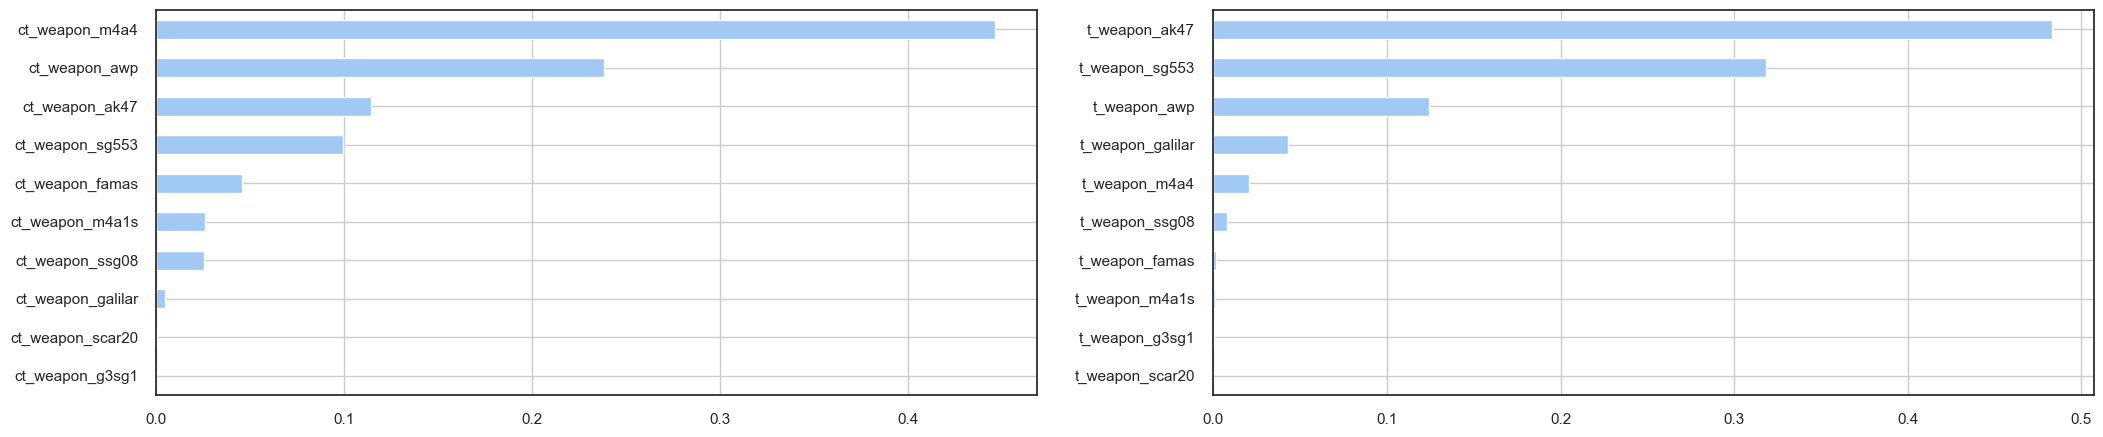

In [94]:
ct_rifles_data = ct_weapon_data[[r for r in  ct_weapon_data.columns if r in rifles]]
t_rifles_data = t_weapon_data[[r for r in  t_weapon_data.columns if r in rifles]]

# graph setup
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,5))

# Counter-Terrorists rifles
ct_weapon_percent = ct_rifles_data.sum() / ct_rifles_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax1, kind='barh')

# Terrorists rifles
t_weapon_percent = t_rifles_data.sum() / t_rifles_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax2, kind='barh')

ax1.grid()
ax2.grid()

#### (21) CT & T Sub-Machine_Guns

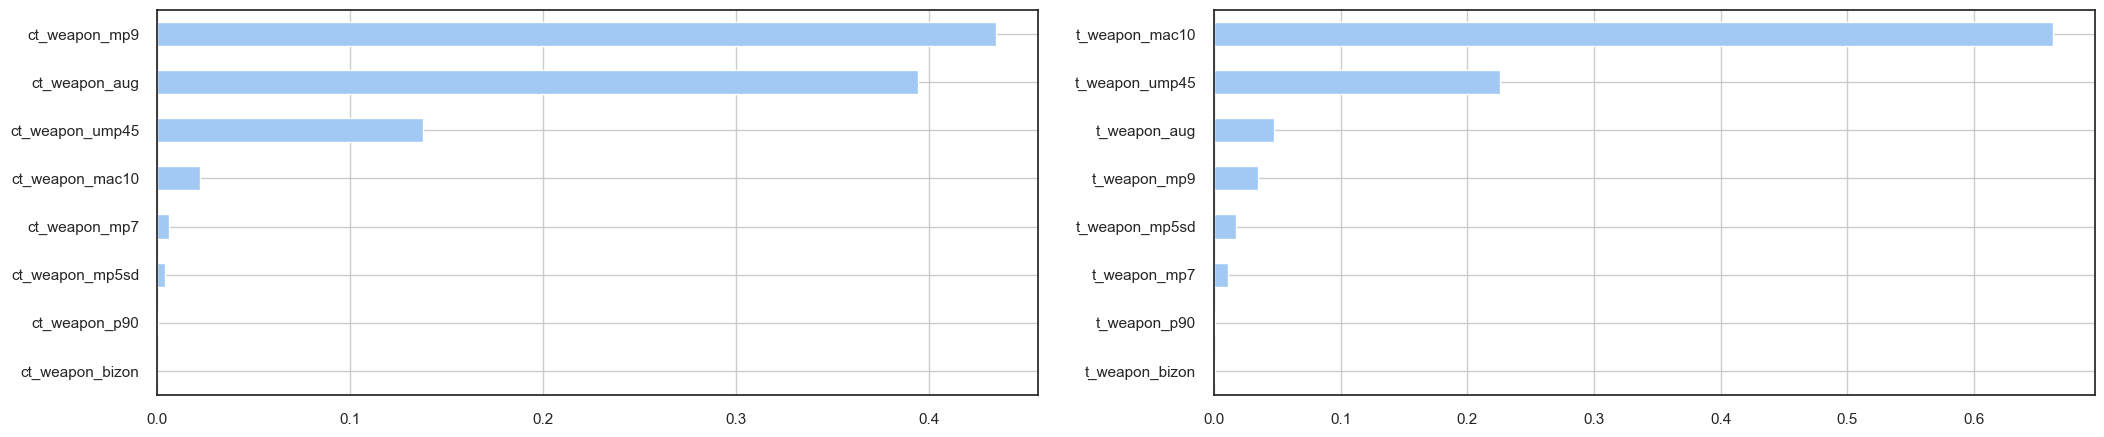

In [96]:
ct_smgs_data = ct_weapon_data[[r for r in  ct_weapon_data.columns if r in smgs]]
t_smgs_data = t_weapon_data[[r for r in  t_weapon_data.columns if r in smgs]]

# graph setup
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,5))

# Counter-Terrorists rifles
ct_weapon_percent = ct_smgs_data.sum() / ct_smgs_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax1, kind='barh')

# Terrorists rifles
t_weapon_percent = t_smgs_data.sum() / t_smgs_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax2, kind='barh')

ax1.grid()
ax2.grid()

#### (22) CT & T Heavies

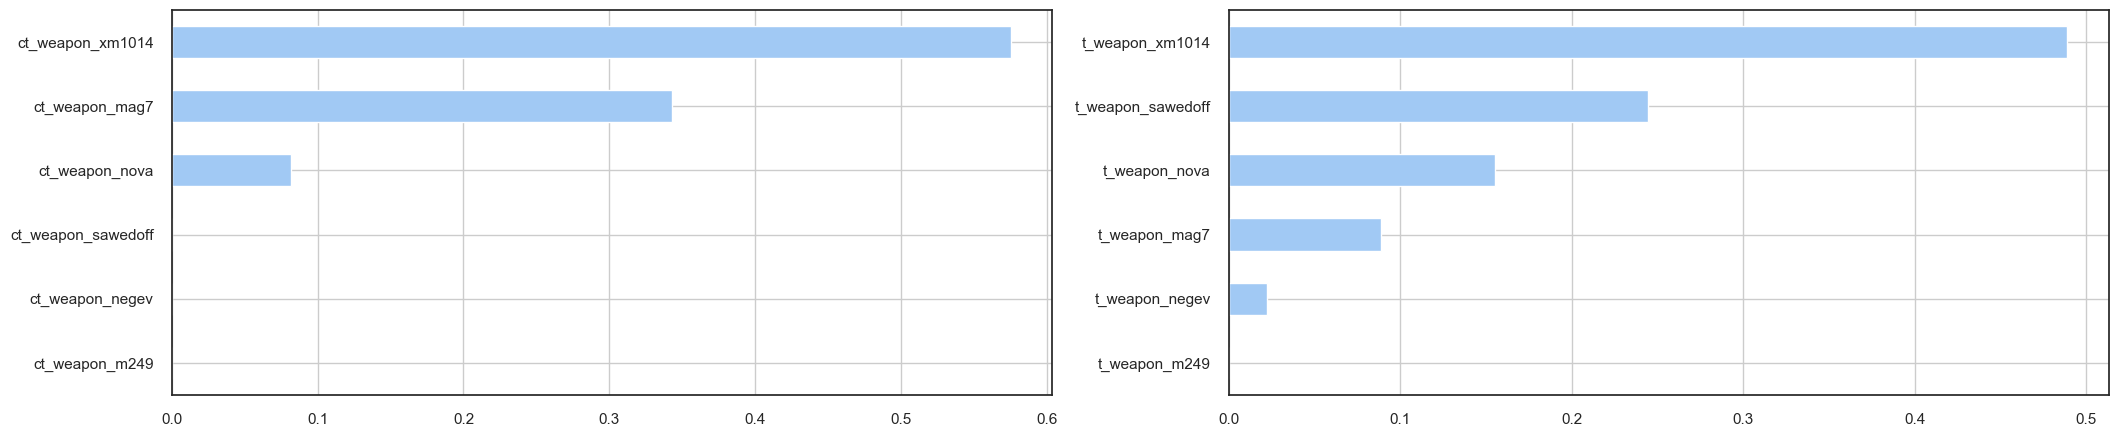

In [99]:
ct_heavies_data = ct_weapon_data[[r for r in  ct_weapon_data.columns if r in heavies]]
t_heavies_data = t_weapon_data[[r for r in  t_weapon_data.columns if r in heavies]]

# graph setup
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,5))

# Counter-Terrorists rifles
ct_weapon_percent = ct_heavies_data.sum() / ct_heavies_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax1, kind='barh')

# Terrorists rifles
t_weapon_percent = t_heavies_data.sum() / t_heavies_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax2, kind='barh')

ax1.grid()
ax2.grid()

#### (23) CT & T Pistols

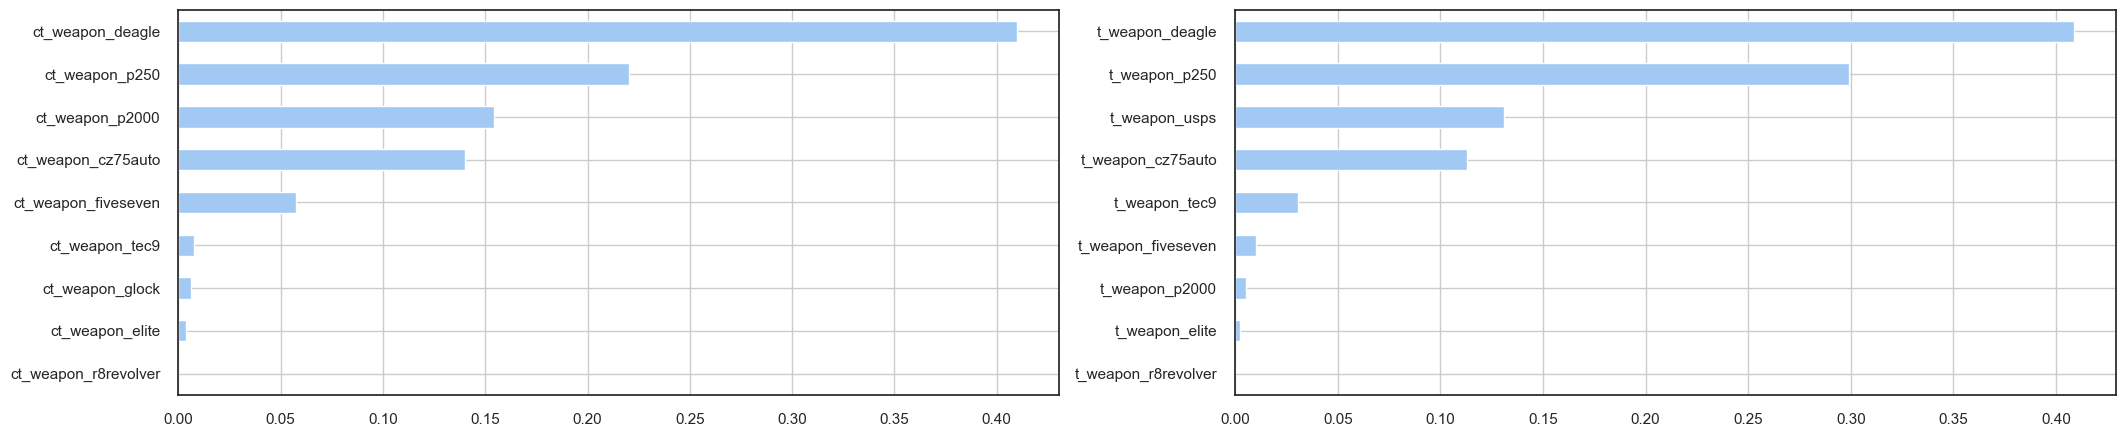

In [98]:
ct_pistols_data = ct_weapon_data[[r for r in  ct_weapon_data.columns if r in pistols]]
t_pistols_data = t_weapon_data[[r for r in  t_weapon_data.columns if r in pistols]]

# graph setup
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,5))

# Counter-Terrorists rifles
ct_weapon_percent = ct_pistols_data.sum() / ct_pistols_data.sum().sum()
ax = ct_weapon_percent.sort_values().plot(ax=ax1, kind='barh')

# Terrorists rifles
t_weapon_percent = t_pistols_data.sum() / t_pistols_data.sum().sum()
ax = t_weapon_percent.sort_values().plot(ax=ax2, kind='barh')

ax1.grid()
ax2.grid()

#### As the graphs show, the following weapons will be dropped, as they have NO, or a VERY SMALL impact for BOTH TEAMS. The ones with the random forest, where chosen after running the Random Forest Feature Importance algorithm and were Identified as insignificant.

Rifles: 
    * m4a1s
    * scar20
    * g3sg1
    * ssg08
    * famas
    * galilar (random forest)
    
SMGs:
    * bizon
    * p90
    * mp7
    * mp5sd
    * mac10 (random forest)
    
Heavies:
    * m249
    * negev
    * nova (random forest)
    * mag7 (random forest)
    * sawedoff (random forest)
    * xm1014 (random forest)

Pistols:
    * elite
    * r8revolver
    * tec9
    * fiveseven
    
   
Grenades:
    * decoygrenade
 

In [14]:
# drop weapons from dataframe
train_data = train_data.drop(['ct_weapon_scar20','t_weapon_scar20', 'ct_weapon_g3sg1','t_weapon_g3sg1', 'ct_weapon_bizon','t_weapon_bizon', 'ct_weapon_p90','t_weapon_p90',
                               'ct_weapon_mp7','t_weapon_mp7', 'ct_weapon_mp5sd','t_weapon_mp5sd', 'ct_weapon_m4a1s', 't_weapon_m4a1s', 'ct_weapon_ssg08', 't_weapon_ssg08',
                               'ct_weapon_famas', 't_weapon_famas', 'ct_weapon_elite', 't_weapon_elite', 'ct_weapon_r8revolver', 't_weapon_r8revolver', 'ct_weapon_tec9', 't_weapon_tec9',
                               'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_negev', 't_weapon_negev', 'ct_grenade_decoygrenade', 't_grenade_decoygrenade', 'map_de_cache',
                               'ct_weapon_nova', 't_weapon_nova', 'ct_weapon_sawedoff', 't_weapon_sawedoff', 'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mac10', 't_weapon_mac10',
                               'ct_weapon_xm1014', 't_weapon_xm1014', 'ct_weapon_xm1014', 't_weapon_xm1014', 'ct_weapon_galilar', 't_weapon_galilar'], axis=1)

test_data = test_data.drop(['ct_weapon_scar20','t_weapon_scar20', 'ct_weapon_g3sg1','t_weapon_g3sg1', 'ct_weapon_bizon','t_weapon_bizon', 'ct_weapon_p90','t_weapon_p90',
                               'ct_weapon_mp7','t_weapon_mp7', 'ct_weapon_mp5sd','t_weapon_mp5sd', 'ct_weapon_m4a1s', 't_weapon_m4a1s', 'ct_weapon_ssg08', 't_weapon_ssg08',
                               'ct_weapon_famas', 't_weapon_famas', 'ct_weapon_elite', 't_weapon_elite', 'ct_weapon_r8revolver', 't_weapon_r8revolver', 'ct_weapon_tec9', 't_weapon_tec9',
                               'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_negev', 't_weapon_negev', 'ct_grenade_decoygrenade', 't_grenade_decoygrenade', 'map_de_cache',
                               'ct_weapon_nova', 't_weapon_nova', 'ct_weapon_sawedoff', 't_weapon_sawedoff', 'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mac10', 't_weapon_mac10',
                               'ct_weapon_xm1014', 't_weapon_xm1014', 'ct_weapon_xm1014', 't_weapon_xm1014', 'ct_weapon_galilar', 't_weapon_galilar'], axis=1)

In [15]:
len(list(test_data.columns))

62

In [53]:
list(train_data.columns)

['time_left',
 'ct_score',
 't_score',
 'bomb_planted',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets',
 't_helmets',
 'ct_defuse_kits',
 'ct_players_alive',
 't_players_alive',
 'ct_weapon_ak47',
 't_weapon_ak47',
 'ct_weapon_aug',
 't_weapon_aug',
 'ct_weapon_awp',
 't_weapon_awp',
 'ct_weapon_cz75auto',
 't_weapon_cz75auto',
 'ct_weapon_glock',
 't_weapon_glock',
 'ct_weapon_m4a4',
 't_weapon_m4a4',
 'ct_weapon_mp9',
 't_weapon_mp9',
 'ct_weapon_sg553',
 't_weapon_sg553',
 'ct_weapon_ump45',
 't_weapon_ump45',
 'ct_weapon_deagle',
 't_weapon_deagle',
 'ct_weapon_fiveseven',
 't_weapon_fiveseven',
 'ct_weapon_usps',
 't_weapon_usps',
 'ct_weapon_p250',
 't_weapon_p250',
 'ct_weapon_p2000',
 't_weapon_p2000',
 'ct_grenade_hegrenade',
 't_grenade_hegrenade',
 'ct_grenade_flashbang',
 't_grenade_flashbang',
 'ct_grenade_smokegrenade',
 't_grenade_smokegrenade',
 'ct_grenade_incendiarygrenade',
 't_grenade_incendiarygrenade',
 'ct_grenade_molot

### After feature engineering has been done, the correlation of the features in the trainset will be examined again

Plotting the correlation matrix on the following variables : ['time_left', 'ct_score', 't_score', 'bomb_planted', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_glock', 't_weapon_glock', 'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mp9', 't_weapon_mp9', 'ct_weapon_sg553', 't_weapon_sg553', 'ct_weapon_ump45', 't_weapon_ump45', 'ct_weapon_deagle', 't_weapon_deagle', 'ct_weapon_fiveseven', 't_weapon_fiveseven', 'ct_weapon_usps', 't_weapon_usps', 'ct_weapon_p250', 't_weapon_p250', 'ct_weapon_p2000', 't_weapon_p2000', 'ct_grenade_hegrenade', 't_grenade_hegrenade', 'ct_grenade_flashbang', 't_grenade_flashbang', 'ct_grenade_smokegrenade', 't_grenade_smokegrenade', 'ct_grenade_incendiarygrenade']


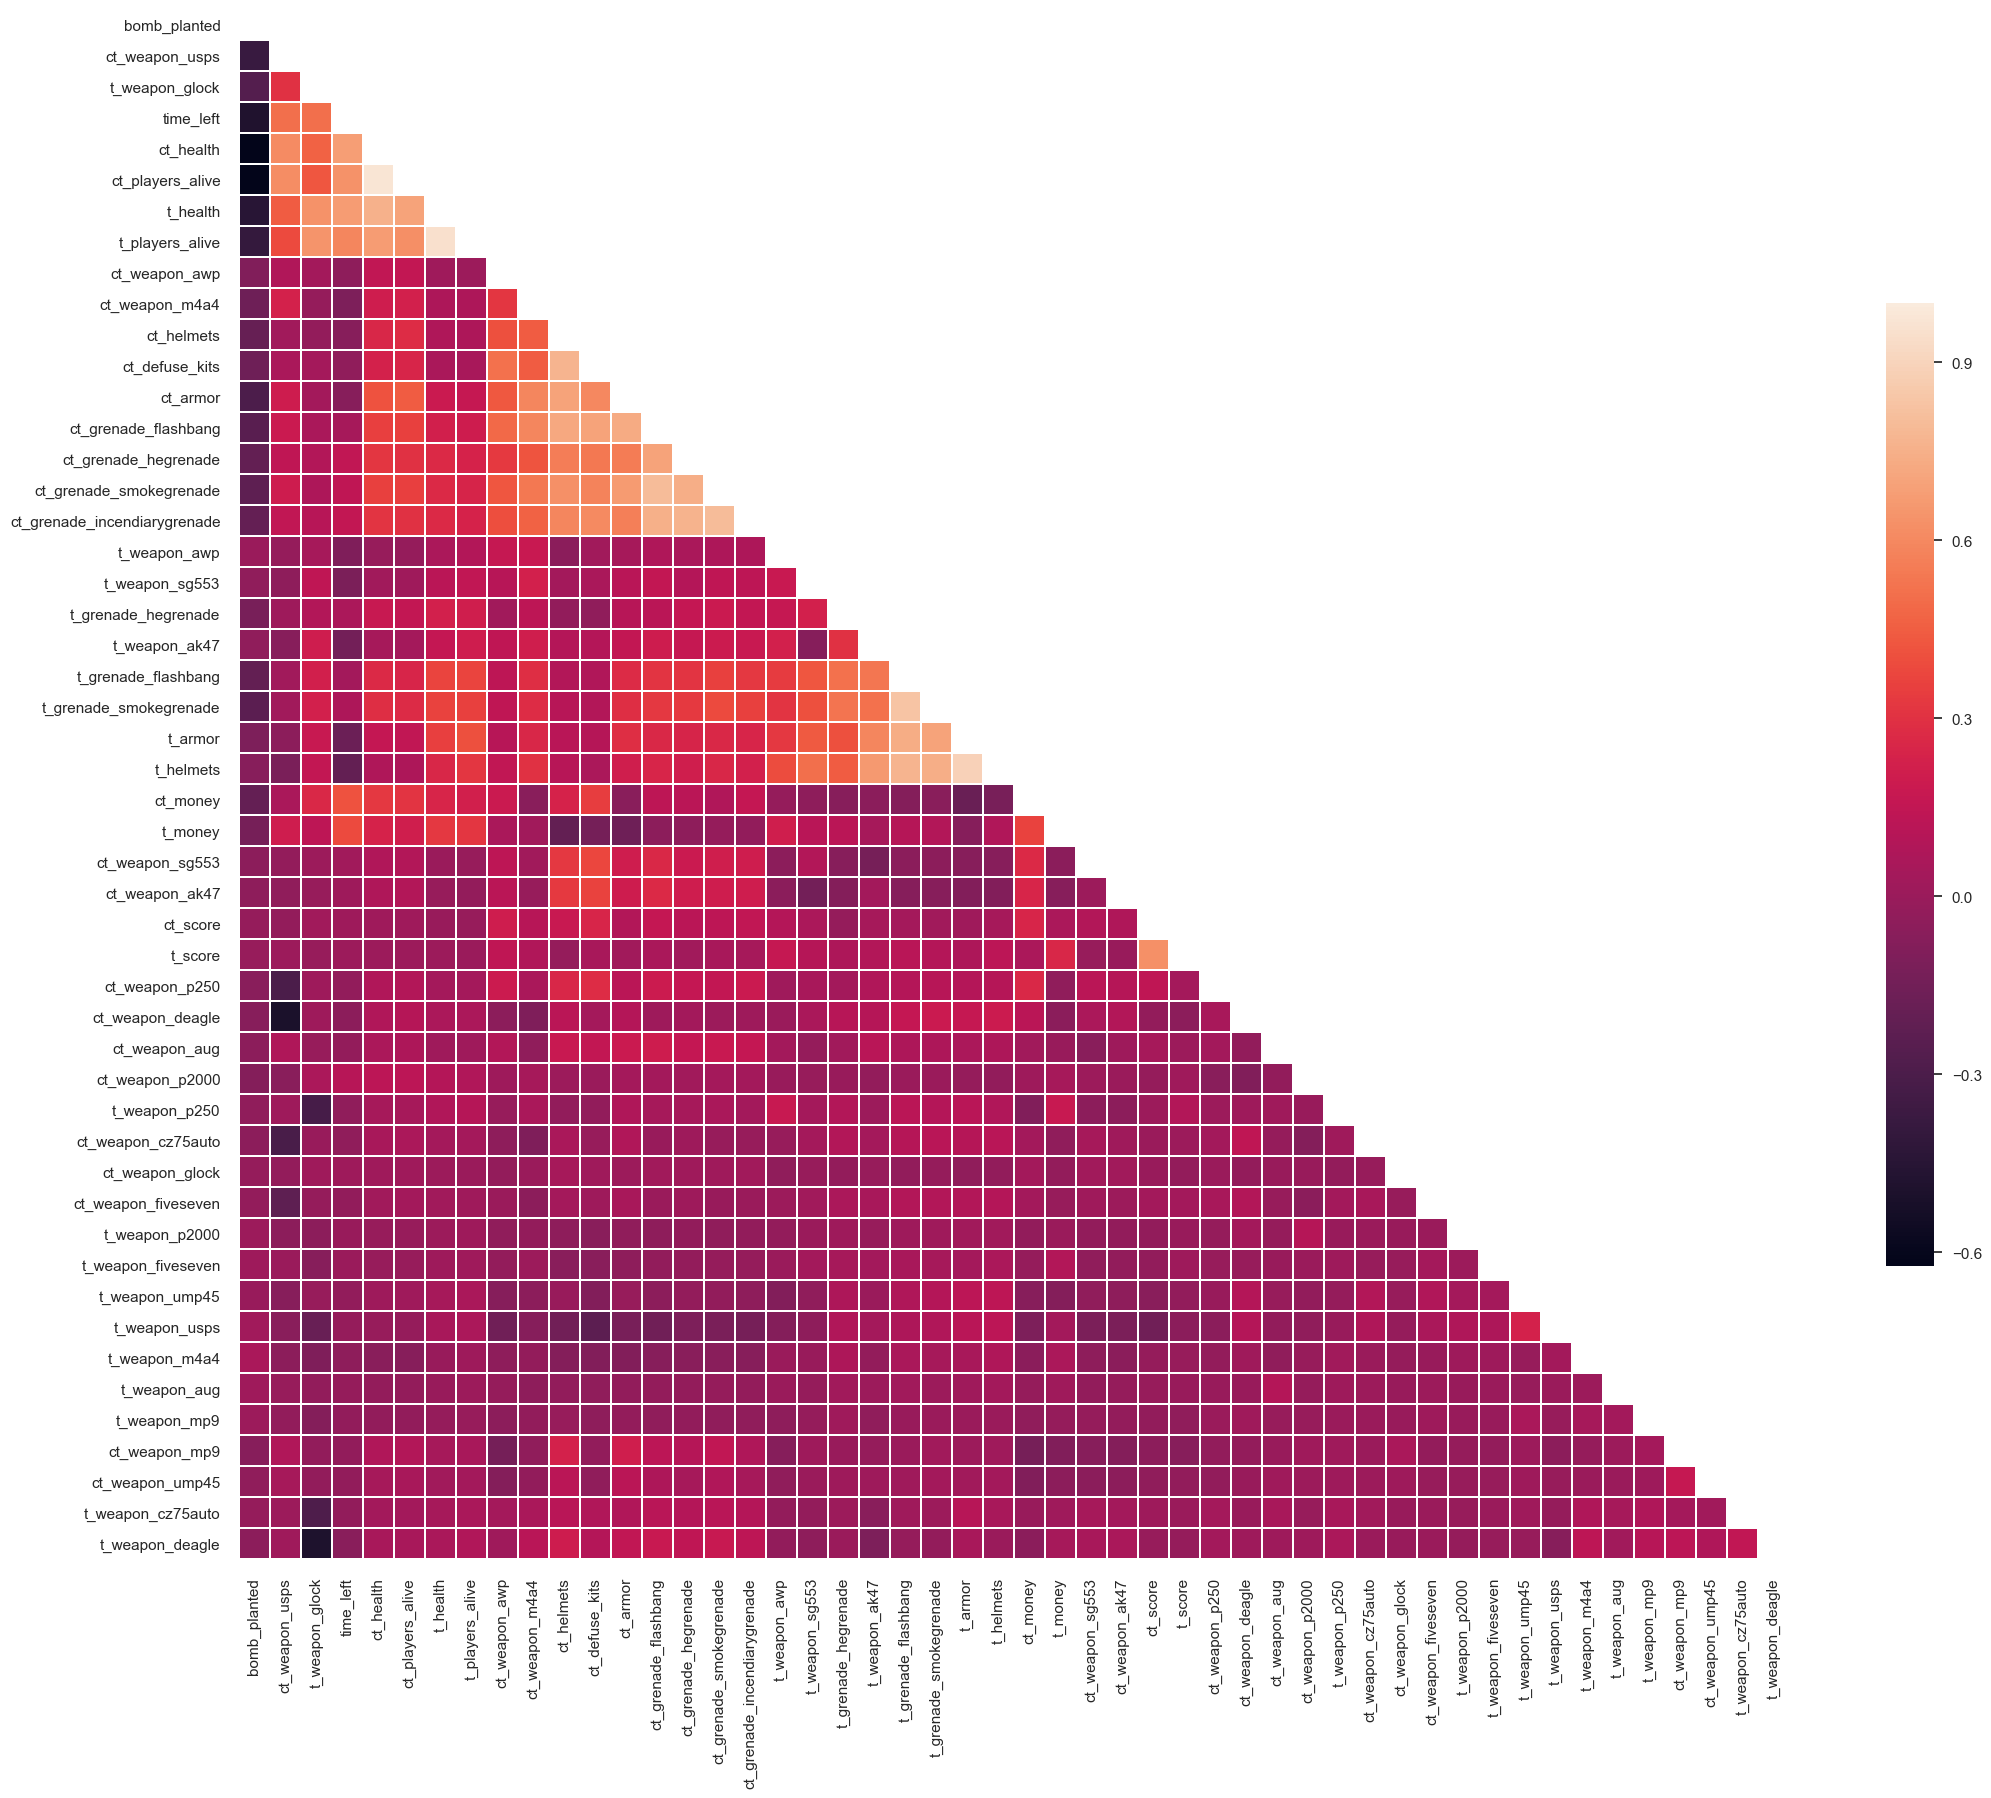

In [142]:
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix


# Get the column names
numerical_columns = list(train_data.select_dtypes(include=[np.number]).columns)
categorical_columns = list(train_data.select_dtypes(include=[object]).columns)
date_columns = list(train_data.select_dtypes(include=['<M8[ns]']).columns)

# Select variables to plot for the correlation matrix
corr_matrix_vars = numerical_columns[0:50]

print("Plotting the correlation matrix on the following variables : %s" % corr_matrix_vars)

# Only select the requested columns
df_corr_matrix = train_data[corr_matrix_vars]

# This computes the Pearson coefficient for all couples
corr = df_corr_matrix.corr().fillna(0)

# Generate features and distance matrix.
D = corr.values
# Compute and plot dendrogram.
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right',no_plot=True)
# Compute distance matrix.
index = Z['leaves']
D = D[index,:]
D = D[:,index]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
size = max(10, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(D, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)
#ax.set(xticks=range(len(corr.columns)), xticklabels=corr.columns[index], yticks=range(len(corr.columns)), yticklabels=reversed(corr.columns[index]))
ax.set_xticklabels(corr.columns[index], rotation=90, ha='center');
ax.set_yticklabels(corr.columns[index], rotation=0);

#### Correlations 

The correlation matric shows high correlations between the weapon groups. Which is understandable as if a player has a flashbang for example he can not have any other type of grenade. Similarly if a player has a glock he can not have a deagle as well. There correlations are understandable and accapted. 

The rest of the feature correlations look suitable. This train data set with 60 features will be used to train the respective models following

# V. Train-Test Splitting

***Even though the original datasets were already split into training and testing datasets, we still have to reassign them to the right variables, for later application purposes.***

In [16]:
# drop maps, time_left columns
test_data = test_data.drop("maps", axis = 1)
train_data = train_data.drop("maps", axis = 1)
test_data = test_data.drop("time_left", axis = 1)
train_data = train_data.drop("time_left", axis = 1)

# split into X_train y_train X_test y_test
X_train = train_data.drop("round_winner", axis = 1 )
y_train = train_data["round_winner"]

In [17]:
X_train.shape


(79239, 60)

In [18]:
y_train.shape

(79239,)

# VI. Machine Learning Algorithms

## 6.1. Log regression

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_log = sc.fit_transform(X_train)

In [21]:
# (1) Apply model to train data
lm_mod = linear_model.LogisticRegression(max_iter=5000)
lm_mod.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [22]:
# (2) Which features are most important in our model? 

def get_feature_importance(clf, feature_names):
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

get_feature_importance(lm_mod, X_train.columns)

In [23]:
len(X_train.columns)

60

In [114]:
# (3) Evaluate using Cross-Validation
cross_val_score(linear_model.LogisticRegression(max_iter=1000, solver='liblinear'), X_train, y_train, cv=10)

print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(linear_model.LogisticRegression( 
    max_iter=1000, solver='liblinear'), X_train, y_train, cv=10))))

print("AVG F1 of the 10 folds = {}".format(np.mean(cross_val_score(linear_model.LogisticRegression( 
    max_iter=1000, solver='liblinear'), X_train, y_train, cv=10, scoring='f1_macro'))))

AVG Accuracy of the 10 folds = 0.7559665697344979
AVG F1 of the 10 folds = 0.7559141490211628


In [115]:
# (4) Compare Evaluations
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', np.mean(cross_val_score(linear_model.LogisticRegression( 
    max_iter=100, solver='liblinear'), X_train, y_train, cv=10))]
results_df

Approach  Accuracy
0  LR Baseline  0.755967

## 6.2. Ridge Regression

In [116]:
# (1) Apply model to train data
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
# (2) Get feature importance
get_feature_importance(ridge_mod, X_train.columns)

In [118]:
# (3) Evaluate using Cross-Validation
# cross_val_score(ridge_mod, X_train, y_train, cv=5)

print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(ridge_mod, X_train, y_train, cv=5))))
print("AVG F1 of the 5 folds = {}".format(np.mean(cross_val_score(ridge_mod, X_train, y_train, cv=5, scoring='f1_macro'))))

AVG Accuracy of the 5 folds = 0.7549316259502646
AVG F1 of the 5 folds = 0.7548572255441901


In [119]:
# (4) Compare Evaluations
results_df.loc[len(results_df)] = ['LR Ridge', np.mean(cross_val_score(ridge_mod, X_train, y_train, cv=5))]
results_df

Approach  Accuracy
0  LR Baseline  0.755967
1     LR Ridge  0.754932

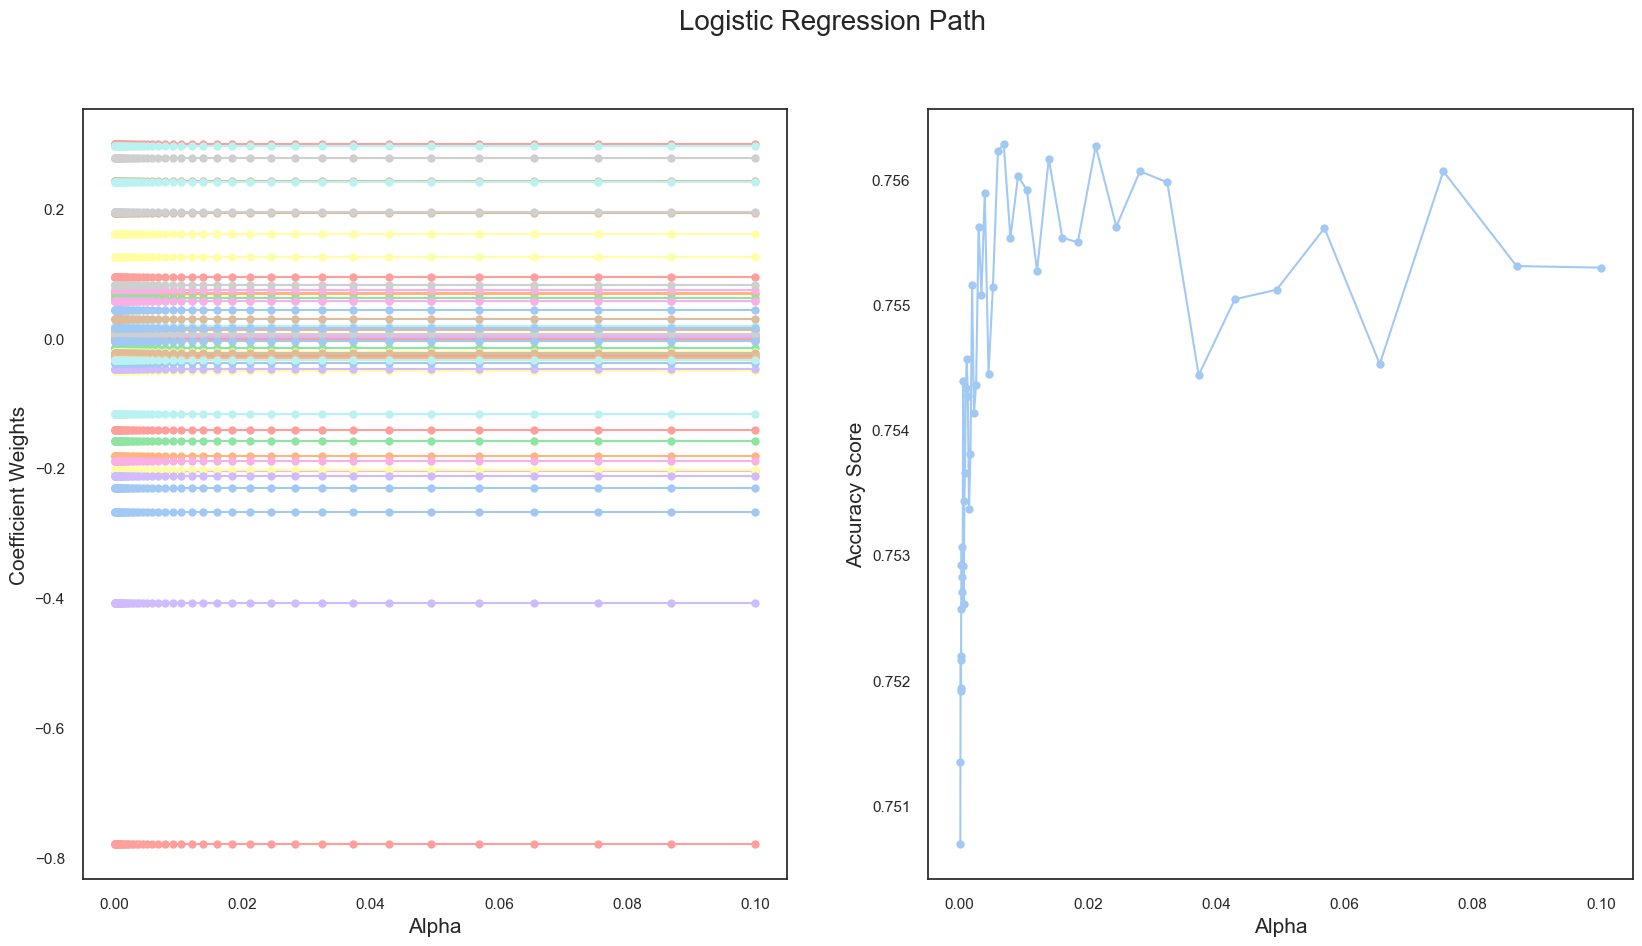

In [120]:
# (5) Best complexity level, alpha? 

alphas = 10**np.linspace(-1,-4,50)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    y_pred = cross_val_predict(ridge_mod, X_train, y_train, cv=5)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_train, y_pred))
    
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

In [121]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,10)

ridge_mod_alpha = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

In [122]:
# (4) Compare Evaluations
results_df.loc[len(results_df)] = ['LR Ridge Alpha', np.mean(cross_val_score(ridge_mod_alpha, X_train, y_train, cv=5))]
results_df

Approach  Accuracy
0     LR Baseline  0.755967
1        LR Ridge  0.754932
2  LR Ridge Alpha  0.751360

## 6.3. Lasso Regression

In [125]:
# (1) Apply model to train data
lasso_mod = linear_model.LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [126]:
# (2) Get feature importance - Not applicable for Lasso Regression (done internally)

In [127]:
# (3) Evaluate using Cross-Validation

# cross_val_score(ridge_mod, X_train, y_train, cv=5)
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(lasso_mod, X_train, y_train, cv=5))))
print("AVG F1 of the 5 folds = {}".format(np.mean(cross_val_score(lasso_mod, X_train, y_train, cv=5, scoring='f1_macro'))))

AVG Accuracy of the 10 folds = 0.7586670669069876
AVG F1 of the 10 folds = 0.7586275056983028


In [128]:
# (4) Compare Evaluations
results_df.loc[len(results_df)] = ['LR Lasso', np.mean(cross_val_score(lasso_mod, X_train, y_train, cv=5))]
results_df

Approach  Accuracy
0     LR Baseline  0.755967
1        LR Ridge  0.754932
2  LR Ridge Alpha  0.751360
3        LR Lasso  0.758743

## 6.4. Random Forest

A random forest algorithm will be explored as a solution to this classification problem. Due to the nature of random forest, it can handle data sets with many features. As our data set already only has 60 features no more manipulation to the data set will be done. 



##### Initial Predictions with default values

To get a initial idea of how a Random Forest will perform over this data set, a Random Forest model with default hyperparameters will be tested with cross validation and 5 folds. 

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [55]:
RandomForestClassifier()

sklearn.ensemble._forest.RandomForestClassifier

In [56]:
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(RandomForestClassifier(random_state=42), X_train, y_train, cv=5))))

AVG Accuracy of the 5 folds = 0.8432735991923271



An accuracy of 84.32 was ahieved. This seems very promising for using random forest as the model for our problem. 

### Hyperparameter optimization 

First a initial grid search will performed to get idea of optimum hyperperameter value regions 

In [189]:
## Grid search 
param_grid = {
    "n_estimators" : [100, 200, 300],
    "max_features" : ["sqrt", "log2"],
    "max_depth"    : range(22,27)
        
}
gs_random_forest = GridSearchCV(CS_bagging,param_grid, n_jobs= -1 )
gs_random_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(22, 27),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]})

In [191]:
print("Best parameters set found on development set:")
print()
print(gs_random_forest.best_params_)
print()
print("Grid scores on development set:")
print()
means = gs_random_forest.cv_results_['mean_test_score']
stds = gs_random_forest.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_random_forest.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (-mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 300}

Grid scores on development set:

MSE = -0.835 (+/0.011) for {'max_depth': 22, 'max_features': 'sqrt', 'n_estimators': 100}
MSE = -0.837 (+/0.011) for {'max_depth': 22, 'max_features': 'sqrt', 'n_estimators': 200}
MSE = -0.838 (+/0.011) for {'max_depth': 22, 'max_features': 'sqrt', 'n_estimators': 300}
MSE = -0.832 (+/0.010) for {'max_depth': 22, 'max_features': 'log2', 'n_estimators': 100}
MSE = -0.835 (+/0.013) for {'max_depth': 22, 'max_features': 'log2', 'n_estimators': 200}
MSE = -0.836 (+/0.011) for {'max_depth': 22, 'max_features': 'log2', 'n_estimators': 300}
MSE = -0.836 (+/0.009) for {'max_depth': 23, 'max_features': 'sqrt', 'n_estimators': 100}
MSE = -0.839 (+/0.011) for {'max_depth': 23, 'max_features': 'sqrt', 'n_estimators': 200}
MSE = -0.840 (+/0.012) for {'max_depth': 23, 'max_features': 'sqrt', 'n_estimators': 300}
MSE = -0.835 (+/0.011) for {'max_depth': 23, '

##### Initial Best parameters set found:

{'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 300}

 #### Cross validation - Optimum number of folds 
 
 In order to evaluate the accuracy of the random forest, first we decide to determine the optimum number of folds for the cross validation. A loop is used to test each fold feature from 5:12

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
for i in range(5,12) :
    print("Accuracy = {} , No fold =".format(np.mean(cross_val_score(RandomForestClassifier(random_state=42,max_depth= 26, n_estimators= 300, max_features= "sqrt", n_jobs= -1 ), X_train, y_train, cv=i))), i)

Accuracy = 0.8469586067642606 , No fold = 5
Accuracy = 0.8487255531562127 , No fold = 6
Accuracy = 0.8511231701161031 , No fold = 7
Accuracy = 0.8518298838970217 , No fold = 8
Accuracy = 0.8528649454075174 , No fold = 9
Accuracy = 0.8532306915699144 , No fold = 10
Accuracy = 0.8539628179199166 , No fold = 11


It can be seen that the accuracy does not increase significantly after 10 folds. Which is what will be used from now on. 

### Hyperparameter optimization with Randomized search 

Now to optermize the hyperparameters for the Random Forest randomsearchCV is used over a range of values. The range of values used is taken from the intitial search done previously.  


In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    'bootstrap':         [True, False],
    'max_depth':      RandomForestClassifier(random_state=42,max_depth= 36, n_estimators= 1000, max_features= "sqrt", n_jobs= 6, bootstrap= False,  min_samples_leaf= 1, min_samples_split= 2  )   randint(20,40),
    'max_features':      [ 'sqrt', 'log2'],
    'min_samples_leaf':  [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators':      [ 500, 750, 900, 1000, 1500]
   
}

search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, random_state=42, n_iter=200, cv=5, verbose=1, n_jobs=6, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 47.9min


#### The grid search was run on a different notebook, an image of the results is shown below:

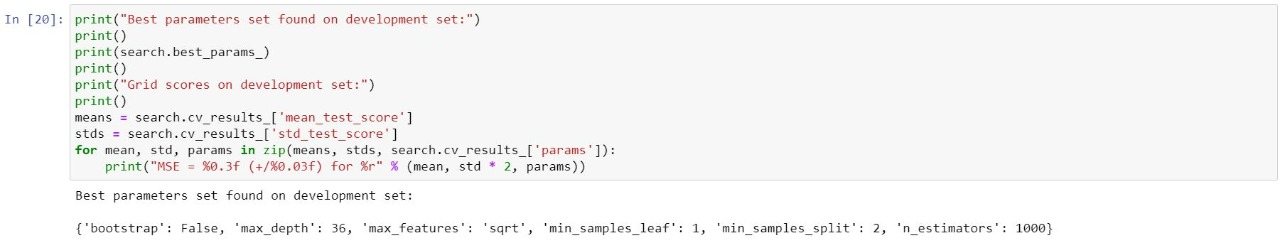

In [146]:
from IPython.display import Image 

Image("random_forest.jpeg")

From the search the optimum parameters found were: 
* 'n_estimators': 1000
* 'min_samples_split': 2
* 'min_samples_leaf': 1
* 'max_features': 'sqrt'
* 'max_depth': 36
* 'bootstrap': False 

#### Test Accuracy with Cross Validation 

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(RandomForestClassifier(random_state=42,max_depth= 36, n_estimators= 1000, max_features= "sqrt", n_jobs= 6, bootstrap=False,  min_samples_leaf= 1, min_samples_split= 2  ), X_train, y_train, cv=10))))

AVG Accuracy of the 10 folds = 0.8687645267854677


In [148]:
RFmodel = RandomForestClassifier(random_state=42,max_depth= 36, n_estimators= 1000, max_features= "sqrt", n_jobs= 6, bootstrap= False,  min_samples_leaf= 1, min_samples_split= 2)
RFmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=36, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=6, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [176]:
# creating predictions
predictions = RFmodel.predict(test_data)
len(predictions)

40396

In [179]:
# export predictions
# pd.DataFrame(predictions).to_csv('predictions.csv')

#### Feature Importance 

The feature importance will be explored to get a better idea of the working of the model 

In [72]:
feature_import = pd.DataFrame( X_train.columns, RFmodel.feature_importances_)
feature_import.reset_index().sort_values("index", ascending = False).head(60)


importances = pd.Series(
    RFmodel.feature_importances_,
    index = X_train.columns
)
importances = pd.DataFrame(importances).reset_index() 
importances.columns = ["column", "importance"]
importances.sort_values("importance", ascending = False).head(20)

column  importance
7                   t_armor    0.078486
6                  ct_armor    0.072650
9                   t_money    0.051671
8                  ct_money    0.051365
11                t_helmets    0.044351
0                 time_left    0.035575
5                  t_health    0.035036
10               ct_helmets    0.033034
4                 ct_health    0.031637
12           ct_defuse_kits    0.031406
2                   t_score    0.030800
1                  ct_score    0.030423
45     ct_grenade_flashbang    0.027530
16            t_weapon_ak47    0.026402
46      t_grenade_flashbang    0.021687
14          t_players_alive    0.021435
25           ct_weapon_m4a4    0.020894
37           ct_weapon_usps    0.020592
24           t_weapon_glock    0.020256
47  ct_grenade_smokegrenade    0.019555

It can be seen that the percentage variance explained by each of the variables is quite low. Meaning that no one variable dominates the decision making. However, bearing that in mind, the amount of armor and money of the teams have the highest importance. This makes sense as the amount of armor a player has reduces the probability of that player being killed. Money gives the player optionality to buy weapons, grenades ect to adapt to the situation.d

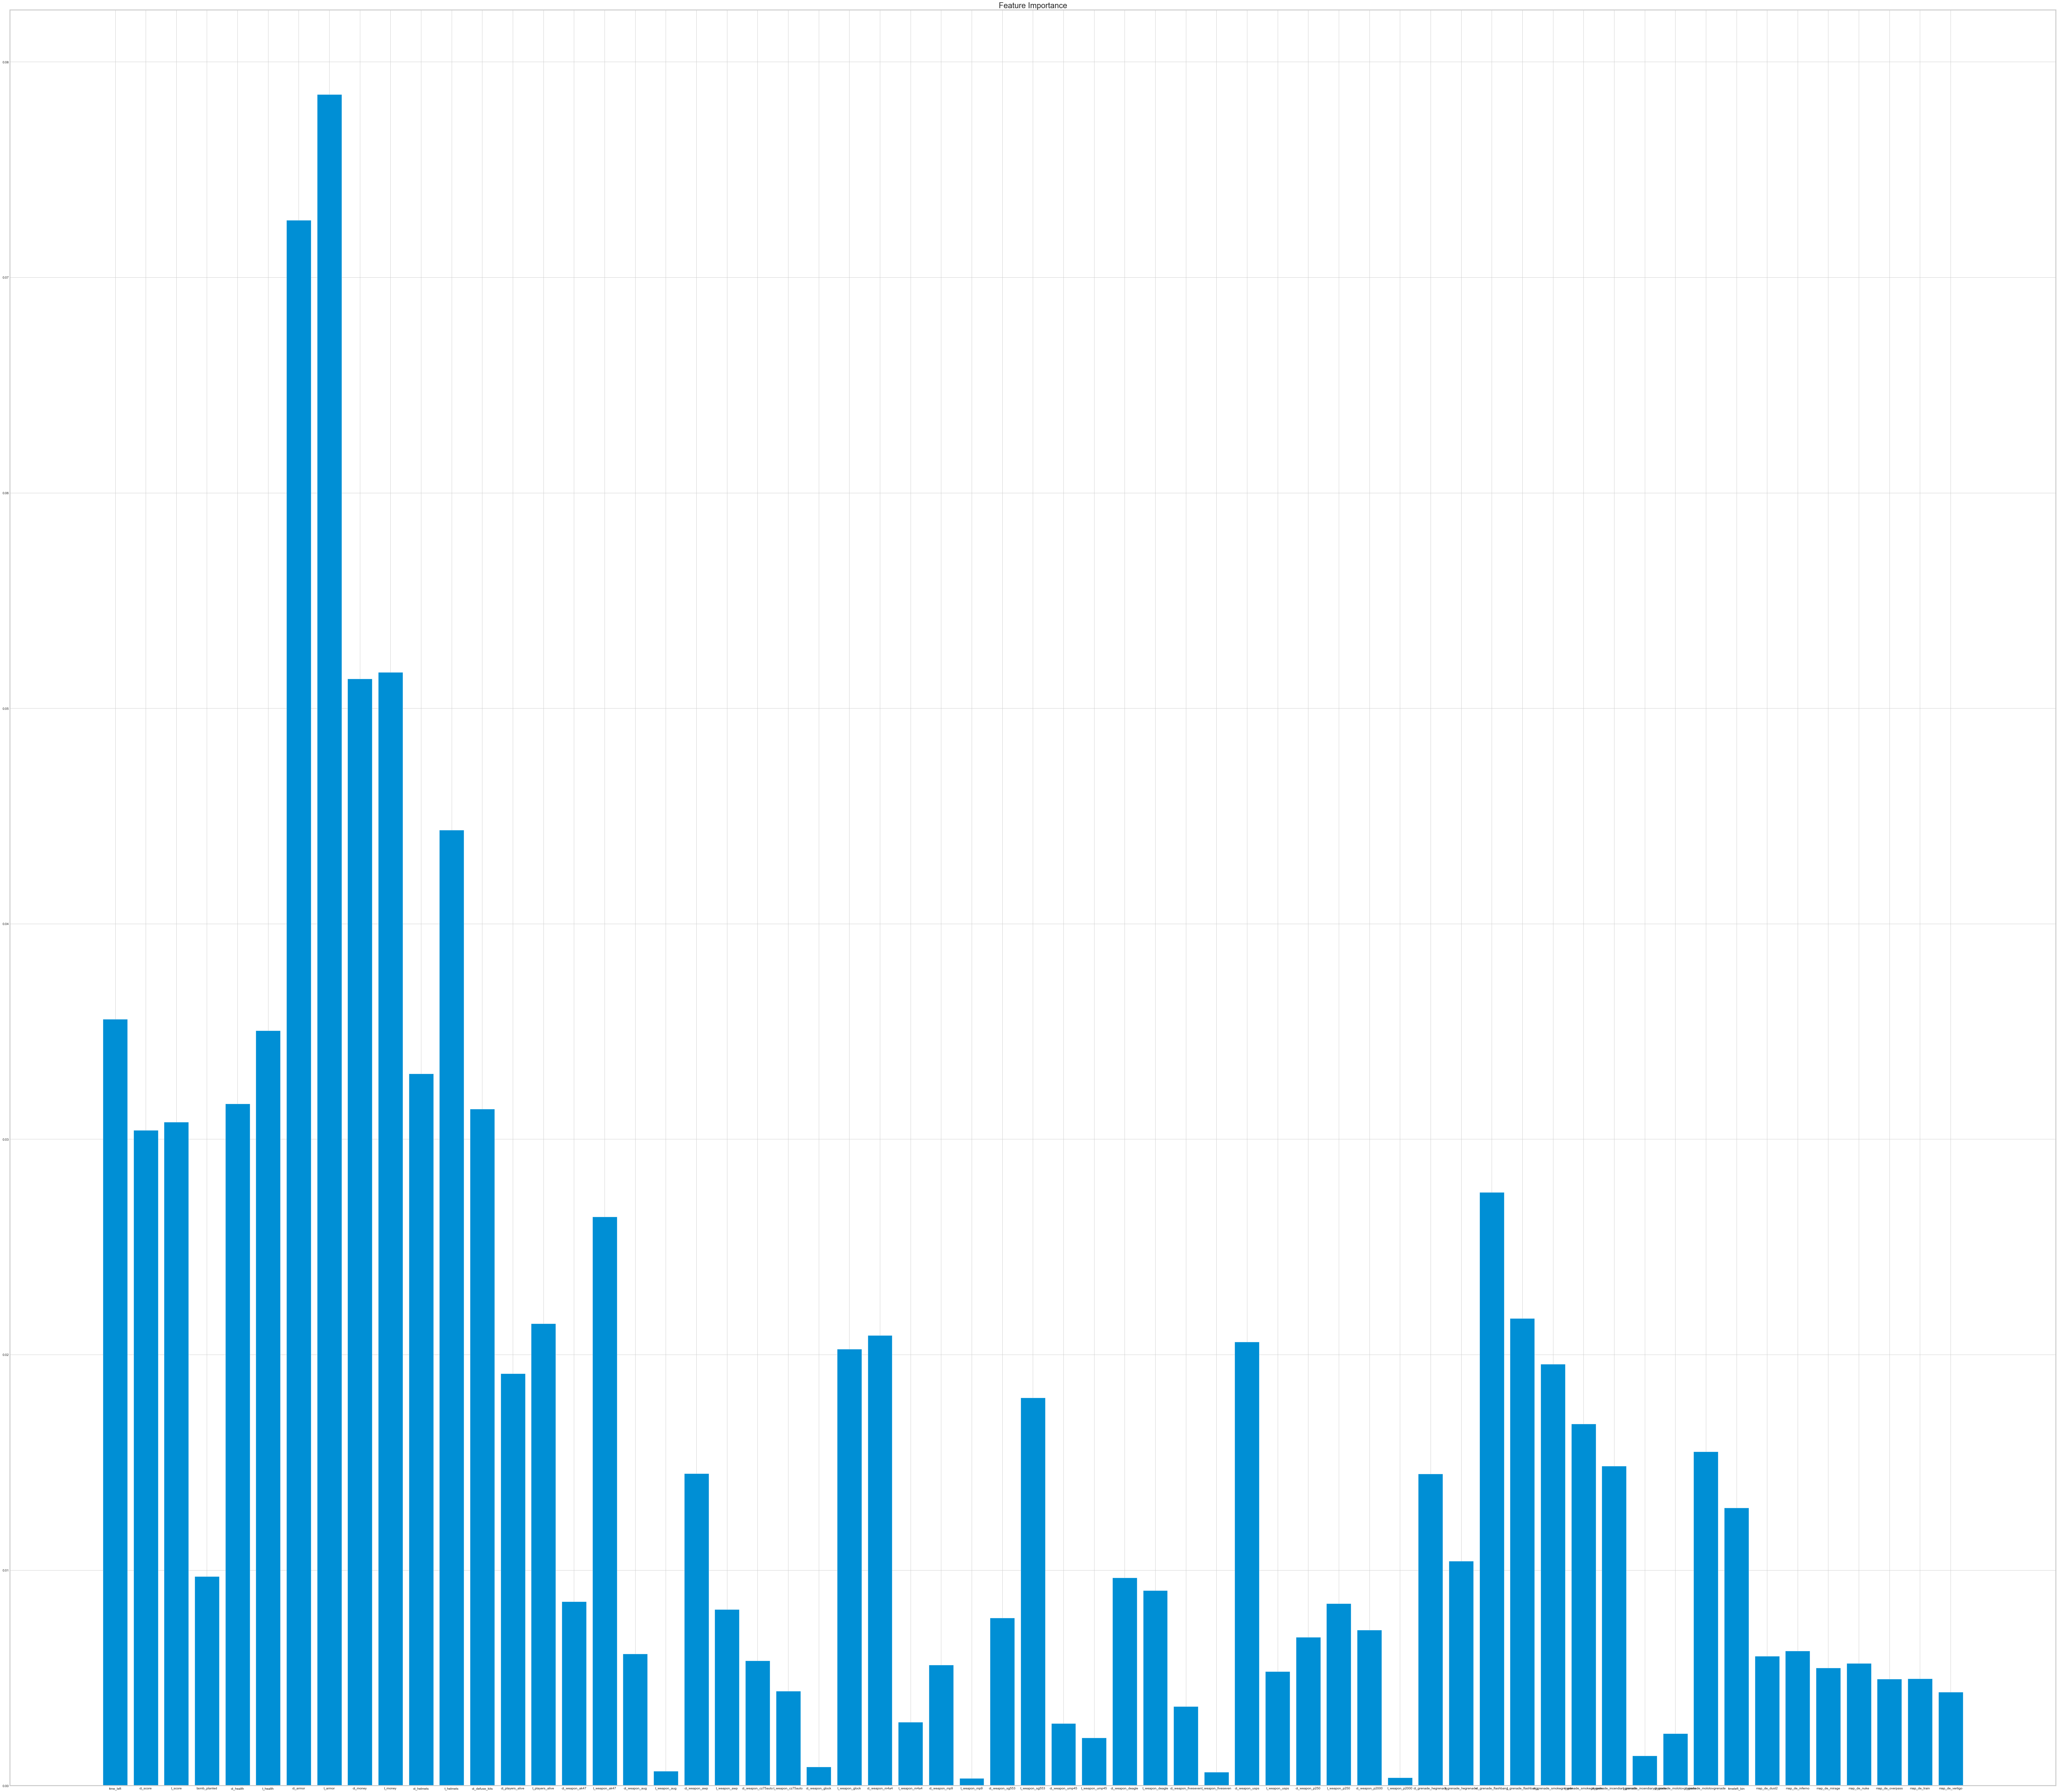

In [36]:
plt.figure(figsize=(100,100))
plt.bar(X_train.columns, RFmodel.feature_importances_)
plt.title('Feature Importance', fontsize=24);

## 6.5. XG boost 

In [48]:
#  ! pip install xgboost
import xgboost

##### Cross validation XGboost

In [211]:
## default hyperparameters: 
    
print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(xgboost.XGBClassifier(objective="binary:logistic", random_state=42), X_train, y_train, cv=10))))

AVG Accuracy of the  folds = 0.7994194851085311


#### Optimize hyperparameters

In [51]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_tree, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=6, return_train_score=True)
search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 26.3min
[Parallel(n_jobs=6)]: Done 600 out of 600 | elapsed: 35.8min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002EA045A8550>,
                                        'max_dep

In [54]:
print("Best parameters set found on development set:")
print()
print(search.best_params_)
print()
print("Grid scores on development set:")
print()
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    print("MSE = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}

Grid scores on development set:

MSE = 0.764 (+/0.012) for {'colsample_bytree': 0.8123620356542087, 'gamma': 0.4753571532049581, 'learning_rate': 0.24959818254342153, 'max_depth': 2, 'n_estimators': 120, 'subsample': 0.6624074561769746}
MSE = 0.791 (+/0.008) for {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}
MSE = 0.770 (+/0.010) for {'colsample_bytree': 0.7061753482887407, 'gamma': 0.48495492608099716, 'learning_rate': 0.2797327922401265, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.6727299868828402}
MSE = 0.783 (+/0.012) for {'colsample_bytree': 0.7550213529560301, 'gamma': 0.15212112147976886, 'learning_rate': 0.18742692948

#### Cross Validation

In [55]:
print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(xgboost.XGBClassifier(objective="binary:logistic", random_state=42, colsample_bytree = 0.7467983561008608, gamma = 0.02904180608409973, learning_rate = 0.28985284373248055, max_depth = 5, n_estimators = 139, subsample = 0.8832290311184181 ), X_train, y_train, cv=10))))

AVG Accuracy of the  folds = 0.7943462897526502


In [ ]:
predictions = search.best_estimator_.predict(X_test)


## 6.6. SVM

***Since our computing power is limited, we decided not to run the SVM Algorithms inside this notebook, but used Dataiku instead. Please see report.***

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score

***As SVM used is a distance based method, scaling of the features is necessary in order for the model to not be disproportionately influenced by a subset of features on a large scale.***

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_svm = sc.fit_transform(X_train)

***C that controls the penalty of wrongly categorize datapoints depending on their distance from the separating hyperplane. Selecting a proper C value is crucial to the generalizability of the SVM.***

### Linear Kernel

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

C = 10
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(svm.SVC(C,kernel='linear', gamma=0.01)), X_train_svm, y_train, cv=5)))

***To create predictions use the following code. 

In [ ]:
# linear Kernel
from sklearn import svm

C = 1

clf = svm.SVC(C,kernel='linear')
clf.fit(X_train_svm, y_train)

In [ ]:
# present image
def plot_svm_decision(X_train, y_train, clf):

    plt.figure(figsize=(15,15))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:,0], cmap=plt.cm.RdBu)
    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.show()
    
    
plot_svm_decision(X_train_svm, y_train, clf)

### RBF Kernel

In [ ]:
C = 1

clf = svm.SVC(C, kernel='rbf')
clf.fit(X_train_svm, y_train)

#plot_svm_decision(X_train, y_train, clf)

In [ ]:
C = 10
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(svm.SVC(C,kernel='rbf', gamma=0.01)), X_train_svm, y_train, cv=5)))

### Sigmoid Kernel

In [ ]:
C = 100

clf = svm.SVC(C, kernel='sigmoid')
clf.fit(X_train_svm, y_train)

plot_svm_decision(X_train, y_train, clf)

In [ ]:
C = 10
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(svm.SVC(C,kernel='sigmoid', gamma=0.01)), X_train_svm, y_train, cv=5)))

### Polynomial Kernel

In [ ]:
C = 100

clf = svm.SVC(C, kernel='polynomial')
clf.fit(X_train_svm, y_train)

plot_svm_decision(X_train, y_train, clf)

In [ ]:
C = 10
print("AVG Accuracy of the 10 folds = {}".format(np.mean(cross_val_score(svm.SVC(C,kernel='polynomial', gamma=0.01)), X_train_svm, y_train, cv=5)))

In [ ]:
# present image
degree = 1

def svm_polynomial_kernel(degree=degree):

    clf = svm.SVC(degree=degree, kernel='poly')
    clf.fit(train.iloc[:,1:3], train.Label)

    plt.figure(figsize=(15,15))

    # create a mesh to plot in
    x_min, x_max = train.iloc[:, 1].min(), train.iloc[:, 1].max()
    y_min, y_max = train.iloc[:, 2].min(), train.iloc[:, 2].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2), np.arange(y_min, y_max, 0.2))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)

    # Plot also the training points
    plt.scatter(train.iloc[:, 1], train.iloc[:, 2], c=train.Label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()
    
svm_polynomial_kernel(degree)

In [ ]:
for i in range(1,10):
    print("Polynomial Kernel with degree = {}".format(i))
    svm_polynomial_kernel(i)

### Actual Classification with most suitable Kernel

In [ ]:
C = 10
print("AVG Accuracy of the 5 folds = {}".format(np.mean(cross_val_score(svm.SVC(C,kernel='linear', gamma=0.01)), X_train_svm, y_train, cv=5)))

In [ ]:
# test and find best parameters

from sklearn.model_selection import GridSearchCV

param_grid = {"C":[1,5,10,100], "gamma":[0.01,0.0001,0.00001]}

estimator = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=5)
estimator.fit(X_train_svm, y_train);

In [ ]:
print("The best parameters are %s with a score of %0.2f"
      % (estimator.best_params_, estimator.best_score_))


scores = estimator.cv_results_['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

# Draw heatmap of the validation accuracy as a function of gamma and C

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.title('Validation accuracy')
plt.show()

https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://www.theanalysisfactor.com/chi-square-test-vs-logistic-regression-is-a-fancier-test-better/

http://web.pdx.edu/~newsomj/pa551/lectur21.htm

https://scikit-learn.org/stable/modules/model_evaluation.html

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.axes.Axes.plot.html